# Setup: Environment Configuration and Imports

**Description:**
This cell sets up the workspace environment by:
- Configuring the Python path to allow importing from the `src/` module
- Defining all key workspace paths (data, cache, plots directories)
- Importing essential libraries (pandas, numpy, matplotlib)
- Loading custom modules from the `src/` package

**Usage:**
Run this cell first to initialize the notebook environment. It must be executed before any other cells that depend on workspace paths or custom modules.

In [108]:
import sys
import os
from pathlib import Path
import importlib

# The notebooks are in a 'notebooks' subfolder, so workspace root is one level up
# This works if notebook is in notebooks/ folder
workspace_root = Path.cwd().parent.resolve()

# Add workspace root to path so we can import from src
sys.path.insert(0, str(workspace_root))

WORKSPACE_ROOT = workspace_root
DATA_DIR = WORKSPACE_ROOT / "data"
DATA_XLSX = DATA_DIR / "daily_energy.xlsx"
DATA_XLSX_HISTORICAL = DATA_DIR / "daily_energy_historical.xlsx"
CACHE_DIR = WORKSPACE_ROOT / "pvgis_cache"
PLOTS_DIR = WORKSPACE_ROOT / "plots"
DATA_XLSX_HISTORICAL = DATA_DIR / "daily_energy_historical.xlsx"
DATA_XLSX_TOTAL_IRR = DATA_DIR / "Exported Data-20150101T000000.xlsx"
DATA_XLSX_TOTAL_FULL = DATA_DIR / "column_full_export.xlsx"

# Define all project directories
BRONZE_ROOT = WORKSPACE_ROOT / "bronze"
SILVER_ROOT = WORKSPACE_ROOT / "silver"
MAPPINGS_ROOT = WORKSPACE_ROOT / "mappings"
PVGIS_CACHE = WORKSPACE_ROOT / "pvgis" / "pvgis_cache"
PVGIS_OUTPUT = WORKSPACE_ROOT / "pvgis" / "pvgis_typical_year"
DOCS_DIR = WORKSPACE_ROOT / "docs"
OUTPUTS_DIR = WORKSPACE_ROOT / "outputs"

# Create all necessary directories
directories = [
    DATA_DIR,
    DATA_DIR / "inbox",
    DATA_DIR / "processing",
    DATA_DIR / "rejected",
    DATA_DIR / "archived",
    DATA_DIR / "backups",
    DATA_DIR / "_locks",
    BRONZE_ROOT,
    BRONZE_ROOT / "_ops",
    BRONZE_ROOT / "_ops" / "run_logs",
    BRONZE_ROOT / "scada_1d_signal",
    SILVER_ROOT,
    SILVER_ROOT / "_ops",
    MAPPINGS_ROOT,
    PVGIS_CACHE,
    PVGIS_CACHE / "typical_daily",
    PVGIS_OUTPUT,
    PLOTS_DIR,
    PLOTS_DIR / "financial_analysis",
    PLOTS_DIR / "stl_analysis",
    PLOTS_DIR / "weekly_analysis",
    PLOTS_DIR / "pvgis_typical_year_eda",
    DOCS_DIR,
    OUTPUTS_DIR,
]

for directory in directories:
    directory.mkdir(parents=True, exist_ok=True)
    
print(f"✓ Created {len(directories)} project directories")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import pvgis_pi_heatmap
importlib.reload(pvgis_pi_heatmap)  # Reload to pick up any changes

from src.pvgis_pi_heatmap import make_random_greece_meta, compute_pi_anomaly, short_label, parse_kwp_from_header
from src.utils import save_figure


✓ Created 24 project directories


# Column Sanitization: Recompute Mapping Versions

**Description:**
Two-step sanitization approach for consistent column naming:

**Step 1: Park ID Resolution**
- Extracts park name and capacity from column header: `[4E Energeiaki 176 kWp]`
- Looks up canonical `park_id` from `park_metadata.csv` by matching:
  - Park name (normalized comparison)
  - Capacity (if available, with tolerance)
  - Fuzzy match on park_id
- Falls back to sanitized park name if no match found

**Step 2: Signal Sanitization**
- Sanitizes signal name independently: `PCC Active Energy Export (kWh)` → `pcc_active_energy_export`
- Extracts and normalizes unit: `(kWh)` → `kwh`

**Step 3: Concatenation**
- Final format: `{park_id}__{signal_name}__{unit}`
- Example: `4e_energeiaki_176_kwp_likovouni__pcc_active_energy_export__kwh`

**Benefits:**
- Both bronze/silver and PVGIS use the same canonical park_id from metadata
- Ensures column alignment when computing ratios and joining datasets
- No character limit constraints - full descriptive names preserved
- Metadata is the single source of truth for park identifiers

**Usage:**
Uncomment the last lines to run:
- `recompute_sanitized_columns()` - Process new inbox files with existing mappings
- `recompute_sanitized_columns(resanitize_current=True)` - Re-sanitize all columns from scratch

In [113]:
# Regenerate column mapping with updated sanitizer
import importlib
from src import column_sanitizer

# Reload module to pick up any code changes
importlib.reload(column_sanitizer)

# Generate mapping from inbox columns
mapping_path = column_sanitizer.recompute_sanitized_columns(
    workspace_root=WORKSPACE_ROOT,
    resanitize_current=True,
    prompt_missing_capacity=False,
    default_capacity_kwp=1.0,
)

print(f"✓ Mapping generated: {mapping_path.name}")
print(f"✓ Active mapping set in current.txt")

Loaded 3 mapping versions, 1184 total entries.

Recomputed sanitized columns. Showing first 10:
 - datetime
 - p_4e_energeiaki_likovouni__176_kwp__average_irradiance__w_m_2
 - p_4e_energeiaki_likovouni__176_kwp__pcc_current_thd_r_of_neutral__pct
 - p_4e_energeiaki_likovouni__176_kwp__pcc_current_thd_r_of_phase_l1__pct
 - p_4e_energeiaki_likovouni__176_kwp__pcc_current_thd_r_of_phase_l2__pct
 - p_4e_energeiaki_likovouni__176_kwp__pcc_current_thd_r_of_phase_l3__pct
 - p_4e_energeiaki_likovouni__176_kwp__pcc_active_energy_export__kwh
 - p_4e_energeiaki_likovouni__176_kwp__pcc_active_energy_import__kwh
 - p_4e_energeiaki_likovouni__176_kwp__pcc_apparent_energy__kvah
 - p_4e_energeiaki_likovouni__176_kwp__pcc_average_current__a
Total mappings: 1184
No new columns detected; skipping new mapping version.
✓ Mapping generated: park_power_mapping_v012.csv
✓ Active mapping set in current.txt


# Bronze Layer: Configure Ingestion Pipeline

**Description:**
Configures the bronze ingestion pipeline that processes raw SCADA data:
- Sets up folder structure (inbox, processing, archived, rejected)
- Loads the active column mapping from `mappings/current.txt`
- Configures ingestion parameters (timezone, compression, duplication handling)
- Prepares the ingestion engine with timezone and parquet settings

**Usage:**
Run this cell to initialize the bronze ingestion configuration. The config object (`cfg`) is used by the next cell to execute the actual ingestion.

In [110]:
# Run bronze ingestion with versioned mapping support
# Reads mappings/current.txt to determine active mapping file
from pathlib import Path
import importlib
from src import bronze_ingest as bi

# Reload module to pick up any code changes
importlib.reload(bi)

# Paths
DATA_ROOT = WORKSPACE_ROOT / "data"
BRONZE_ROOT = WORKSPACE_ROOT / "bronze"
SILVER_ROOT = WORKSPACE_ROOT / "silver"
MAPPINGS_ROOT = WORKSPACE_ROOT / "mappings"

# Ensure expected folders exist
for p in [
    DATA_ROOT / "inbox",
    DATA_ROOT / "processing",
    DATA_ROOT / "archived",
    DATA_ROOT / "rejected",
    DATA_ROOT / "_locks",
    BRONZE_ROOT,
    MAPPINGS_ROOT,
]:
    p.mkdir(parents=True, exist_ok=True)

# Build config (min_age_seconds=0 to ingest immediately in notebook)
cfg = bi.Config(
    data_root=DATA_ROOT,
    inbox=DATA_ROOT / "inbox",
    processing=DATA_ROOT / "processing",
    archived=DATA_ROOT / "archived",
    rejected=DATA_ROOT / "rejected",
    bronze_root=BRONZE_ROOT,
    mappings_root=MAPPINGS_ROOT,
    dataset_name="scada_1d_signal",
    timezone_local="Europe/Athens",
    daily_interval_end_is_midnight=True,
    parquet_compression="zstd",
    min_age_seconds=0,
    stable_check_seconds=0,
    sheet_name=None,
    csv_sep=None,
    csv_encoding=None,
    allow_duplicates=False,
)

cfg.lockfile = DATA_ROOT / "_locks" / "bronze_ingest.lock"

# Run ingestion (reads mappings/current.txt to find active mapping, applies it, writes bronze with mapping metadata)
print(f"Mappings root: {MAPPINGS_ROOT}")
print(f"Current mapping: {(MAPPINGS_ROOT / 'current.txt').read_text().strip()}")

Mappings root: C:\00_Dev\daily_avg_pv_kpi_heatmap\mappings
Current mapping: park_power_mapping_v012.csv


# Bronze Layer: Execute Ingestion

**Description:**
Executes the bronze ingestion process:
- Reads files from the `data/inbox/` folder
- Applies column sanitization using the active mapping version
- Writes partitioned parquet files to `bronze/scada_1d_signal/year=YYYY/`
- Moves processed files to `archived/` or `rejected/`
- Creates run logs in `bronze/_ops/run_logs/`

**Usage:**
Run to ingest new files from inbox. Use `bi.reset_dataset(cfg, remove_run_logs=True)` (first line, commented) to clear the bronze layer if needed.

## Step 7.5: Pre-process Inbox Files (Sanitize Column Names)

**Description:**
Sanitizes vendor column names in Excel files BEFORE bronze ingestion:
- Reads each file in `data/inbox/`
- Applies the active mapping (park_power_mapping_vXXX.csv) to rename columns
- Replaces the file with sanitized columns
- Ensures columns match the expected pattern `park_id__signal_name__unit`

**Prerequisite:** Run cell 4 first to generate park_power_mapping_vXXX.csv

**Usage:**
Run this before bronze ingestion if inbox files have vendor column names.

In [111]:
# File Sanitization Pipeline
from src.file_sanitizer import sanitize_inbox_files, restore_rejected_files

# Step 1: Restore any rejected files for reprocessing
restored_count = restore_rejected_files(DATA_ROOT, verbose=True)

if restored_count == 0:
    print("\nNo files to process. Place vendor Excel files in data/inbox/")
else:
    print(f"\n{'='*60}")

# Step 2: Sanitize files using active mapping
current_mapping = (MAPPINGS_ROOT / "current.txt").read_text().strip()
mapping_path = MAPPINGS_ROOT / current_mapping

print(f"\nUsing mapping: {current_mapping}")
print("="*60)

results = sanitize_inbox_files(
    inbox_dir=DATA_ROOT / "inbox",
    output_dir=DATA_ROOT / "inbox",  # In-place sanitization
    mapping_path=mapping_path,
    backup_dir=DATA_ROOT / "backups",
    dry_run=False,
    verbose=True
)

# Summary
print("\n" + "="*60)
print("SANITIZATION SUMMARY")
print("="*60)
print(f"✓ Successful: {results.success_count}")
print(f"⚠️  Warnings: {results.warning_count}")
print(f"✗ Failed: {results.failed_count}")

if results.warnings:
    print("\nWarnings:")
    for filename, msg in results.warnings:
        print(f"  {filename}: {msg}")

if results.failed:
    print("\nFailures:")
    for filename, msg in results.failed:
        print(f"  {filename}: {msg}")

Found 3 rejected files to restore
  ✓ Restored: Exported Data-20150101T000000.xlsx
  ✓ Restored: Exported Data-20150101T000000.xlsx
  ✓ Restored: Exported Data-20150101T000000.xlsx


Using mapping: park_power_mapping_v012.csv
Loaded mapping with 1184 column transformations
Found 1 Excel files in inbox

Processing: Exported Data-20150101T000000.xlsx
  Original columns: 45
  Sanitized columns: 45
  Measurement columns: 44
  Backup: Exported Data-20150101T000000_20260126T105805_BACKUP.xlsx
  ✓ Sanitized successfully

SANITIZATION SUMMARY
✓ Successful: 1
⚠️  Warnings: 0
✗ Failed: 0


In [114]:
bi.reset_dataset(cfg, remove_run_logs=False)  # Keep run logs for debugging
bi.ingest_folder(cfg)

Found 1 file(s) in inbox.
Using mapping: park_power_mapping_v012.csv (hash: ff9da72589f7)
[ingested] Exported Data-20150101T000000.xlsx -> ingested; archived to C:\00_Dev\daily_avg_pv_kpi_heatmap\data\archived\year=2026\month=01\day=26\Exported Data-20150101T000000__hash=23b67839c7d9.xlsx; wrote 134 parquet file(s)


# Bronze Layer: Incremental Load Function

**Description:**
Defines a utility function to incrementally load new bronze data:
- Uses run logs in `bronze/_ops/run_logs/` as the source of truth
- Tracks watermark (last processed run_id) in a state file
- Loads only new parquet files since the last watermark
- Updates watermark only after successful load (crash-safe)

**Usage:**
This function is used by the silver preparation pipeline to load new bronze data incrementally. Not typically called directly in notebooks.

In [121]:
# Hardened runlog loader: import from src and use in the notebook
from pathlib import Path
import logging
import pandas as pd

from src.runlog_loader import load_new_bronze_parts_from_runlogs

logger = logging.getLogger("runlog_loader")
logger.setLevel(logging.INFO)

# Example usage: load new bronze parts and advance watermark atomically
# Note: variables like BRONZE_ROOT and silver_watermark_path are defined earlier in the notebook.
# To run: uncomment the following lines.
# df_new = load_new_bronze_parts_from_runlogs(
#     bronze_root=BRONZE_ROOT,
#     state_path=silver_watermark_path,
#     dataset_name="scada_1d_signal",
#     lock_root=DATA_ROOT / "_locks",
#     logger=logger,
# )

# Silver Preparation: Load New Bronze Data

**Description:**
Loads new bronze data using the two-watermark pattern:
- Reads the silver watermark from `silver/_ops/last_silver_committed.txt`
- Loads only new bronze runs that haven't been committed to silver yet
- Returns the data and list of run IDs loaded
- Watermark is updated only after successful silver write (crash-safe)

**Usage:**
Run to load new bronze data for silver preparation. The loaded data (`df_new`) is processed and validated in subsequent cells.

## 🔍 Bronze Data Inspection

Load and inspect data from the bronze layer to understand the current state.

In [116]:
# Load bronze data - list files and get basic info
import glob
from pathlib import Path

bronze_dataset_path = BRONZE_ROOT / "scada_1d_signal"

print(f"📁 Bronze Dataset: {bronze_dataset_path}")
print(f"📂 Exists: {bronze_dataset_path.exists()}")

# Find all parquet files
parquet_files = list(bronze_dataset_path.rglob("*.parquet"))
print(f"\n📄 Parquet files found: {len(parquet_files)}")

# Group by year/month
from collections import defaultdict
by_partition = defaultdict(list)
for f in parquet_files:
    parts = f.parts
    # Extract year and month from path
    year_idx = next((i for i, p in enumerate(parts) if p.startswith("year=")), None)
    if year_idx:
        year = parts[year_idx].replace("year=", "")
        month = parts[year_idx + 1].replace("month=", "") if year_idx + 1 < len(parts) else "?"
        by_partition[f"{year}-{month}"].append(f)

print(f"\n📊 Data by partition (year-month):")
for partition in sorted(by_partition.keys())[-10:]:  # Show last 10 partitions
    files = by_partition[partition]
    total_size = sum(f.stat().st_size for f in files) / (1024**2)  # MB
    print(f"   {partition}: {len(files)} files, {total_size:.2f} MB")

# Sample one recent file
if parquet_files:
    sample_file = sorted(parquet_files)[-1]
    print(f"\n🔍 Sample file: {sample_file.name}")
    print(f"   Size: {sample_file.stat().st_size / 1024:.2f} KB")
    print(f"   Path: .../{'/'.join(sample_file.parts[-4:])}")

📁 Bronze Dataset: C:\00_Dev\daily_avg_pv_kpi_heatmap\bronze\scada_1d_signal
📂 Exists: True

📄 Parquet files found: 134

📊 Data by partition (year-month):
   2025-04: 1 files, 0.05 MB
   2025-05: 1 files, 0.05 MB
   2025-06: 1 files, 0.05 MB
   2025-07: 1 files, 0.05 MB
   2025-08: 1 files, 0.05 MB
   2025-09: 1 files, 0.05 MB
   2025-10: 1 files, 0.05 MB
   2025-11: 1 files, 0.05 MB
   2025-12: 1 files, 0.05 MB
   2026-01: 1 files, 0.03 MB

🔍 Sample file: part-run=20260126T090105Z-hash=23b67839c7d9.parquet
   Size: 31.76 KB
   Path: .../scada_1d_signal/year=2026/month=01/part-run=20260126T090105Z-hash=23b67839c7d9.parquet


In [117]:
# Load bronze data into DataFrame from recent files
# Load files from 2026 to avoid schema conflicts

year_2026_files = [f for f in parquet_files if "year=2026" in str(f)]
print(f"📂 Loading {len(year_2026_files)} files from year=2026...")

if year_2026_files:
    # Load each file separately and concatenate to handle schema drift
    dfs = []
    for f in year_2026_files[:10]:  # Load first 10 files for inspection
        try:
            df_part = pd.read_parquet(f)
            dfs.append(df_part)
        except Exception as e:
            print(f"⚠️  Skipped {f.name}: {e}")
    
    if dfs:
        df_bronze_sample = pd.concat(dfs, ignore_index=True, sort=False)
        
        print(f"\n📊 Loaded {len(df_bronze_sample):,} rows from bronze")
        print(f"🔍 Shape: {df_bronze_sample.shape}")
        print(f"\n📋 Columns ({len(df_bronze_sample.columns)}):")
        
        # Group columns by category
        measurement_cols = [c for c in df_bronze_sample.columns if '__' in c]
        other_cols = [c for c in df_bronze_sample.columns if '__' not in c]
        
        print(f"\n   🔹 Standard columns ({len(other_cols)}):")
        for col in other_cols:
            print(f"      • {col}")
        
        print(f"\n   🔹 Measurement columns ({len(measurement_cols)}):")
        for i, col in enumerate(measurement_cols[:20], 1):  # Show first 20
            print(f"      {i:3d}. {col}")
        if len(measurement_cols) > 20:
            print(f"      ... and {len(measurement_cols) - 20} more")
        
        print(f"\n🕐 Date range:")
        if 'datetime' in df_bronze_sample.columns:
            print(f"   Min: {df_bronze_sample['datetime'].min()}")
            print(f"   Max: {df_bronze_sample['datetime'].max()}")
        
        print(f"\n👀 First few rows:")
        display(df_bronze_sample.head(3))
    else:
        print("❌ No data could be loaded")
else:
    print("❌ No files found for year=2026")

📂 Loading 1 files from year=2026...

📊 Loaded 480 rows from bronze
🔍 Shape: (480, 15)

📋 Columns (15):

   🔹 Standard columns (15):
      • ts_local
      • ts_utc
      • interval_start_date
      • year
      • month
      • park_id
      • park_capacity_kwp
      • signal_name
      • unit
      • value
      • source_file
      • source_file_hash
      • run_id
      • ingested_at_utc
      • ingest_key

   🔹 Measurement columns (0):

🕐 Date range:

👀 First few rows:


,ts_local,ts_utc,interval_start_date,year,month,park_id,park_capacity_kwp,signal_name,unit,value,source_file,source_file_hash,run_id,ingested_at_utc,ingest_key
0,2026-01-02 00:00:00+02:00,2026-01-01 22:00:00+00:00,2026-01-01,2026,1,p_4e_energeiaki_lexaina__4472_kwp,4472,pcc_active_energy_export,kwh,6178.356140,C:\00_Dev\daily_avg_pv_kpi_heatmap\data\proces...,23b67839c7d9fb30b365ff8e34a6ddeef262803caed767...,20260126T090105Z,2026-01-26T09:01:09.656850+00:00,9bfb1069dd08afb3f129e0ce1b9f466523fa3010874e0e...
1,2026-01-03 00:00:00+02:00,2026-01-02 22:00:00+00:00,2026-01-02,2026,1,p_4e_energeiaki_lexaina__4472_kwp,4472,pcc_active_energy_export,kwh,642.406256,C:\00_Dev\daily_avg_pv_kpi_heatmap\data\proces...,23b67839c7d9fb30b365ff8e34a6ddeef262803caed767...,20260126T090105Z,2026-01-26T09:01:09.656850+00:00,775c74c4d4a94e2823a5f346cdf683f94fcc6c338bf2a1...
2,2026-01-04 00:00:00+02:00,2026-01-03 22:00:00+00:00,2026-01-03,2026,1,p_4e_energeiaki_lexaina__4472_kwp,4472,pcc_active_energy_export,kwh,8570.232310,C:\00_Dev\daily_avg_pv_kpi_heatmap\data\proces...,23b67839c7d9fb30b365ff8e34a6ddeef262803caed767...,20260126T090105Z,2026-01-26T09:01:09.656850+00:00,40583f51a334cf0ea92f94aee2c9422b0a5e3bac7a0501...


In [118]:
# Inspect data types and memory usage
print("📊 DataFrame Info:")
print("=" * 80)
df_bronze_sample.info(memory_usage='deep')

print("\n\n📈 Basic Statistics:")
print("=" * 80)
df_bronze_sample.describe()

📊 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype                        
---  ------               --------------  -----                        
 0   ts_local             480 non-null    datetime64[ns, Europe/Athens]
 1   ts_utc               480 non-null    datetime64[ns, UTC]          
 2   interval_start_date  480 non-null    object                       
 3   year                 480 non-null    int64                        
 4   month                480 non-null    int64                        
 5   park_id              480 non-null    object                       
 6   park_capacity_kwp    480 non-null    int64                        
 7   signal_name          480 non-null    object                       
 8   unit                 480 non-null    object                       
 9   value                480 non-null    float64                      
 10  source_f

,year,month,park_capacity_kwp,value
count,480.0,480.0,480.000000,480.000000
mean,2026.0,1.0,1545.733333,1799.459590
std,0.0,0.0,1579.281958,3147.066584
min,2026.0,1.0,201.000000,10.339420
25%,2026.0,1.0,450.000000,128.025680
50%,2026.0,1.0,805.000000,220.723126
75%,2026.0,1.0,2910.000000,1867.661375
max,2026.0,1.0,4866.000000,18277.288500


In [119]:
# Check for missing values
print("🔍 Missing Values Analysis:")
print("=" * 80)
missing = df_bronze_sample.isnull().sum()
missing_pct = (missing / len(df_bronze_sample)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Pct': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"\n⚠️  Found {len(missing_df)} columns with missing values:")
    print(missing_df.to_string(index=False))
else:
    print("\n✅ No missing values found!")

🔍 Missing Values Analysis:

✅ No missing values found!


In [120]:
# Analyze unique parks and signals in bronze data
print("🏭 Unique Parks:")
print("=" * 80)
parks = df_bronze_sample.groupby('park_id').agg({
    'park_capacity_kwp': 'first',
    'value': 'count',
    'signal_name': 'nunique'
}).rename(columns={
    'value': 'records',
    'signal_name': 'signals'
})
parks = parks.sort_values('records', ascending=False)
print(parks.to_string())

print(f"\n\n📡 Unique Signals:")
print("=" * 80)
signals = df_bronze_sample.groupby(['signal_name', 'unit']).size().reset_index(name='count')
signals = signals.sort_values('count', ascending=False)
print(signals.to_string(index=False))

print(f"\n\n📊 Summary:")
print(f"   • Total parks: {df_bronze_sample['park_id'].nunique()}")
print(f"   • Total signals: {df_bronze_sample['signal_name'].nunique()}")
print(f"   • Total measurements: {len(df_bronze_sample)}")
print(f"   • Parks with missing capacity: {df_bronze_sample[df_bronze_sample['park_capacity_kwp'].isna()]['park_id'].nunique()}")

🏭 Unique Parks:
                                   park_capacity_kwp  records  signals
park_id                                                               
ntarali_concept__592_kwp                         592       32        2
ntarali_concept__320_kwp                         320       32        2
spes_solaris_konizos__805_kwp                    805       32        2
spes_solaris_konizos__201_kwp                    201       32        2
nycontec_giannopouleika__993_kwp                 993       32        2
p_4e_energeiaki_darali__805_kwp                  805       32        2
palaionaziro_iraio__4395_kwp                    4395       32        2
p_4e_energeiaki_lexaina__4472_kwp               4472       32        2
solar_datum_lexaina__2910_kwp                   2910       32        2
solar_concept_likovouni__276_kwp                 276       32        2
solar_factory_andravida__494_kwp                 494       32        2
spes_solaris_kavasila__500_kwp                   500       32

In [124]:
# Reload modules to pick up changes
from src import silver_prepair as sp
import importlib
importlib.reload(sp)

# Two-watermark pattern for safe Bronze -> Silver loading
# silver_watermark tracks what has been COMMITTED to silver
# Only updates after successful silver write (prevents data loss on crash)

silver_watermark_path = SILVER_ROOT / "_ops" / "last_silver_committed.txt"
df_new, loaded_run_ids = sp.load_new_bronze_parts_from_runlogs(
    BRONZE_ROOT, 
    silver_watermark_path
)

print(f"Loaded {len(df_new)} rows from {len(loaded_run_ids)} run(s)")
if loaded_run_ids:
    print(f"Run IDs: {loaded_run_ids}")
df_new.head()

Loaded 162372 rows from 1 run(s)
Run IDs: ['20260126T090105Z']


,ts_local,ts_utc,interval_start_date,year,month,park_id,park_capacity_kwp,signal_name,unit,value,source_file,source_file_hash,run_id,ingested_at_utc,ingest_key
0,2015-01-01 00:00:00+02:00,2014-12-31 22:00:00+00:00,2014-12-31,2014,12,p_4e_energeiaki_likovouni__176_kwp,176,pcc_active_energy_export,kwh,44.878417,C:\00_Dev\daily_avg_pv_kpi_heatmap\data\proces...,23b67839c7d9fb30b365ff8e34a6ddeef262803caed767...,20260126T090105Z,2026-01-26T09:01:09.656850+00:00,72f106b39acf088ea555cf725a79f421d4c298356ae92d...
1,2015-01-01 00:00:00+02:00,2014-12-31 22:00:00+00:00,2014-12-31,2014,12,p_4e_energeiaki_lexaina__4472_kwp,4472,pcc_active_energy_export,kwh,15942.585500,C:\00_Dev\daily_avg_pv_kpi_heatmap\data\proces...,23b67839c7d9fb30b365ff8e34a6ddeef262803caed767...,20260126T090105Z,2026-01-26T09:01:09.656850+00:00,ae65d28abbdb5c82b03363f0034ccd9c336e4372720a79...
2,2015-01-01 00:00:00+02:00,2014-12-31 22:00:00+00:00,2014-12-31,2014,12,fragiatoula_utilitas__4866_kwp,4866,pcc_active_energy_export,kwh,16931.288300,C:\00_Dev\daily_avg_pv_kpi_heatmap\data\proces...,23b67839c7d9fb30b365ff8e34a6ddeef262803caed767...,20260126T090105Z,2026-01-26T09:01:09.656850+00:00,eee2a140313a0b84fad8b8945e084d94b265c85fc131b8...
3,2015-01-01 00:00:00+02:00,2014-12-31 22:00:00+00:00,2014-12-31,2014,12,hliatoras_andravida__474_kwp,474,pcc_active_energy_export,kwh,1940.168710,C:\00_Dev\daily_avg_pv_kpi_heatmap\data\proces...,23b67839c7d9fb30b365ff8e34a6ddeef262803caed767...,20260126T090105Z,2026-01-26T09:01:09.656850+00:00,70c8f82f4fda005aea1b2d50ecd872f96bd3e6bb4e5b67...
4,2015-01-01 00:00:00+02:00,2014-12-31 22:00:00+00:00,2014-12-31,2014,12,nycontec_giannopouleika__993_kwp,993,pcc_active_energy_export,kwh,3430.008780,C:\00_Dev\daily_avg_pv_kpi_heatmap\data\proces...,23b67839c7d9fb30b365ff8e34a6ddeef262803caed767...,20260126T090105Z,2026-01-26T09:01:09.656850+00:00,21f72641290f473066f9e65c64b5a30837194c35124e2f...


# Unit Sanity Check: Compute Benchmarks

**Description:**
Computes unit sanity benchmarks from bronze data:
- Calculates per-park statistics (min, max, median values)
- Identifies invalid values based on unit rules
- Generates benchmark CSV and metadata JSON files
- Outputs saved to `outputs/unit_sanity_benchmarks.csv` and `.meta.json`

**Usage:**
Run to generate or update unit benchmarks. These benchmarks are used in the silver cleaning process to flag invalid values.

In [125]:
from src import unit_sanity_check as usc
importlib.reload(usc)

bench_df, meta, csv_path, json_path = usc.run_unit_sanity_check(
    bronze_root=BRONZE_ROOT,
    mappings_root=MAPPINGS_ROOT,
    output_dir=WORKSPACE_ROOT / "outputs",
)

print(meta)
bench_df.head()


{'dataset_name': 'scada_1d_signal', 'bronze_root': 'C:\\00_Dev\\daily_avg_pv_kpi_heatmap\\bronze', 'mapping_filename': 'park_power_mapping_v012.csv', 'mapping_file_hash': 'ff9da72589f73e49a996c3c842d9f64a67b1f8c8e491fd3e2432528d2c40bbb4', 'computed_at_utc': '2026-01-26T09:09:57.323584+00:00', 'files_read': '134', 'rows_used': '162372', 'rule_version': 'v2', 'rules_count': '13'}


,unit


Notes:
- `keep_invalid=True` preserves all rows and adds `flag_*` columns.
- Flag meanings:
  - `flag_missing_required`: missing `ts_utc`, `park_id`, or `signal_name`.
  - `flag_invalid_value`: `value` is non-numeric or missing after coercion.
  - `flag_duplicate`: duplicate rows by `ingest_key` (or key columns if missing).


# Silver Preparation: Clean and Stage Data

**Description:**
Performs quality assurance and data cleaning:
- Applies validation rules with `clean_bronze_for_silver()` (keeps flags)
- Flags invalid rows with `flag_missing_required`, `flag_invalid_value`, `flag_duplicate`
- Splits data into valid and invalid DataFrames
- Archives invalid rows to `silver/_stage/invalid/` for audit
- Writes valid rows to `silver/_stage/` with retention policy (keeps last 3 files)
- Commits the silver watermark only after successful staging

**Usage:**
Run after loading new bronze data. This prepares the data for final silver ingestion with full quality gates and audit trail.

In [126]:
from datetime import datetime, timezone

if df_new.empty:
    print("No new bronze rows found.")
else:
    # QA pass with flags retained
    df_silver, prep_stats = sp.clean_bronze_for_silver(
        df_new,
        keep_invalid=True,
        unit_benchmarks_path=csv_path
    )
    print(prep_stats)
    print("Flag counts:")
    print(df_silver.filter(regex="^flag_").sum())

    # Split valid/invalid for staging
    invalid_mask = df_silver.filter(regex="^flag_").any(axis=1)
    df_invalid = df_silver[invalid_mask].copy()
    df_valid = df_silver[~invalid_mask].copy()
    print(f"Valid rows: {len(df_valid):,} | Invalid rows: {len(df_invalid):,}")

    silver_stage_dir = SILVER_ROOT / "_stage"

    # Optionally archive invalid rows for audit
    if not df_invalid.empty:
        invalid_dir = silver_stage_dir / "invalid"
        invalid_dir.mkdir(parents=True, exist_ok=True)
        run_id_for_invalid = loaded_run_ids[-1] if loaded_run_ids else datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
        invalid_path = invalid_dir / f"invalid_{run_id_for_invalid}.parquet"
        df_invalid.to_parquet(invalid_path, index=False)
        print(f"Archived invalid rows -> {invalid_path}")
    else:
        print("No invalid rows to archive.")

    if df_valid.empty:
        print("No valid rows to stage; skipping stage/ingest.")
    else:
        # Retention: keep only the last 3 stage files
        stage_path = sp.write_silver_stage(
            df_valid,
            silver_stage_dir,
            retention="last_n",
            retain_n=3,
        )
        print("Staged file:", stage_path)
        
        # COMMIT: Only update silver watermark after successful write
        sp.commit_silver_watermark(silver_watermark_path, loaded_run_ids)
        print(f"✓ Committed {len(loaded_run_ids)} run(s) to silver watermark")
        
        df_valid.head()


{'rows_in': 162372, 'rows_missing_required': 0, 'rows_invalid_value': 0, 'rows_deduped': 0, 'rows_out': 162372}
Flag counts:
flag_missing_required      0
flag_invalid_value         0
flag_invalid_unit_range    0
flag_duplicate             0
dtype: int64
Valid rows: 162,372 | Invalid rows: 0
No invalid rows to archive.
Staged file: C:\00_Dev\daily_avg_pv_kpi_heatmap\silver\_stage\silver_stage_20260126T090105Z.parquet
✓ Committed 1 run(s) to silver watermark


# Silver EDA: Exploratory Data Analysis

**Description:**
Runs exploratory data analysis on staged silver data:
- Loads the most recent staged parquet file from `silver/_stage/`
- Generates multiple plot types: timeseries, histograms, box plots, coverage heatmaps
- Configurable filters: `max_days`, `max_parks`, `max_signals`
- Option to focus on specific signals with `focus_signal` or `focus_signals`
- Outputs statistics, plots, and coverage summaries

**Usage:**
Run after staging silver data to visualize data quality, distributions, and coverage patterns. Adjust `EdaConfig` parameters to customize the analysis scope.

{'rows': 37063, 'parks': 22, 'signals': 2, 'units': 2, 'ts_utc_min': '2023-04-22T21:00:00+00:00', 'ts_utc_max': '2026-01-16T22:00:00+00:00', 'computed_at_utc': '2026-01-26T09:10:20.059946+00:00'}


,unit,count,min,max,mean,std,p01,p05,p50,p95,p99
0,kwh,18738,0.0,32724.212300,5655.825222,6488.407637,135.517191,460.352813,2704.862015,20495.562985,27264.336478
1,w_m_2,18325,0.0,743.131213,222.487730,91.660154,19.253655,49.015494,237.541904,330.972482,346.077339


,signal_name,unit,min,max,mean,std,p01,p05,p50,p95,p99,count
1,pcc_active_energy_export,kwh,0.0,32724.212300,5655.825222,6488.407637,135.517191,460.352813,2704.862015,20495.562985,27264.336478,18738
0,average_irradiance,w_m_2,0.0,743.131213,222.487730,91.660154,19.253655,49.015494,237.541904,330.972482,346.077339,18325


,park_id,signal_name,first_date,last_date,unique_days,rows
0,fragiatoula_utilitas__4866_kwp,average_irradiance,2023-04-22,2025-04-08,716,718
1,fragiatoula_utilitas__4866_kwp,pcc_active_energy_export,2023-04-22,2026-01-16,991,993
2,hliatoras_andravida__474_kwp,average_irradiance,2023-04-22,2025-01-11,614,614
3,hliatoras_andravida__474_kwp,pcc_active_energy_export,2023-04-22,2025-11-25,906,907
4,ntarali_bonitas__450_kwp,average_irradiance,2023-04-22,2026-01-16,914,915


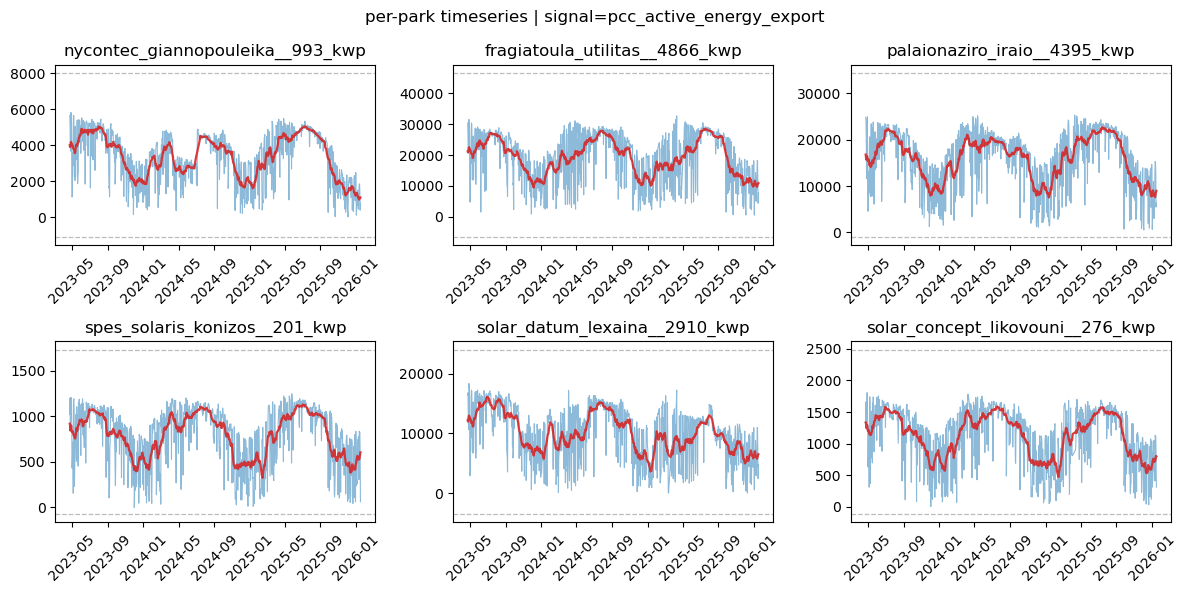

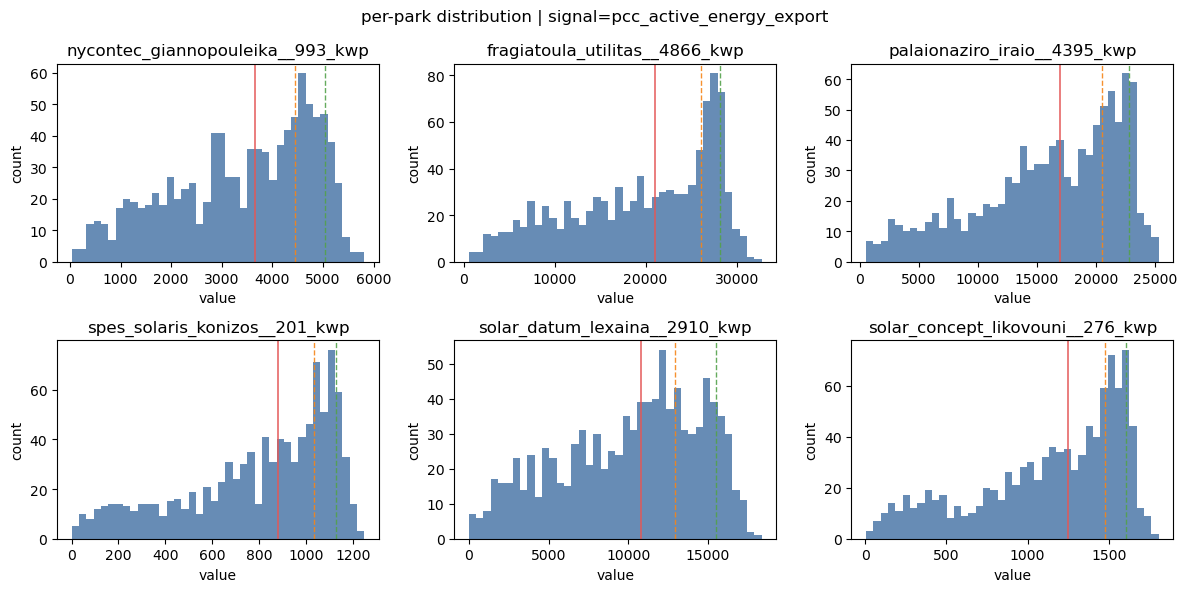

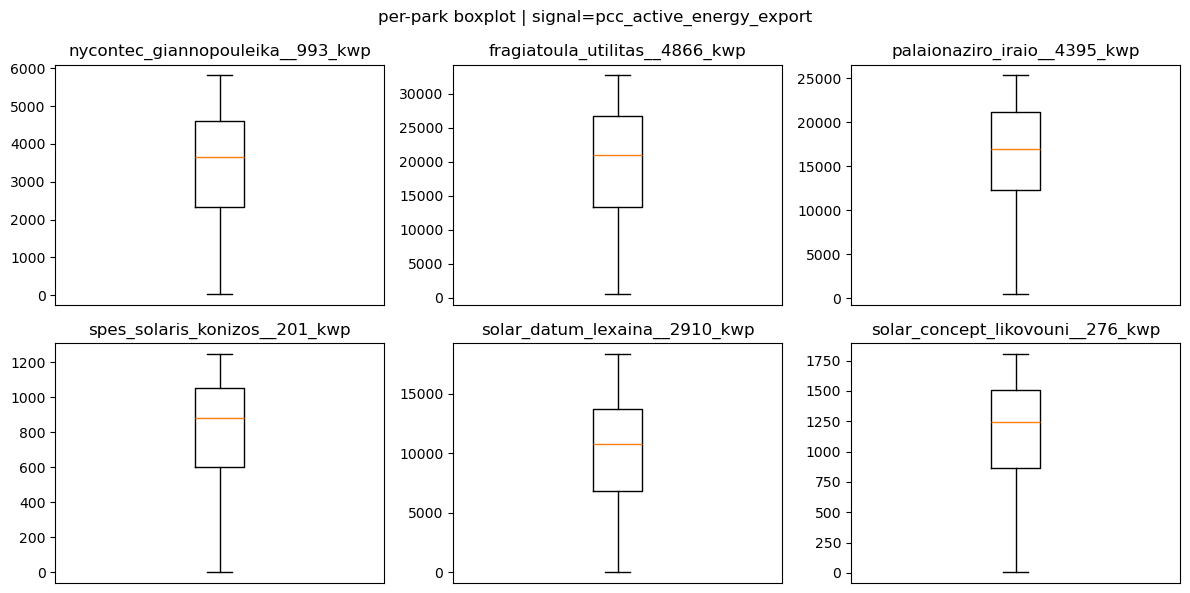

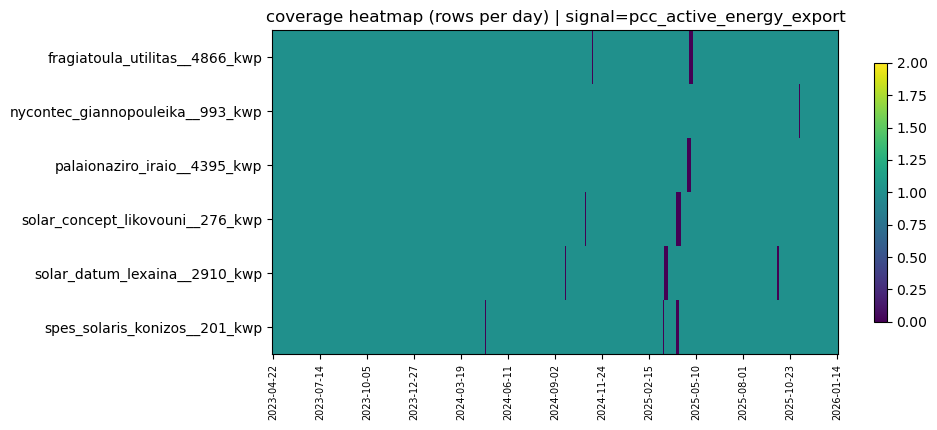

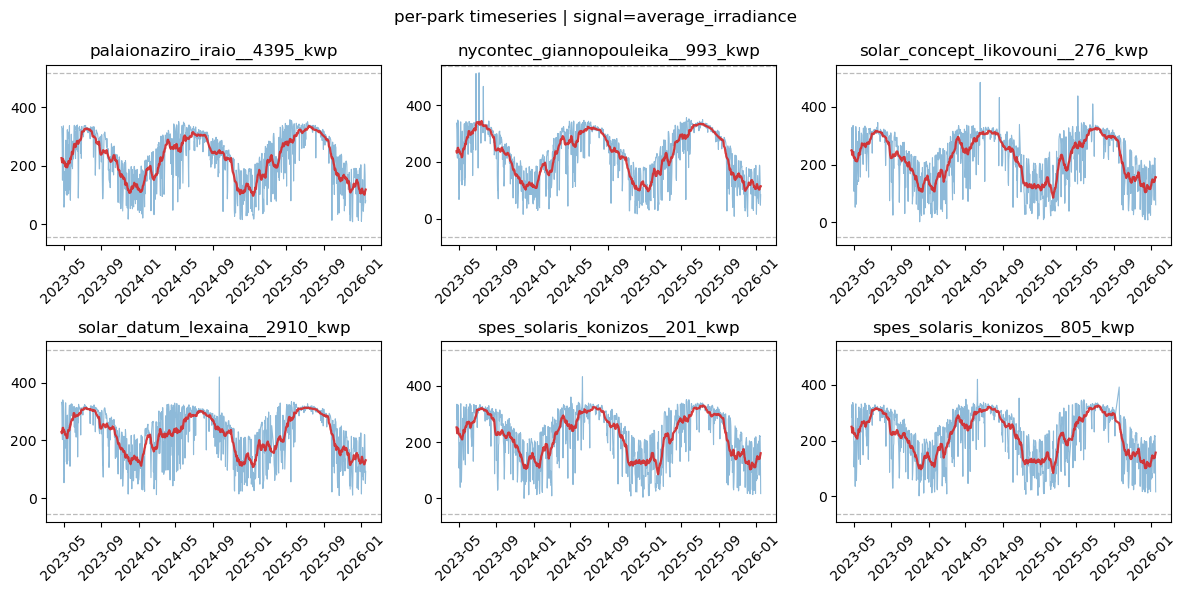

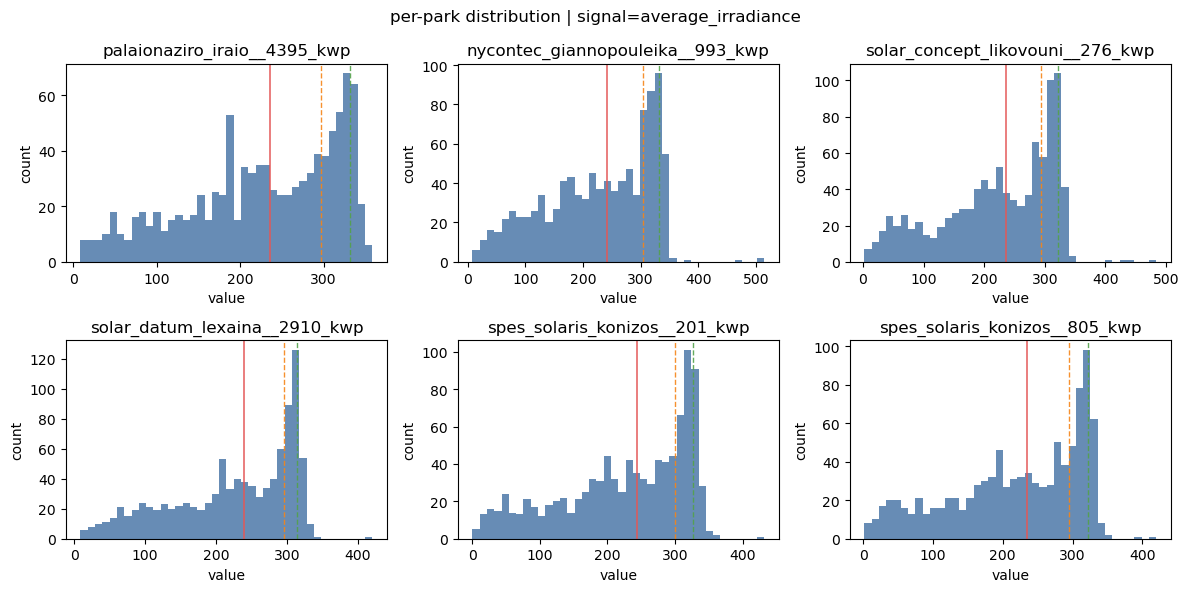

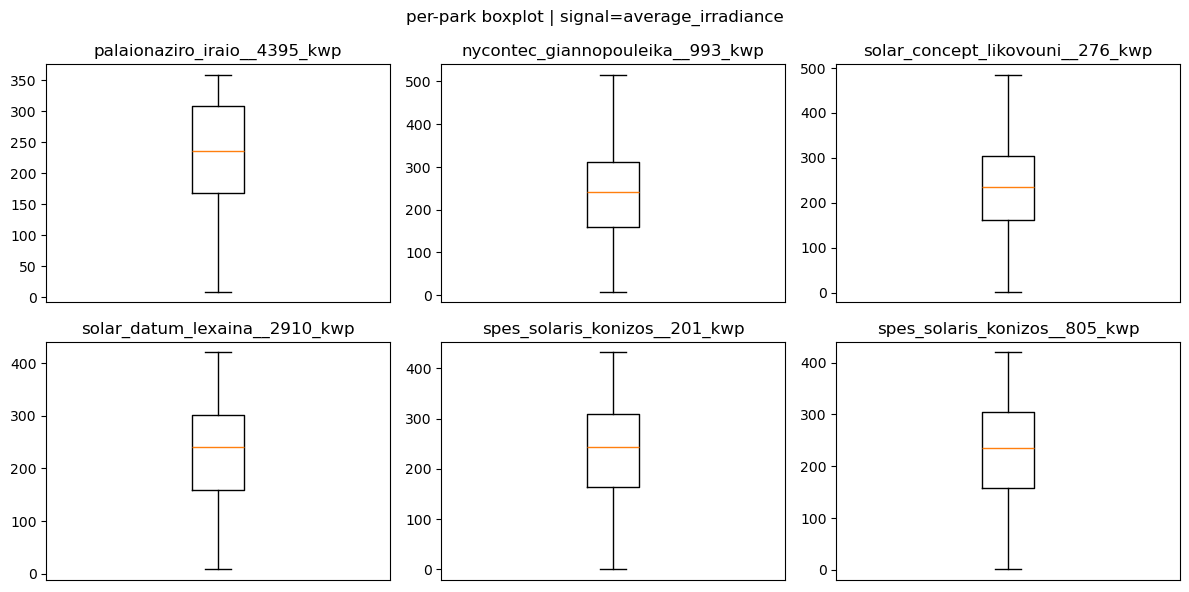

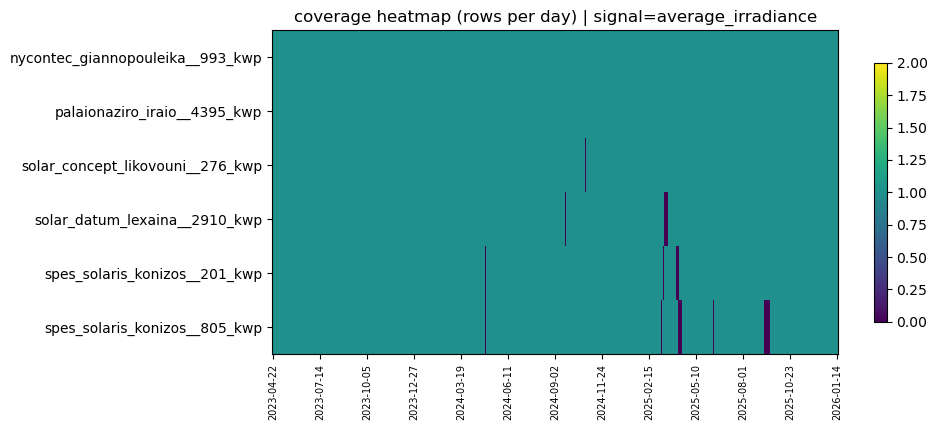

In [127]:
from pathlib import Path
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from src import silver_pre_ingestion_eda as spie
importlib.reload(spie)

stage_dir = SILVER_ROOT / "_stage"
stage_path = globals().get("stage_path")
if stage_path:
    stage_path = Path(stage_path)

if not stage_path or not stage_path.exists():
    if stage_dir.exists():
        candidates = sorted(stage_dir.glob("*.parquet"), key=lambda p: p.stat().st_mtime, reverse=True)
        stage_path = candidates[0] if candidates else None

if stage_path and Path(stage_path).exists():
    df_stage = pd.read_parquet(stage_path)
    eda_outputs = spie.run_silver_pre_ingestion_eda(
        df_stage,
        spie.EdaConfig(
            plot_kinds=["timeseries", "hist", "box", "coverage"],
            max_days=1000,  # Filter to last 50 days (applies to ALL plots/stats)
            max_parks=6,  # Show 6 parks per signal grid
            max_signals=2,  # Plot only 2 most common signals (all 4 plot types each)
            # focus_signal="pcc_acti_energy_expo",  # Uncomment to plot specific signal
            # focus_signals=["aver_irra", "pcc_acti_energy_expo"],  # Or multiple signals
        )
    )
    print(eda_outputs["overview"])
    display(eda_outputs["unit_stats"].head())
    display(eda_outputs["signal_stats"].head())
    display(eda_outputs["coverage"].head())
    for fig in eda_outputs["plots"]:
        display(fig)
        plt.close(fig)
else:
    print("No staged parquet found; run silver prep staging first.")


# Silver Enrichment: Join Park Metadata

**Description:**
Enriches silver data with park dimension metadata:
- Loads park metadata from `mappings/park_metadata.csv`
- Loads the latest staged silver file
- Performs left join on `park_id` to enrich with location, status, capacity, etc.
- Implements the Lakehouse pattern: minimal fact table + dimension join at query time

**Usage:**
Run to see how silver data can be enriched with park attributes for analysis. The enriched DataFrame includes all park metadata fields.

In [128]:
# Reload to pick up new load_park_metadata function
importlib.reload(sp)

# Load silver (minimal fact table) and park metadata (dimension)
# This is the Lakehouse pattern: join at query time

park_metadata_path = WORKSPACE_ROOT / "mappings" / "park_metadata.csv"
park_meta = sp.load_park_metadata(park_metadata_path)

# Load the latest staged silver file
stage_dir = SILVER_ROOT / "_stage"
candidates = sorted(stage_dir.glob("silver_stage_*.parquet"), key=lambda p: p.stat().st_mtime, reverse=True)
if candidates:
    silver_latest = pd.read_parquet(candidates[0])
    print(f"✓ Loaded silver: {candidates[0].name}")
    print(f"  Shape: {silver_latest.shape}")
    print(f"  Columns: {silver_latest.columns.tolist()}")
else:
    silver_latest = pd.DataFrame()
    print("No staged silver file found")

if park_meta is not None:
    print(f"\n✓ Loaded park metadata: {park_metadata_path.name}")
    print(f"  Parks: {len(park_meta)}")
    print(f"  Columns: {park_meta.columns.tolist()}")
    
    # Example: Enrich silver with park metadata
    if not silver_latest.empty and not park_meta.empty:
        silver_enriched = silver_latest.merge(park_meta, on="park_id", how="left")
        print(f"\n✓ Enriched silver shape: {silver_enriched.shape}")
        print(f"\nSample (enriched with location, capacity, status, etc.):")
        # Display available columns from enriched data
        display_cols = ["park_id", "signal_name", "value"]
        # Add metadata columns if they exist
        for col in ["capacity_kwp", "country", "status_effective", "nearest_meteo_station"]:
            if col in silver_enriched.columns:
                display_cols.append(col)
        display(silver_enriched[display_cols].head())
else:
    print(f"⚠ Park metadata not found at {park_metadata_path}")
    if not silver_latest.empty:
        silver_enriched = silver_latest

✓ Loaded silver: silver_stage_20260126T090105Z.parquet
  Shape: (162372, 18)
  Columns: ['ts_utc', 'ts_local', 'interval_start_date', 'park_id', 'park_capacity_kwp', 'signal_name', 'unit', 'value', 'source_file', 'source_file_hash', 'run_id', 'ingested_at_utc', 'ingest_key', 'prepared_at_utc', 'flag_missing_required', 'flag_invalid_value', 'flag_invalid_unit_range', 'flag_duplicate']

✓ Loaded park metadata: park_metadata.csv
  Parks: 29
  Columns: ['park_name', 'country', 'number_of_tcps', 'type_of_plant', 'altitude', 'timezone', 'grid_connected', 'plant_installer', 'longitude', 'latitude', 'plant_designer', 'plant_operator', 'type_of_project', 'installation_date', 'park_id', 'capacity_kwp', 'nearest_meteo_station', 'nearest_meteo_station_lon', 'nearest_meteo_station_lat', 'status_effective', 'notes']

✓ Enriched silver shape: (162372, 38)

Sample (enriched with location, capacity, status, etc.):


,park_id,signal_name,value,capacity_kwp,country,status_effective,nearest_meteo_station
0,fragiatoula_utilitas__4866_kwp,average_irradiance,197.592806,NaN,NaN,NaN,NaN
1,fragiatoula_utilitas__4866_kwp,pcc_active_energy_export,16931.288300,NaN,NaN,NaN,NaN
2,hliatoras_andravida__474_kwp,average_irradiance,200.806381,NaN,NaN,NaN,NaN
3,hliatoras_andravida__474_kwp,pcc_active_energy_export,1940.168710,NaN,NaN,NaN,NaN
4,nycontec_giannopouleika__993_kwp,average_irradiance,177.635888,NaN,NaN,NaN,NaN


# Silver Ingestion: Write to Persistent Layer

**Description:**
Ingests staged silver data into the persistent silver layer with quality gates:
- **Schema validation**: Checks required columns exist
- **Quality gate**: Aborts if invalid row % exceeds threshold (default 20%)
- **Deduplication**: Removes already-ingested rows by ingest_key + run_id
- **Partitioning**: Writes to `silver/year=YYYY/month=MM/` for efficient queries
- **Idempotency**: Safe to re-run (duplicates are skipped)

**Usage:**
Run after staging to commit data to the persistent silver layer. Provides detailed ingestion report with row counts and quality metrics.

In [129]:
importlib.reload(sp)

# Ingest staged silver file into persistent silver layer with quality gates
silver_root = SILVER_ROOT

if stage_path and Path(stage_path).exists():
    print(f"Ingesting silver stage: {Path(stage_path).name}")
    print(f"Destination: {silver_root}\n")
    
    ingest_result = sp.ingest_silver_stage(
        stage_path,
        silver_root,
        max_invalid_pct=20.0,  # Abort if invalid > 20%
        compression="zstd",
    )
    
    print("=" * 70)
    print("SILVER INGESTION REPORT")
    print("=" * 70)
    print(f"Status: {'✓ SUCCESS' if ingest_result['success'] else '✗ FAILED'}")
    print(f"Input rows: {ingest_result['rows_input']:,}")
    print(f"Deduped (already exists): {ingest_result['rows_deduped']:,}")
    print(f"Ingested to silver: {ingest_result['rows_ingested']:,}")
    print(f"Invalid rows %: {ingest_result['invalid_pct']:.2f}%")
    print(f"Quality gate passed: {ingest_result['quality_gate_passed']}")
    
    if ingest_result['errors']:
        print(f"\nErrors:")
        for err in ingest_result['errors']:
            print(f"  - {err}")
    
    if ingest_result['success']:
        print(f"\n✓ Silver layer updated: {silver_root}")
        print(f"  Partitioned by year/month for efficient querying")
        print(f"  Run ID lineage preserved in ingest_key column")
else:
    print("⚠ No staged silver file available for ingestion")


Ingesting silver stage: silver_stage_20260126T090105Z.parquet
Destination: C:\00_Dev\daily_avg_pv_kpi_heatmap\silver

SILVER INGESTION REPORT
Status: ✓ SUCCESS
Input rows: 162,372
Deduped (already exists): 0
Ingested to silver: 162,372
Invalid rows %: 0.00%
Quality gate passed: True

✓ Silver layer updated: C:\00_Dev\daily_avg_pv_kpi_heatmap\silver
  Partitioned by year/month for efficient querying
  Run ID lineage preserved in ingest_key column


In [145]:
# PVGIS typical-year expected production (no saving; inline plots - timeseries only)
import importlib
from IPython.display import display
from src import pvgis_data_ingestion as pr_est
from src.silver_prepair import load_park_metadata

importlib.reload(pr_est)

cfg = pr_est.TypicalYearConfig(
    workspace_root=WORKSPACE_ROOT,
    metadata_path=WORKSPACE_ROOT / "mappings" / "park_metadata.csv",
    cache_root=WORKSPACE_ROOT / "pvgis" / "pvgis_cache",
    output_dir=WORKSPACE_ROOT / "pvgis" / "pvgis_typical_year",
    eda_output_dir=WORKSPACE_ROOT / "plots" / "pvgis_typical_year_eda",
    use_cache=True,
    save_cache=True,
    save_output=True,
    start_year=2015,
    end_year=2023,
    loss_pct=18.0,
    default_capacity_kwp=100.0,
    default_timezone="Europe/Athens",
    reference_year=2001,
    drop_feb29=True,
    run_eda_on_new=True,
    save_eda_plots=False,
    save_eda_stats=False,
    show_eda_plots=False,
)

# Check if data are already downloaded for all parks
park_meta = load_park_metadata(cfg.metadata_path)
daily_cache_dir = cfg.cache_root / "typical_daily"
cached_parks = set()

if daily_cache_dir.exists():
    for cache_file in daily_cache_dir.glob("pvgis_typical_daily_*.parquet"):
        # Extract park_id from filename (format: pvgis_typical_daily_<park_id>_<hash>.parquet)
        parts = cache_file.stem.split("_")
        if len(parts) >= 4:
            # park_id is everything between "daily" and the last part (hash)
            park_id = "_".join(parts[3:-1])
            cached_parks.add(park_id)

expected_parks = set(park_meta["park_id"].astype(str).str.lower())
if cached_parks and cached_parks == expected_parks:
    print(f"✓ Data already downloaded for all {len(cached_parks)} parks. Skipping PVGIS download.")
    print(f"  Cached parks: {sorted(cached_parks)[:5]}{'...' if len(cached_parks) > 5 else ''}")
    pvgis_typical_outputs = {"message": "Using cached data", "parks": len(cached_parks)}
else:
    print(f"Downloading PVGIS data for {len(expected_parks)} parks...")
    print(f"  Already cached: {len(cached_parks)}, Missing: {len(expected_parks - cached_parks)}")
    pvgis_typical_outputs = pr_est.build_pvgis_typical_year_dataset(cfg)

eda_outputs = pvgis_typical_outputs.get("eda_outputs")
if eda_outputs:
    print(eda_outputs.get("overview"))
    # Display only timeseries plots
    all_plots = eda_outputs.get("plots", [])
    timeseries_plots = [fig for fig in all_plots if hasattr(fig, 'get_axes') and any(
        'timeseries' in str(ax.get_title()).lower() or 'daily' in str(ax.get_title()).lower() 
        for ax in fig.get_axes()
    )]
    
    if timeseries_plots:
        print(f"\n📊 Displaying {len(timeseries_plots)} timeseries plot(s):")
        for fig in timeseries_plots:
            display(fig)
    else:
        # Fallback: if no timeseries plots found by title, display all plots with info
        print(f"ℹ️ {len(all_plots)} plot(s) available (filtering by timeseries keyword)")

data_df = pvgis_typical_outputs.get("dataframe")
if data_df is not None:
    display(data_df.head())


✓ Data already downloaded for all 29 parks. Skipping PVGIS download.
  Cached parks: ['4e_energeiaki_176_kwp_likovouni', '4e_energeiaki_4472_kwp_lexaina', '4e_energeiaki_805_kwp_darali', 'fragiatoula_utilitas_4866kwp', 'hlektrogenesis_391_kwp_pelopio']...


In [169]:
# Load silver data into wide format (ts_local index)
import pandas as pd
from pathlib import Path
from src import silver_prepair as sp


def _normalize_values(values):
    if values is None:
        return None
    return {str(v).strip().lower() for v in values if str(v).strip()}


def _normalize_status(value):
    if value is None:
        return None
    if isinstance(value, (list, tuple, set)):
        return {str(v).strip().lower() for v in value if str(v).strip()}
    if isinstance(value, bool):
        return {"true"} if value else {"false"}
    return {str(value).strip().lower()}


def _iter_silver_parts(silver_root, start_date=None, end_date=None):
    root = Path(silver_root)
    if start_date is None and end_date is None:
        return sorted(root.glob("year=*/month=*/part-*.parquet"))

    start = pd.to_datetime(start_date) if start_date else None
    end = pd.to_datetime(end_date) if end_date else None
    if start is None and end is not None:
        start = end
    if start is not None and end is None:
        end = pd.Timestamp.utcnow().tz_localize(None)
    if start is None or end is None:
        return sorted(root.glob("year=*/month=*/part-*.parquet"))
    if start > end:
        start, end = end, start

    months = pd.period_range(start=start, end=end, freq="M")
    files = []
    for period in months:
        part_dir = root / f"year={period.year}" / f"month={period.month}"
        if part_dir.exists():
            files.extend(part_dir.glob("part-*.parquet"))
    return sorted(files)


def _read_parquet_columns(path, columns):
    try:
        return pd.read_parquet(path, columns=columns)
    except Exception:
        return pd.read_parquet(path)


def _align_timestamp(ts, series):
    if ts is None:
        return None
    ts = pd.to_datetime(ts)
    series_tz = series.dt.tz
    if series_tz is None:
        if ts.tzinfo is not None:
            return ts.tz_convert(None)
        return ts
    if ts.tzinfo is None:
        return ts.tz_localize(series_tz)
    return ts.tz_convert(series_tz)


def _replace_year_safe(ts, ref_year):
    if ts is None:
        return None
    ts = pd.to_datetime(ts)
    try:
        return ts.replace(year=int(ref_year))
    except ValueError:
        if ts.month == 2 and ts.day == 29:
            return ts.replace(year=int(ref_year), day=28)
        raise


def load_silver_wide(
    silver_root,
    metadata_path,
    park_ids=None,
    signals=None,
    start_date=None,
    end_date=None,
    status_effective=None,
    only_valid=True,
    flatten_columns=False,
    debug=False,
):
    park_set = _normalize_values(park_ids)
    signal_set = _normalize_values(signals)
    status_set = _normalize_status(status_effective)

    part_files = _iter_silver_parts(silver_root, start_date=start_date, end_date=end_date)
    if debug:
        print(f"[load_silver_wide] part files: {len(part_files)}")
    if not part_files:
        return pd.DataFrame()

    base_cols = ["ts_local", "ts_utc", "park_id", "signal_name", "unit", "value"]
    flag_cols = ["flag_missing_required", "flag_invalid_value", "flag_invalid_unit_range", "flag_duplicate"]
    use_cols = base_cols + flag_cols

    frames = [_read_parquet_columns(p, use_cols) for p in part_files]
    df = pd.concat(frames, ignore_index=True)
    if debug:
        print(f"[load_silver_wide] rows loaded: {len(df)}")
    if df.empty:
        return df

    if "park_id" in df.columns:
        df["park_id"] = df["park_id"].astype("string").str.strip().str.lower()
    if "signal_name" in df.columns:
        df["signal_name"] = df["signal_name"].astype("string").str.strip().str.lower()

    if debug:
        park_sample = df["park_id"].dropna().unique().tolist()[:5]
        signal_sample = df["signal_name"].dropna().unique().tolist()[:5]
        print(f"[load_silver_wide] sample park_ids: {park_sample}")
        print(f"[load_silver_wide] sample signals: {signal_sample}")

    if status_set is not None:
        meta = sp.load_park_metadata(Path(metadata_path))
        if meta is None or "status_effective" not in meta.columns:
            raise ValueError("status_effective filter requested but metadata missing status_effective")
        status_series = meta["status_effective"].astype("string").str.strip().str.lower()
        allowed_parks = set(meta.loc[status_series.isin(status_set), "park_id"].astype(str))
        if debug:
            intersection = set(df["park_id"].dropna()) & allowed_parks
            print(f"[load_silver_wide] status_effective parks: {len(allowed_parks)}")
            print(f"[load_silver_wide] status_effective intersection: {len(intersection)}")
        if park_set:
            allowed_parks = allowed_parks.intersection(park_set)
        df = df[df["park_id"].isin(allowed_parks)]
        if debug:
            print(f"[load_silver_wide] rows after status_effective: {len(df)}")

    if park_set is not None:
        df = df[df["park_id"].isin(park_set)]
        if debug:
            print(f"[load_silver_wide] rows after park filter: {len(df)}")

    if signal_set is not None:
        df = df[df["signal_name"].isin(signal_set)]
        if debug:
            print(f"[load_silver_wide] rows after signal filter: {len(df)}")

    time_col = "ts_local" if "ts_local" in df.columns else "ts_utc"
    if time_col == "ts_local":
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
        if df[time_col].isna().all() and "ts_utc" in df.columns:
            time_col = "ts_utc"
    if time_col == "ts_utc":
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce", utc=True)

    start_ts = _align_timestamp(start_date, df[time_col]) if start_date is not None else None
    end_ts = _align_timestamp(end_date, df[time_col]) if end_date is not None else None
    if start_ts is not None:
        df = df[df[time_col] >= start_ts]
        if debug:
            print(f"[load_silver_wide] rows after start_date: {len(df)}")
    if end_ts is not None:
        df = df[df[time_col] <= end_ts]
        if debug:
            print(f"[load_silver_wide] rows after end_date: {len(df)}")

    if only_valid:
        if "value" in df.columns:
            df = df[df["value"].notna()]
        flag_cols = [c for c in df.columns if c.startswith("flag_")]
        if flag_cols:
            df = df[~df[flag_cols].fillna(False).any(axis=1)]
        if debug:
            print(f"[load_silver_wide] rows after validity filter: {len(df)}")

    if df.empty:
        return df

    col_keys = ["park_id", "signal_name"]
    if "unit" in df.columns:
        col_keys.append("unit")

    wide = df.pivot_table(
        index=time_col,
        columns=col_keys,
        values="value",
        aggfunc="mean",
    ).sort_index()

    if flatten_columns and isinstance(wide.columns, pd.MultiIndex):
        wide.columns = ["__".join([str(x) for x in col]) for col in wide.columns]

    if debug:
        print(f"[load_silver_wide] wide shape: {wide.shape}")
    return wide


def _resolve_pvgis_files(pvgis_path=None, cache_dir=None, workspace_root=None):
    candidates = []
    if workspace_root:
        root = Path(workspace_root)
        candidates.append(root / "outputs" / "pvgis_typical_year" / "pvgis_typical_daily.parquet")
        candidates.append(root / "pvgis" / "pvgis_cache" / "typical_daily")

    if pvgis_path:
        candidates.append(Path(pvgis_path))
    if cache_dir:
        candidates.append(Path(cache_dir))

    candidates.append(Path("outputs") / "pvgis_typical_year" / "pvgis_typical_daily.parquet")
    candidates.append(Path("pvgis") / "pvgis_cache" / "typical_daily")

    files = []
    for item in candidates:
        if item.is_dir():
            files.extend(sorted(item.glob("*.parquet")))
        elif item.exists():
            files.append(item)

    return files


def load_pvgis_typical_wide(
    pvgis_path=None,
    cache_dir=None,
    workspace_root=None,
    park_ids=None,
    signals=None,
    start_date=None,
    end_date=None,
    flatten_columns=False,
    local_timezone=None,
    debug=False,
):
    park_set = _normalize_values(park_ids)
    signal_set = _normalize_values(signals)

    files = _resolve_pvgis_files(pvgis_path, cache_dir, workspace_root)
    if debug:
        print(f"[load_pvgis_typical_wide] files: {len(files)}")
    if not files:
        return pd.DataFrame()

    cols = ["interval_start_date", "ts_utc", "park_id", "park_name", "signal_name", "unit", "value", "timezone"]
    frames = [_read_parquet_columns(p, cols) for p in files]
    df = pd.concat(frames, ignore_index=True)
    if debug:
        print(f"[load_pvgis_typical_wide] rows loaded: {len(df)}")
    if df.empty:
        return df

    df["park_id"] = df["park_id"].astype("string").str.strip().str.lower()
    df["signal_name"] = df["signal_name"].astype("string").str.strip().str.lower()

    if park_set is not None:
        df = df[df["park_id"].isin(park_set)]
        if debug:
            print(f"[load_pvgis_typical_wide] rows after park filter: {len(df)}")

    if signal_set is not None:
        df = df[df["signal_name"].isin(signal_set)]
        if debug:
            print(f"[load_pvgis_typical_wide] rows after signal filter: {len(df)}")

    df["ts_local"] = pd.to_datetime(df.get("interval_start_date"), errors="coerce")
    if local_timezone:
        df["ts_local"] = df["ts_local"].dt.tz_localize(local_timezone)
    elif "timezone" in df.columns:
        tz_vals = df["timezone"].dropna().unique().tolist()
        if len(tz_vals) == 1:
            df["ts_local"] = df["ts_local"].dt.tz_localize(tz_vals[0])

    if start_date is not None and end_date is None:
        end_date = pd.Timestamp.utcnow().tz_localize(None)

    ref_year = None
    if df["ts_local"].notna().any():
        years = df["ts_local"].dt.year.dropna().unique()
        if len(years) == 1:
            ref_year = int(years[0])
    if ref_year is not None:
        start_date = _replace_year_safe(start_date, ref_year) if start_date is not None else None
        end_date = _replace_year_safe(end_date, ref_year) if end_date is not None else None
        if debug:
            print(f"[load_pvgis_typical_wide] ref_year: {ref_year}")

    start_ts = _align_timestamp(start_date, df["ts_local"]) if start_date is not None else None
    end_ts = _align_timestamp(end_date, df["ts_local"]) if end_date is not None else None
    if start_ts is not None:
        df = df[df["ts_local"] >= start_ts]
        if debug:
            print(f"[load_pvgis_typical_wide] rows after start_date: {len(df)}")
    if end_ts is not None:
        df = df[df["ts_local"] <= end_ts]
        if debug:
            print(f"[load_pvgis_typical_wide] rows after end_date: {len(df)}")

    if df.empty:
        return df

    col_keys = ["park_id", "signal_name"]
    if "unit" in df.columns:
        col_keys.append("unit")

    wide = df.pivot_table(
        index="ts_local",
        columns=col_keys,
        values="value",
        aggfunc="mean",
    ).sort_index()

    if flatten_columns and isinstance(wide.columns, pd.MultiIndex):
        wide.columns = ["__".join([str(x) for x in col]) for col in wide.columns]

    if debug:
        print(f"[load_pvgis_typical_wide] wide shape: {wide.shape}")
    return wide


def calculate_power_ratio_percent(
    measured_wide,
    expected_wide,
    join_type="left",
    min_expected_kwh=None,
    output_range=None,
    match_by_calendar_day=True,
    debug=True,
):
    """
    Calculate power ratio percentage: (measured / expected) * 100.
    
    Matches parks by extracting park_id from column names (before first __ separator).
    For typical year data (PVGIS): matches by calendar day (month/day).
    """
    import numpy as np
    import re
    
    if measured_wide is None or expected_wide is None or measured_wide.empty or expected_wide.empty:
        if debug:
            print("[calculate_power_ratio_percent] Invalid inputs")
        return pd.DataFrame()
    
    left = measured_wide.copy()
    right = expected_wide.copy()
    
    if debug:
        print(f"[calculate_power_ratio_percent] Input: left={left.shape}, right={right.shape}")
    
    # Normalize park ID by removing capacity suffix and prefixes
    def normalize_park_id(park_id):
        park_id = str(park_id).lower().strip()
        # Remove leading 'p_' prefix
        park_id = re.sub(r'^p_', '', park_id)
        # Remove capacity patterns like _123_kwp or _123kwp anywhere in the string
        # This handles cases like "name_capacity_kwp_location" -> "name_location"
        park_id = re.sub(r'_\d+_?kwp', '', park_id)
        return park_id
    
    # Extract park IDs from column names (format: tuple or "park_id__signal__unit")
    def extract_park_ids(df):
        parks = {}
        for col in df.columns:
            if isinstance(col, tuple):
                park_raw = str(col[0]).split("__")[0]
            else:
                park_raw = str(col).split("__")[0]
            
            park_id = normalize_park_id(park_raw)
            if park_id not in parks:
                parks[park_id] = []
            parks[park_id].append(col)
        return parks
    
    left_parks = extract_park_ids(left)
    right_parks = extract_park_ids(right)
    common_parks = set(left_parks.keys()) & set(right_parks.keys())
    
    if debug:
        print(f"  Left parks: {len(left_parks)}, Right parks: {len(right_parks)}, Common: {len(common_parks)}")
    
    if len(common_parks) == 0:
        return pd.DataFrame()
    
    # Match columns: prefer pcc_active_energy_export for measured, pvgis_expected for expected
    left_cols = []
    right_cols = []
    
    for park in sorted(common_parks):
        left_candidates = left_parks[park]
        right_candidates = right_parks[park]
        
        left_energy = [c for c in left_candidates if "pcc_active" in str(c).lower()]
        if not left_energy:
            left_energy = [c for c in left_candidates if "energy" in str(c).lower() and "irradiance" not in str(c).lower()]
        
        right_energy = [c for c in right_candidates if "pvgis" in str(c).lower() and ("expected" in str(c).lower() or "kwh" in str(c).lower())]
        
        if debug:
            print(f"    Park '{park}': left candidates={len(left_candidates)}, right candidates={len(right_candidates)}")
            print(f"      Left energy matches: {len(left_energy)}")
            print(f"      Right energy matches: {len(right_energy)}")
        
        if left_energy and right_energy:
            left_cols.append(left_energy[0])
            right_cols.append(right_energy[0])
            if debug:
                print(f"      ✓ Matched: {left_energy[0]} <-> {right_energy[0]}")
    
    if debug:
        print(f"  Matched columns: {len(left_cols)}")
    
    if len(left_cols) == 0:
        return pd.DataFrame()
    
    left = left[left_cols].copy()
    right = right[right_cols].copy()
    right.columns = left.columns  # Rename to match
    
    # Align by calendar day if typical year
    if match_by_calendar_day and isinstance(right.index, pd.DatetimeIndex):
        right_years = right.index.year.unique()
        if len(right_years) == 1:
            if debug:
                print(f"  Typical year detected, matching by calendar day...")
            
            left_mday = left.index.strftime("%m-%d")
            right_mday = right.index.strftime("%m-%d")
            
            right_aligned = pd.DataFrame(index=left.index, columns=right.columns, dtype=float)
            for col in right.columns:
                s = right[col].copy()
                s.index = right_mday
                s = s.groupby(level=0).mean()
                right_aligned[col] = s.reindex(left_mday, method='ffill').values
            right = right_aligned
    
    # Final alignment
    left, right = left.align(right, join=join_type, axis=0)
    
    if min_expected_kwh is not None:
        right = right.where(right >= min_expected_kwh, other=np.nan)
    
    ratio = (left / right) * 100.0
    ratio = ratio.replace([np.inf, -np.inf], np.nan)
    
    if output_range:
        ratio = ratio.clip(lower=output_range[0], upper=output_range[1])
    else:
        ratio = ratio.where((ratio >= 0) & (ratio <= 300), other=np.nan)
    
    if debug:
        print(f"  Output: {ratio.shape}, non-null: {ratio.notna().sum().sum() / (ratio.shape[0] * ratio.shape[1] or 1) * 100:.1f}%")
    
    return ratio

In [142]:
wide = load_silver_wide(
    silver_root=WORKSPACE_ROOT / "silver",
    metadata_path=WORKSPACE_ROOT / "mappings" / "park_metadata.csv",
    start_date="2023-01-01",
    # end_date="2025-03-31",
    signals=["pcc_active_energy_export"],
    status_effective=None,
    only_valid=False,
    flatten_columns=False,
    debug=True,
)

[load_silver_wide] part files: 37
[load_silver_wide] rows loaded: 41745
[load_silver_wide] sample park_ids: ['fragiatoula_utilitas__4866_kwp', 'hliatoras_andravida__474_kwp', 'ntarali_bonitas__450_kwp', 'ntarali_concept__296_kwp', 'ntarali_concept__320_kwp']
[load_silver_wide] sample signals: ['average_irradiance', 'pcc_active_energy_export']
[load_silver_wide] rows after signal filter: 21070
[load_silver_wide] rows after start_date: 21070
[load_silver_wide] wide shape: (1112, 22)


In [149]:
pvgis_wide = load_pvgis_typical_wide(
    workspace_root=WORKSPACE_ROOT,
    flatten_columns=False,
    debug=True,
)

[load_pvgis_typical_wide] files: 29
[load_pvgis_typical_wide] rows loaded: 10585
[load_pvgis_typical_wide] ref_year: 2001
[load_pvgis_typical_wide] wide shape: (365, 29)


In [170]:
# First, let's analyze what parks we have in each dataset
import re

def normalize_park_id(park_id):
    """Normalize park ID by removing capacity suffix and prefixes"""
    park_id = str(park_id).lower().strip()
    # Remove leading 'p_' prefix
    park_id = re.sub(r'^p_', '', park_id)
    # Remove capacity patterns like _123_kwp, _123kwp at the end
    park_id = re.sub(r'_\d+_?kwp$', '', park_id)
    return park_id

# Extract park IDs from silver data
silver_parks_raw = set()
for col in wide.columns:
    if isinstance(col, tuple):
        park_raw = str(col[0]).split("__")[0]
    else:
        park_raw = str(col).split("__")[0]
    silver_parks_raw.add(park_raw)

# Extract park IDs from PVGIS data
pvgis_parks_raw = set()
for col in pvgis_wide.columns:
    if isinstance(col, tuple):
        park_raw = str(col[0])
    else:
        park_raw = str(col).split("__")[0]
    pvgis_parks_raw.add(park_raw)

print(f"Silver has {len(silver_parks_raw)} parks, PVGIS has {len(pvgis_parks_raw)} parks")

# Normalize
silver_norm = {normalize_park_id(p): p for p in silver_parks_raw}
pvgis_norm = {normalize_park_id(p): p for p in pvgis_parks_raw}

common_norm = set(silver_norm.keys()) & set(pvgis_norm.keys())
silver_only = set(silver_norm.keys()) - set(pvgis_norm.keys())
pvgis_only = set(pvgis_norm.keys()) - set(silver_norm.keys())

print(f"\nAfter normalization:")
print(f"  Common parks: {len(common_norm)}")
print(f"  Silver only: {len(silver_only)}")
print(f"  PVGIS only: {len(pvgis_only)}")

if silver_only:
    print(f"\nParks in Silver but not in PVGIS (first 10):")
    for p in sorted(silver_only)[:10]:
        print(f"  {p:40} (raw: {silver_norm[p]})")

if pvgis_only:
    print(f"\nParks in PVGIS but not in Silver (first 10):")
    for p in sorted(pvgis_only)[:10]:
        print(f"  {p:40} (raw: {pvgis_norm[p]})")

print(f"\nCommon parks:")
for p in sorted(common_norm):
    print(f"  {p:40} Silver: {silver_norm[p]:50} PVGIS: {pvgis_norm[p]}")

print("\n" + "="*80)
print("Now calculating power ratio...")
print("="*80)

power_ratio_pct = calculate_power_ratio_percent(
    measured_wide=wide, 
    expected_wide=pvgis_wide,
    debug=True,
)

if not power_ratio_pct.empty:
    print(f"\n✓ Power ratio calculated successfully")
    print(f"  Shape: {power_ratio_pct.shape}")
    print(f"  Parks: {len(power_ratio_pct.columns)}")
    print(f"  Date range: {power_ratio_pct.index.min()} to {power_ratio_pct.index.max()}")
else:
    print("\n⚠️ Power ratio is empty")

Silver has 19 parks, PVGIS has 29 parks

After normalization:
  Common parks: 2
  Silver only: 17
  PVGIS only: 26

Parks in Silver but not in PVGIS (first 10):
  4e_energeiaki_darali                     (raw: p_4e_energeiaki_darali)
  4e_energeiaki_lexaina                    (raw: p_4e_energeiaki_lexaina)
  4e_energeiaki_likovouni                  (raw: p_4e_energeiaki_likovouni)
  hliatoras_andravida                      (raw: hliatoras_andravida)
  ntarali_bonitas                          (raw: ntarali_bonitas)
  ntarali_concept                          (raw: ntarali_concept)
  ntarali_konenergy                        (raw: ntarali_konenergy)
  nycontec_giannopouleika                  (raw: nycontec_giannopouleika)
  solar_concept_lexaina                    (raw: solar_concept_lexaina)
  solar_concept_likovouni                  (raw: solar_concept_likovouni)

Parks in PVGIS but not in Silver (first 10):
  4e_energeiaki_176_kwp_likovouni          (raw: 4e_energeiaki_176_kwp_likovouni

In [192]:
def plot_heatmap(
    mat: pd.DataFrame,
    title: str,
    vmin=None,
    vmax=None,
    start_date=None,
    end_date=None,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Plot a heatmap of date x park data.
    """
    # Filter by date range if specified
    if start_date is not None or end_date is not None:
        tz = mat.index.tz if isinstance(mat.index, pd.DatetimeIndex) else None
        if start_date is not None:
            start_date = pd.to_datetime(start_date)
            if tz and start_date.tzinfo is None:
                start_date = start_date.tz_localize(tz)
            if tz is None and start_date.tzinfo is not None:
                start_date = start_date.tz_convert(None)
            mat = mat[mat.index >= start_date]
        if end_date is not None:
            end_date = pd.to_datetime(end_date)
            if tz and end_date.tzinfo is None:
                end_date = end_date.tz_localize(tz)
            if tz is None and end_date.tzinfo is not None:
                end_date = end_date.tz_convert(None)
            mat = mat[mat.index <= end_date]
        if len(mat) == 0:
            print("Warning: No data found in the specified date range")
            return None

    m = mat.T.copy()
    y = []
    for col in m.index:
        if isinstance(col, tuple):
            park_id = col[0]
            if "__" in park_id:
                parts = park_id.split("__")
                park_name = parts[0].replace("p_", "").replace("_", " ").title()
                if len(parts) > 1 and "kwp" in parts[1].lower():
                    capacity = parts[1].replace("_kwp", "").replace("kwp", "")
                    y.append(f"{park_name} ({capacity} kWp)")
                else:
                    y.append(park_name)
            else:
                y.append(park_id.replace("_", " ").title())
        else:
            try:
                y.append(f"{str(col)} ({parse_kwp_from_header(col):.0f} kWp)")
            except Exception:
                y.append(str(col))
    m.index = y

    fig, ax = plt.subplots(figsize=(14, max(6, 0.28 * len(m.index))))
    im = ax.imshow(m.values, aspect="auto", interpolation="nearest", cmap="turbo", vmin=vmin, vmax=vmax)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_yticks(np.arange(len(m.index)))
    ax.set_yticklabels(m.index, fontsize=10)

    dates = pd.to_datetime(m.columns)
    step = max(1, len(dates) // 12)
    xticks = np.arange(0, len(dates), step)
    ax.set_xticks(xticks)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates[::step]], rotation=45, ha="right")

    ax.grid(False)

    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
    cbar.ax.set_ylabel("KPI", rotation=90, fontsize=10)
    plt.tight_layout()

    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )

    plt.show()
    return saved_path

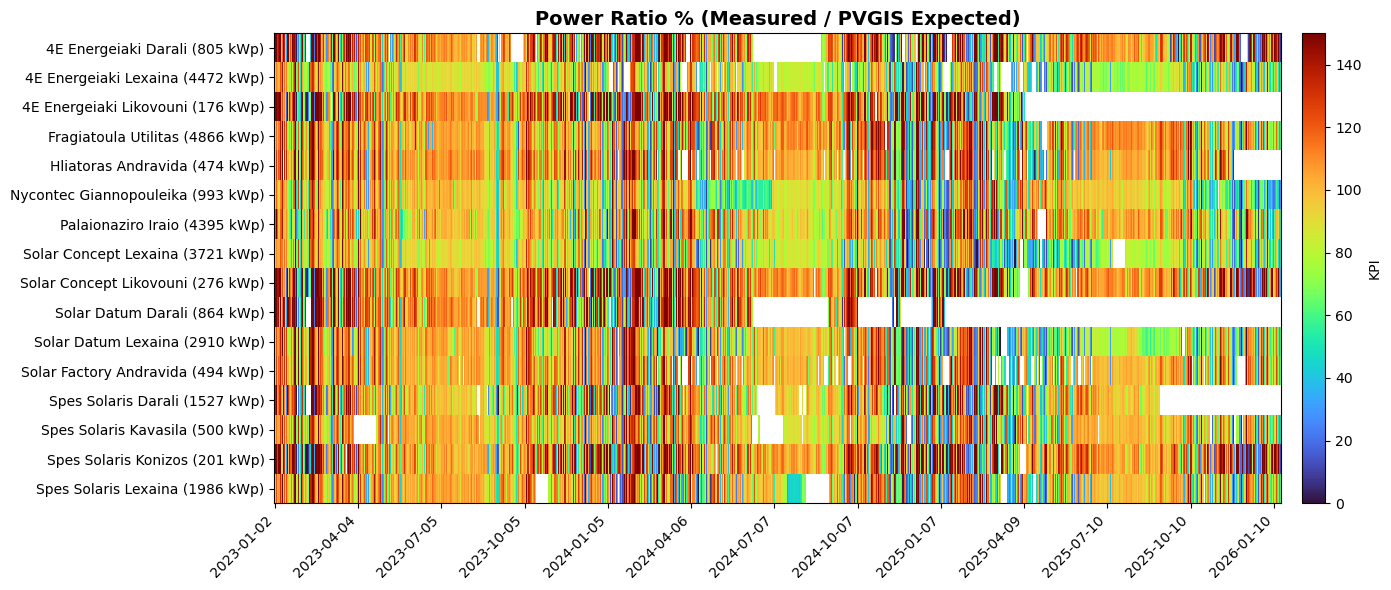

WindowsPath('C:/00_Dev/daily_avg_pv_kpi_heatmap/plots/weekly_analysis/heatmap_power_ratio_pct.png')

In [187]:
# Plot power ratio heatmap
plot_heatmap(
    power_ratio_pct, 
    "Power Ratio % (Measured / PVGIS Expected)", 
    vmin=0, 
    vmax=150,
    save=True,
    save_dir=PLOTS_DIR / "weekly_analysis",
    base_filename="heatmap_power_ratio_pct",
    dpi=180,
    fmt="png"
)

In [189]:
# Prepare data for downstream plots
# Use silver-wide as daily_historical (time index already aligned)
daily_historical = wide.copy()
pi = power_ratio_pct.copy()

# Robust anomaly score per park (median/MAD z-score)
def _robust_score(series: pd.Series) -> pd.Series:
    med = series.median()
    mad = (series - med).abs().median()
    if mad == 0 or pd.isna(mad):
        return pd.Series(index=series.index, dtype=float)
    return (series - med) / (mad * 1.4826)

score = pi.apply(_robust_score, axis=0)

# Simple flag: -1 under (score < -1.5), 0 neutral, +1 over (score > +1.5)
flag = score.copy()
flag = flag.mask(score > 1.5, 1)
flag = flag.mask(score < -1.5, -1)
flag = flag.fillna(0)

print(f"daily_historical shape: {daily_historical.shape}")
print(f"pi (power_ratio_pct) shape: {pi.shape}")
print(f"score shape: {score.shape}")
print(f"flag shape: {flag.shape}")

daily_historical shape: (1112, 22)
pi (power_ratio_pct) shape: (1112, 16)
score shape: (1112, 16)
flag shape: (1112, 16)


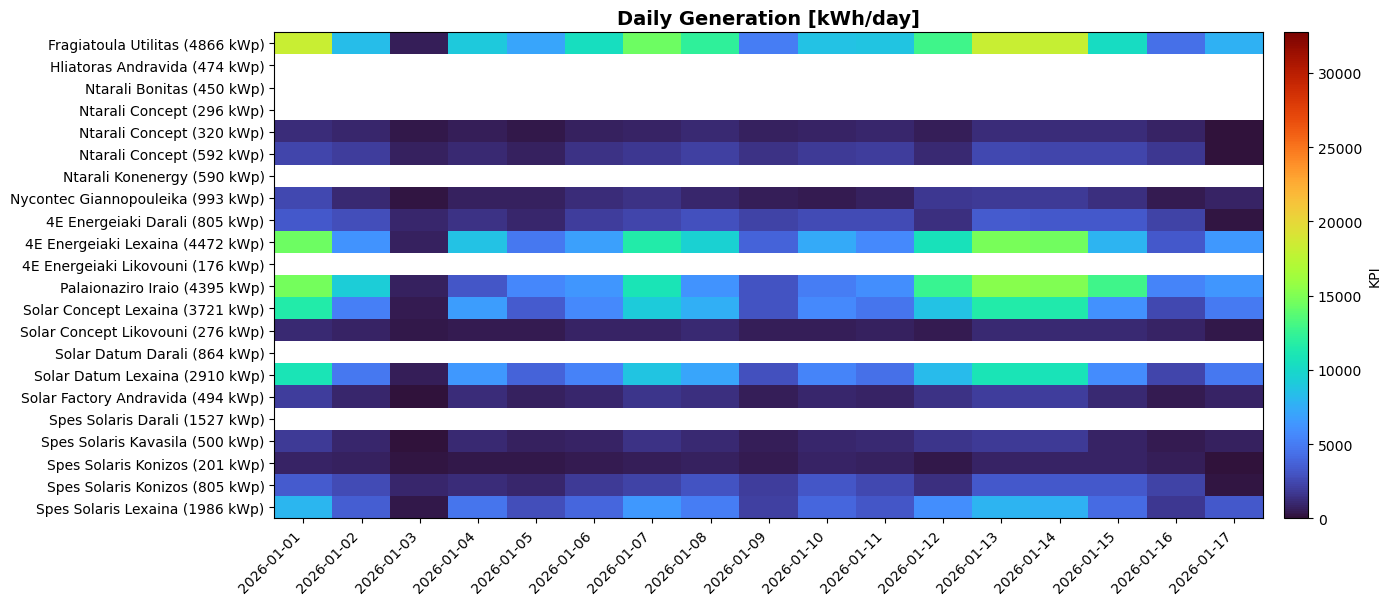

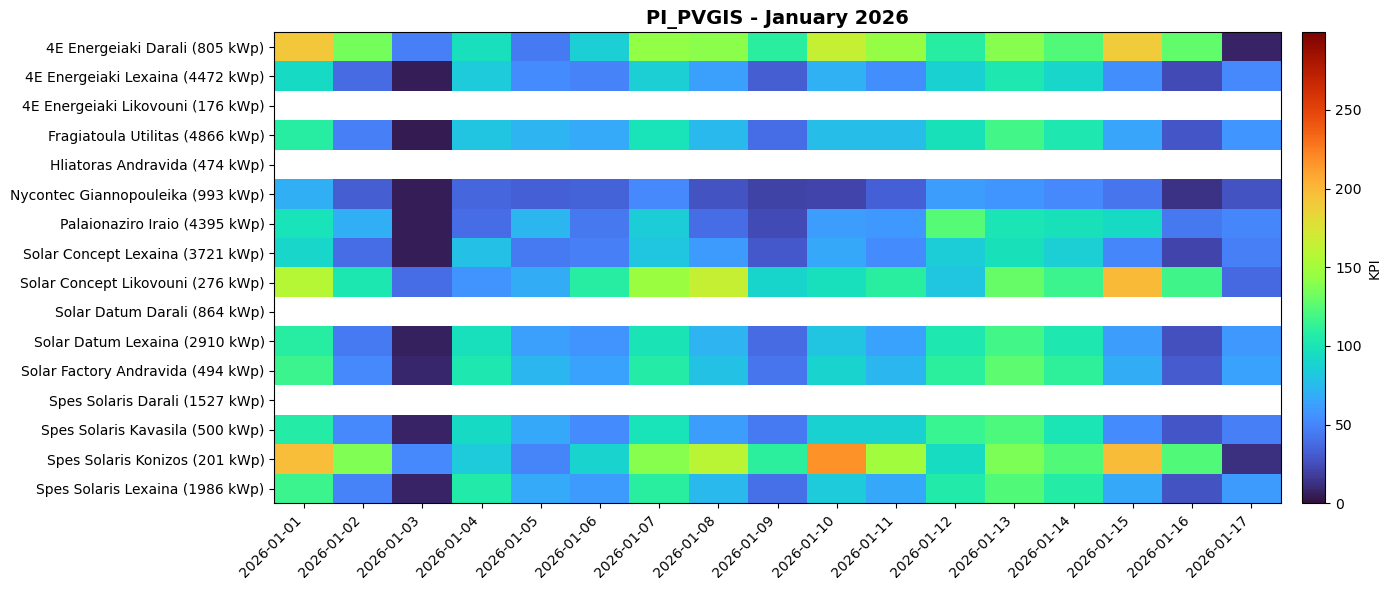

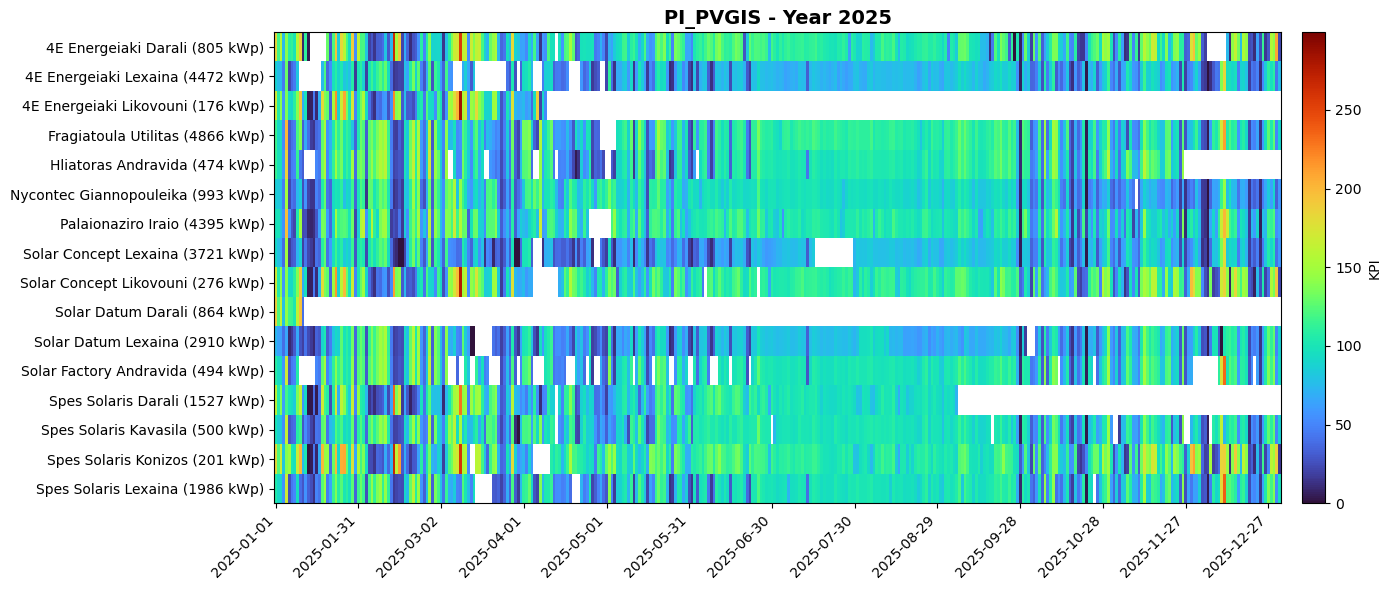

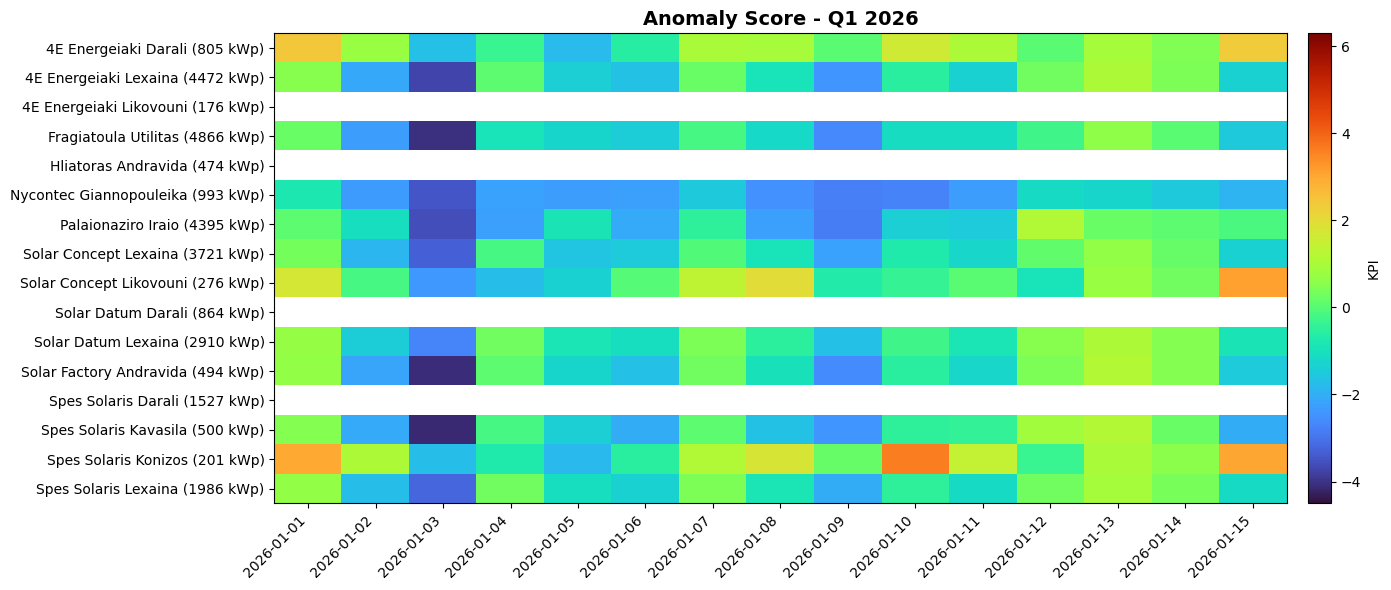

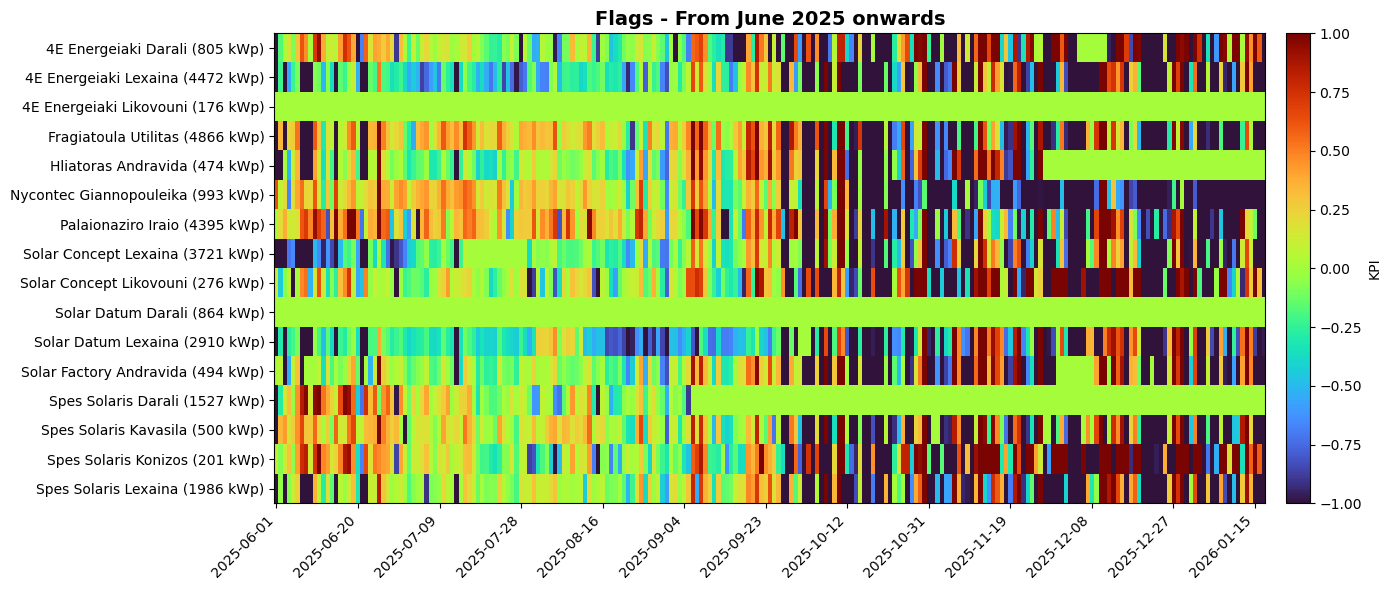

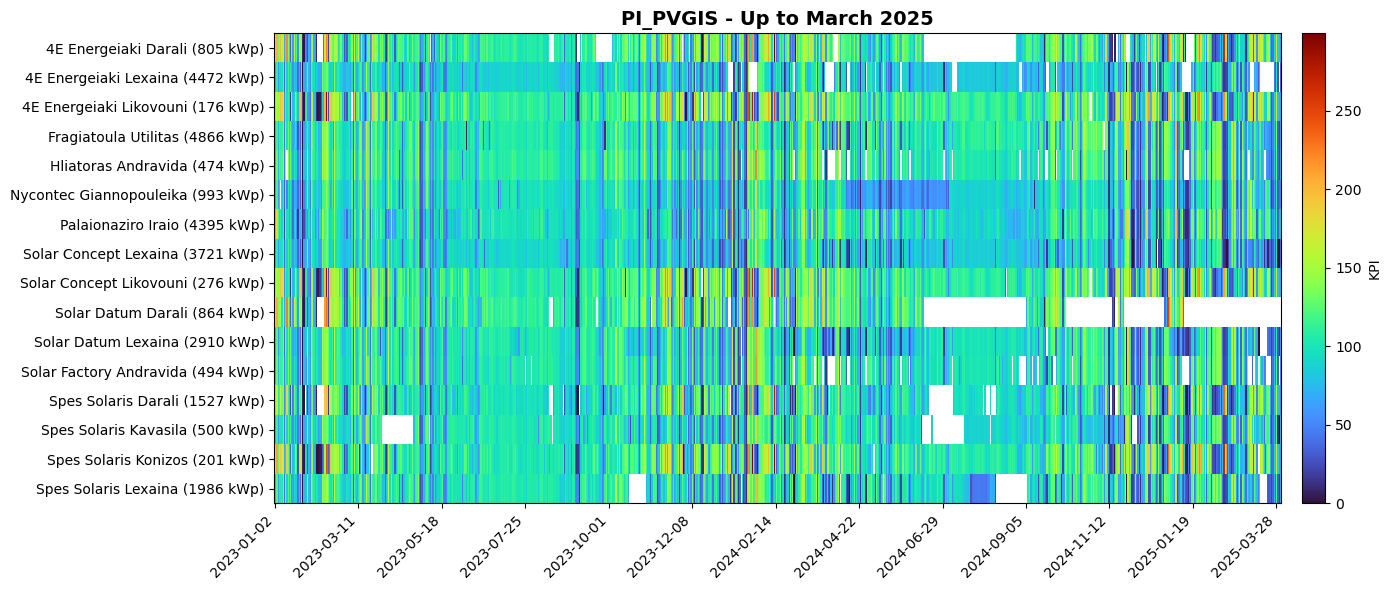

In [194]:
# Derive consistent color limits from the data
_gen_vmin, _gen_vmax = daily_historical.min().min(), daily_historical.max().max()
_pi_vmin, _pi_vmax = pi.min().min(), pi.max().max()
_score_vmin, _score_vmax = score.min().min(), score.max().max()
_flag_vmin, _flag_vmax = -1, 1

# Plot actual generation data with date filtering
plot_heatmap(daily_historical, "Daily Generation [kWh/day]", vmin=_gen_vmin, vmax=_gen_vmax,
             start_date='2026-01-01', end_date='2026-01-31',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_daily_jan2026", dpi=180, fmt="png")

# Example: Filter heatmap to show only specific date ranges
# Show only January 2026
plot_heatmap(pi, "PI_PVGIS - January 2026", vmin=_pi_vmin, vmax=_pi_vmax, 
             start_date='2026-01-01', end_date='2026-01-31',
             save=True, save_dir=PLOTS_DIR / "weekly_analysis", base_filename="heatmap_pi_jan2026", dpi=180, fmt="png")

# Show only 2025 data
plot_heatmap(pi, "PI_PVGIS - Year 2025", vmin=_pi_vmin, vmax=_pi_vmax, 
             start_date='2025-01-01', end_date='2025-12-31',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_pi_2025", dpi=180, fmt="png")

# Show Q1 2026
plot_heatmap(score, "Anomaly Score - Q1 2026", vmin=_score_vmin, vmax=_score_vmax,
             start_date='2026-01-01', end_date='2026-01-15',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_score_q1_2026", dpi=180, fmt="png")

# Show data from a specific date onwards
plot_heatmap(flag, "Flags - From June 2025 onwards", vmin=_flag_vmin, vmax=_flag_vmax,
             start_date='2025-06-01',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_flag_from_jun2025", dpi=180, fmt="png")

# Show data up to a specific date
plot_heatmap(pi, "PI_PVGIS - Up to March 2025", vmin=_pi_vmin, vmax=_pi_vmax,
             end_date='2025-03-31',
             save=False, save_dir=PLOTS_DIR, base_filename="heatmap_pi_until_mar2025", dpi=180, fmt="png")

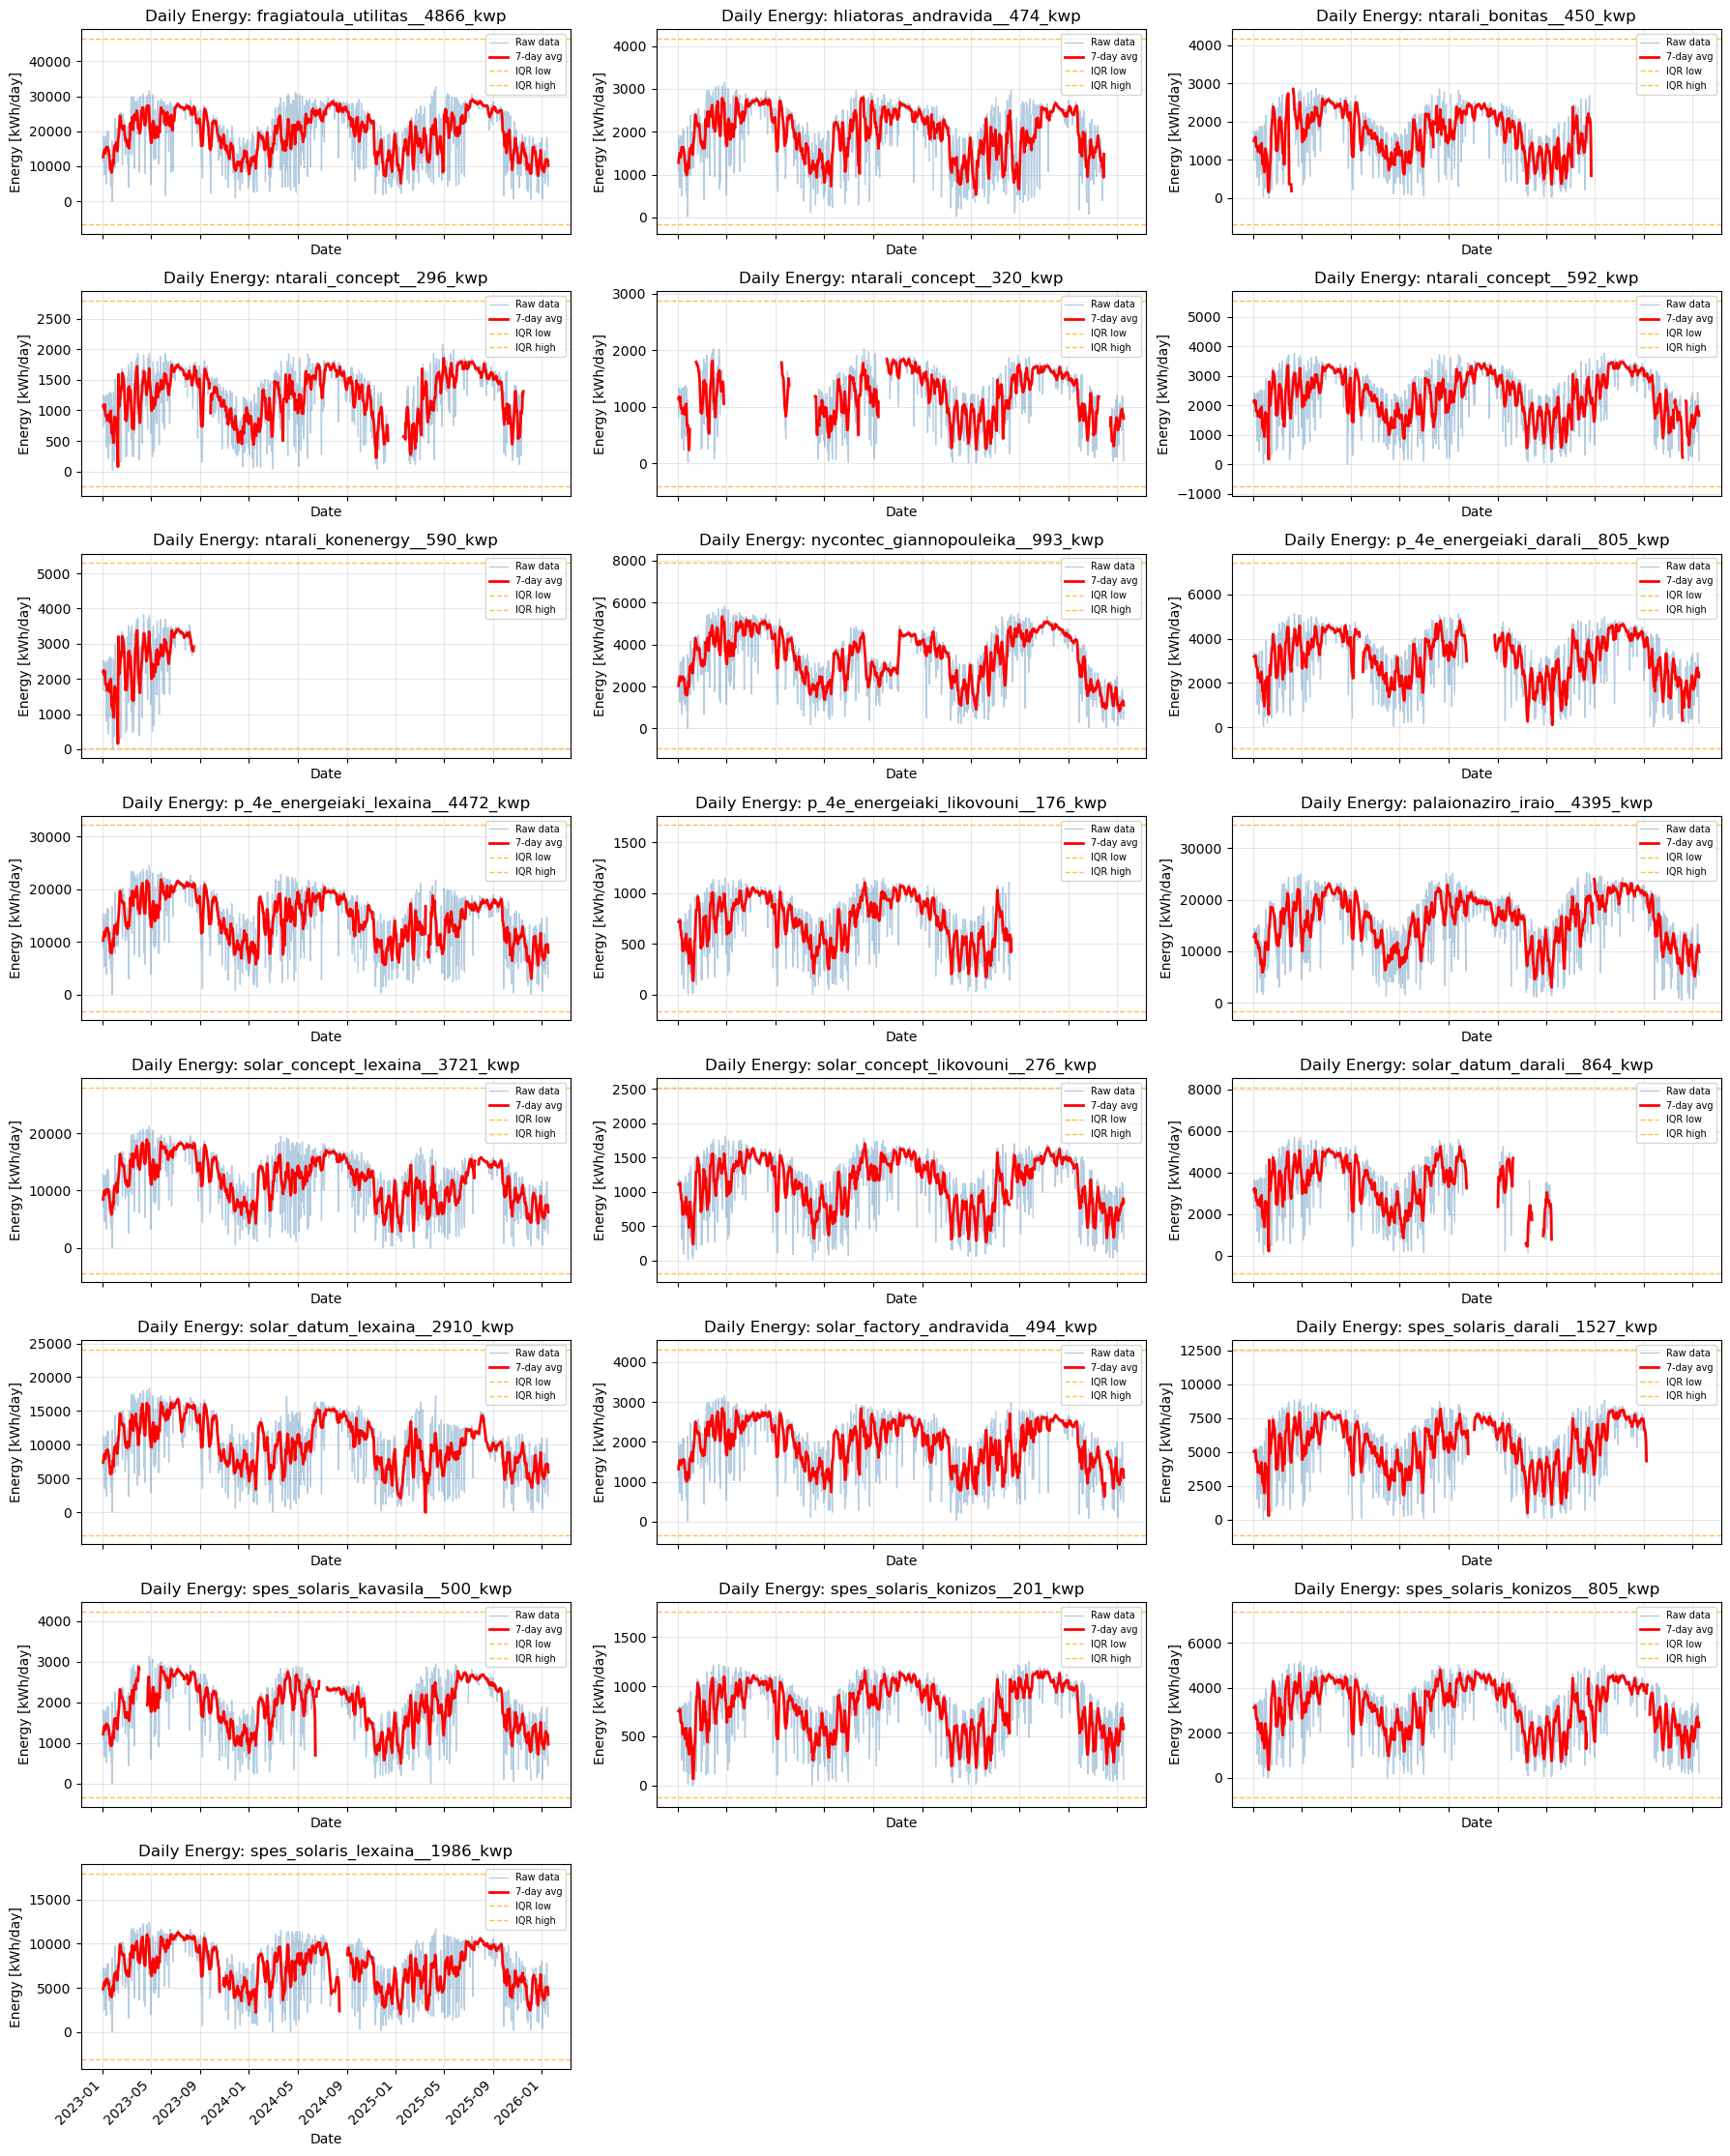

In [ ]:
def lineplot_timeseries_per_column(
    df: pd.DataFrame,
    title_prefix: str = "Time Series",
    ylabel: str = "Value",
    ncols: int = 3,
    sharex: bool = True,
    sharey: bool = False,
    rolling_window: int = 7,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Plot one line chart per column in a grid of subplots with rolling average and IQR bands.

    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame; each column is a park/series.
    title_prefix: str
        Prefix used in subplot titles and default filename.
    ylabel: str
        Y-axis label for all subplots (default: "Value").
    ncols: int
        Number of columns in the subplot grid.
    sharex/sharey: bool
        Share axes across subplots.
    rolling_window: int
        Window size for rolling average (default: 7 days).
    save: bool
        If True, saves the figure.
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title_prefix.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    cols = list(df.columns)
    if len(cols) == 0:
        print("No columns to plot.")
        return None

    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    figsize = (min(6 * ncols, 24), max(2.8 * nrows, 4))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey)
    if nrows == 1:
        axes = np.array([axes])
    if ncols == 1:
        axes = axes.reshape(nrows, 1)

    axes_flat = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes_flat[i]
        series = df[col]
        
        # Plot raw data with 40% opacity
        ax.plot(df.index, series, linewidth=1.0, alpha=0.6, color='steelblue', label='Raw data')
        
        # Compute rolling average
        rolling_mean = series.rolling(window=rolling_window, center=True, min_periods=1).mean()
        ax.plot(df.index, rolling_mean, linewidth=2.0, color='red', label=f'{rolling_window}-day avg')
        
        # Compute IQR bounds (Q1 - 1.5*IQR and Q3 + 1.5*IQR)
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Plot IQR bounds as horizontal lines
        ax.axhline(y=lower_bound, color='orange', linestyle='--', linewidth=1.0, alpha=0.7, label='IQR low')
        ax.axhline(y=upper_bound, color='orange', linestyle='--', linewidth=1.0, alpha=0.7, label='IQR high')
        
        # Handle tuple columns (park_id, signal, unit)
        if isinstance(col, tuple) and len(col) >= 3:
            park_id, signal, unit = col[0], col[1], col[2]
            # Try to extract capacity and park name
            try:
                import re
                m = re.search(r'(\d+)\s*kWp?\s*[_\-–—]?\s*(.+)', park_id)
                if m:
                    capacity_kwp = m.group(1)
                    park_name = m.group(2).strip()
                    label = f"{park_name} ({capacity_kwp} kWp)"
                else:
                    label = park_id
            except Exception:
                label = park_id
        else:
            try:
                label = extract_park_name_before_pcc(col)
            except Exception:
                label = str(col)
        
        ax.set_title(f"{title_prefix}: {label}")
        ax.grid(alpha=0.3)
        ax.set_xlabel("Date")
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right', fontsize=7, framealpha=0.8)

    for j in range(len(cols), len(axes_flat)):
        axes_flat[j].set_visible(False)

    for ax in axes_flat[:len(cols)]:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha('right')

    plt.tight_layout()

    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title_prefix,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )

    plt.show()
    return saved_path

_ = lineplot_timeseries_per_column(
    daily_historical,
    title_prefix="Daily Energy",
    ylabel="Energy [kWh/day]",
    ncols=3,
    sharex=True,
    sharey=False,
    rolling_window=21,
    save=True,
    save_dir=PLOTS_DIR / "weekly_analysis",
    base_filename="daily_energy_timeseries_grid",
    dpi=180,
    fmt="png",
)

In [ ]:
def histplot_distribution_per_column(
    df: pd.DataFrame,
    title_prefix: str = "Distribution",
    xlabel: str = "Value",
    ncols: int = 3,
    bins: int = 30,
    density: bool = False,
    dropna: bool = True,
    sharex: bool = False,
    sharey: bool = False,
    show_stats: bool = True,
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Plot one histogram per column in a grid of subplots and optionally save the figure.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame indexed by date; each column is a park/series.
    title_prefix: str
        Prefix used in subplot titles and default filename.
    xlabel: str
        X-axis label for all subplots (default: "Value").
    ncols: int
        Number of columns in the subplot grid.
    bins: int
        Histogram bin count.
    density: bool
        If True, normalize histogram to form a probability density.
    dropna: bool
        If True, exclude NaNs from each column.
    sharex/sharey: bool
        Share axes across subplots.
    show_stats: bool
        If True, draw vertical lines for mean and median.
    save: bool
        If True, saves the figure.
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title_prefix.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    cols = list(df.columns)
    if len(cols) == 0:
        print("No columns to plot.")
        return None

    n = len(cols)
    nrows = int(np.ceil(n / ncols))
    figsize = (min(6 * ncols, 24), max(2.8 * nrows, 4))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey)
    if nrows == 1:
        axes = np.array([axes])
    if ncols == 1:
        axes = axes.reshape(nrows, 1)

    axes_flat = axes.ravel()

    for i, col in enumerate(cols):
        ax = axes_flat[i]
        values = df[col]
        if dropna:
            values = values.dropna()

        ax.hist(values, bins=bins, alpha=0.75, color='steelblue', edgecolor='white', density=density)

        try:
            label = extract_park_name_before_pcc(col)
        except Exception:
            label = col
        ax.set_title(f"{title_prefix}: {label}")
        ax.grid(axis='y', alpha=0.3)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Density" if density else "Count")

        if show_stats and len(values) > 0:
            mean_val = float(values.mean())
            median_val = float(values.median())
            ax.axvline(mean_val, color='orange', linestyle='--', linewidth=1, label='Mean')
            ax.axvline(median_val, color='crimson', linestyle='--', linewidth=1, label='Median')
            ax.legend(fontsize=8)

    # Hide any unused axes
    for j in range(len(cols), len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()

    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title_prefix,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )

    plt.show()
    return saved_path

# Example: plot one histogram per column
_ = histplot_distribution_per_column(
    daily_historical,
    title_prefix="Daily Energy Distribution",
    xlabel="Energy [kWh]",
    ncols=3,
    bins=40,
    density=False,
    save=False,
    save_dir=PLOTS_DIR,
    base_filename="daily_energy_hist_grid",
    dpi=180,
    fmt="png",
)

In [ ]:
def barplot_nan_count(
    df: pd.DataFrame,
    title: str = "NaN Count per Column",
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Create a bar plot showing the count and percentage of NaN values for each column.
    
    Parameters:
    -----------
    df: pd.DataFrame
        The dataframe to analyze
    title: str
        Plot title
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved. If None and `save=True`,
        pass a directory explicitly (e.g., PLOTS_DIR) or it will fallback to CWD/"plots".
    base_filename: str | None
        Base filename without extension; if None, derived from title.
    dpi: int
        Resolution for the saved image.
    fmt: str
        File format for saving (e.g., "png", "pdf", "svg").
    """
    nan_counts = df.isna().sum()
    nan_pcts = (df.isna().sum() / len(df)) * 100
    
    # Sort by count descending
    nan_counts = nan_counts.sort_values(ascending=False)
    nan_pcts = nan_pcts[nan_counts.index]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of counts
    ax1.bar(range(len(nan_counts)), nan_counts.values, color='steelblue', alpha=0.7)
    ax1.set_xticks(range(len(nan_counts)))
    ax1.set_xticklabels([extract_park_name_before_pcc(col) for col in nan_counts.index], rotation=45, ha='right')
    ax1.set_ylabel("NaN Count")
    ax1.set_xlabel("PV Parks")
    ax1.set_title(f"{title} - Counts")
    ax1.grid(axis='y', alpha=0.3)
    
    # Bar plot of percentages
    ax2.bar(range(len(nan_pcts)), nan_pcts.values, color='coral', alpha=0.7)
    ax2.set_xticks(range(len(nan_pcts)))
    ax2.set_xticklabels([extract_park_name_before_pcc(col) for col in nan_pcts.index], rotation=45, ha='right')
    ax2.set_ylabel("NaN Percentage (%)")
    ax2.set_xlabel("PV Parks")
    ax2.set_title(f"{title} - Percentages")
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=50, color='red', linestyle='--', linewidth=1, label='50% threshold')
    ax2.legend()
    
    plt.tight_layout()
    
    # Use shared save utility
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    return nan_counts, nan_pcts, saved_path

nan_counts, nan_pcts, saved_path = barplot_nan_count(
    daily_historical,
    "NaN Analysis for Daily Data",
    save=False,
    save_dir=PLOTS_DIR,
    base_filename="nan_analysis_daily",
    dpi=180,
    fmt="png",
)
print(f"\nTotal columns: {len(daily_historical.columns)}")
print(f"Columns with NaN: {(nan_counts > 0).sum()}")
print(f"Columns with >50% NaN: {(nan_pcts > 50).sum()}")
if saved_path:
    print(f"✓ Figure saved to: {saved_path}")

In [ ]:
def analyze_month_to_date_by_year(
    df: pd.DataFrame,
    column: str | None = None,
    aggregation: str = 'sum',
    current_date: pd.Timestamp | str | None = None,
) -> pd.Series | list:
    """
    Analyze month-to-date values for a specific column (or all columns) across all years in the dataset.
    
    For the current month (e.g., January 16), this function extracts data from the 
    start of the month (Jan 1) to the current day (Jan 16) for each year in the dataset
    and aggregates it according to the specified method.
    
    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame with columns representing different series/parks
    column: str | None
        Column name to analyze. If None, aggregates across all columns.
        If not found, returns list of available columns.
    aggregation: str
        Aggregation method: 'sum', 'mean', 'avg', 'min', 'max', 'median', 'std', 'count'
        Default: 'sum'
    current_date: pd.Timestamp | str | None
        Reference date (defaults to today). Used to determine which month and day-of-month
        to analyze across all years
    
    Returns:
    --------
    pd.Series with year as index and aggregated values, or list of columns if column not found
    
    Example:
    --------
    # Analyze January 1-16 energy generation (sum) for each year for a specific park
    result = analyze_month_to_date_by_year(daily_historical, 'Park A [100 kWp]', 'sum')
    
    # Analyze January 1-16 energy generation (sum) for each year across all parks
    result = analyze_month_to_date_by_year(daily_historical, None, 'sum')
    
    # Analyze January 1-16 average generation for each year  
    result = analyze_month_to_date_by_year(daily_historical, 'Park B [200 kWp]', 'mean')
    """
    # Handle None column - aggregate across all columns
    if column is None:
        # Set current date (default to today)
        if current_date is None:
            current_date = pd.Timestamp.now()
        else:
            current_date = pd.to_datetime(current_date)
        
        # Extract current month and day
        current_month = current_date.month
        current_day = current_date.day
        
        # Map aggregation aliases
        agg_map = {
            'avg': 'mean',
            'average': 'mean',
        }
        aggregation = agg_map.get(aggregation.lower(), aggregation.lower())
        
        # Validate aggregation method
        valid_aggs = ['sum', 'mean', 'min', 'max', 'median', 'std', 'count']
        if aggregation not in valid_aggs:
            raise ValueError(f"Invalid aggregation '{aggregation}'. Valid options: {valid_aggs}")
        
        # Get all unique years in the dataset
        years = df.index.year.unique()
        
        results = {}
        
        for year in sorted(years):
            # Create date range for this year (month-to-date)
            start_date = pd.Timestamp(year=year, month=current_month, day=1)
            end_date = pd.Timestamp(year=year, month=current_month, day=current_day)
            
            # Check if this date range exists for this year
            if end_date > df.index.max() or start_date < df.index.min():
                # Skip years where the date range doesn't exist
                continue
            
            # Filter data for this period across all columns
            mask = (df.index >= start_date) & (df.index <= end_date)
            period_data = df.loc[mask].dropna(how='all')
            
            # Skip if no data for this period
            if len(period_data) == 0:
                continue
            
            # Apply aggregation across all columns first, then aggregate the result
            if aggregation == 'sum':
                # Sum all values across all columns for this period
                value = period_data.sum().sum()
            elif aggregation == 'mean':
                # Mean of all values across all columns for this period
                value = period_data.stack().mean()
            elif aggregation == 'min':
                # Minimum value across all columns for this period
                value = period_data.min().min()
            elif aggregation == 'max':
                # Maximum value across all columns for this period
                value = period_data.max().max()
            elif aggregation == 'median':
                # Median of all values across all columns for this period
                value = period_data.stack().median()
            elif aggregation == 'std':
                # Standard deviation of all values across all columns for this period
                value = period_data.stack().std()
            elif aggregation == 'count':
                # Count of non-null values across all columns for this period
                value = period_data.count().sum()
            
            results[year] = value
        
        # Create result series
        result = pd.Series(results, name=f'{aggregation.capitalize()}')
        result.index.name = 'Year'
        
        # Print summary
        month_name = current_date.strftime('%B')
        print(f"\n📊 Analysis: {month_name} 1-{current_day} ({aggregation}) for ALL COLUMNS")
        print(f"   Columns count: {len(df.columns)}")
        print(f"   Years analyzed: {len(result)}")
        print(f"   Date range per year: {month_name} 1 - {month_name} {current_day}")
        print(f"\n{result.to_string()}")
        
        return result
    
    # Check if column exists
    if column not in df.columns:
        print(f"❌ Column '{column}' not found in dataframe")
        print(f"\n📋 Available columns ({len(df.columns)}):")
        return list(df.columns)
    
    # Set current date (default to today)
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.to_datetime(current_date)
    
    # Extract current month and day
    current_month = current_date.month
    current_day = current_date.day
    
    # Map aggregation aliases
    agg_map = {
        'avg': 'mean',
        'average': 'mean',
    }
    aggregation = agg_map.get(aggregation.lower(), aggregation.lower())
    
    # Validate aggregation method
    valid_aggs = ['sum', 'mean', 'min', 'max', 'median', 'std', 'count']
    if aggregation not in valid_aggs:
        raise ValueError(f"Invalid aggregation '{aggregation}'. Valid options: {valid_aggs}")
    
    # Get all unique years in the dataset
    years = df.index.year.unique()
    
    results = {}
    
    for year in sorted(years):
        # Create date range for this year (month-to-date)
        start_date = pd.Timestamp(year=year, month=current_month, day=1)
        end_date = pd.Timestamp(year=year, month=current_month, day=current_day)
        
        # Check if this date range exists for this year
        if end_date > df.index.max() or start_date < df.index.min():
            # Skip years where the date range doesn't exist
            continue
        
        # Filter data for this period
        mask = (df.index >= start_date) & (df.index <= end_date)
        period_data = df.loc[mask, column].dropna()
        
        # Skip if no data for this period
        if len(period_data) == 0:
            continue
        
        # Apply aggregation
        if aggregation == 'sum':
            value = period_data.sum()
        elif aggregation == 'mean':
            value = period_data.mean()
        elif aggregation == 'min':
            value = period_data.min()
        elif aggregation == 'max':
            value = period_data.max()
        elif aggregation == 'median':
            value = period_data.median()
        elif aggregation == 'std':
            value = period_data.std()
        elif aggregation == 'count':
            value = period_data.count()
        
        results[year] = value
    
    # Create result series
    result = pd.Series(results, name=f'{aggregation.capitalize()}')
    result.index.name = 'Year'
    
    # Print summary
    month_name = current_date.strftime('%B')
    print(f"\n📊 Analysis: {month_name} 1-{current_day} ({aggregation}) for '{short_label(column)}'")
    print(f"   Column: {column}")
    print(f"   Years analyzed: {len(result)}")
    print(f"   Date range per year: {month_name} 1 - {month_name} {current_day}")
    print(f"\n{result.to_string()}")
    
    return result


# Example usage
print("="*80)
print("MONTH-TO-DATE ANALYSIS ACROSS YEARS")
print("="*80)

# Test: If column doesn't exist, it returns the column list
print("\n1. Testing with invalid column:")
columns_list = analyze_month_to_date_by_year(daily_historical, 'NonExistent Column', 'sum')

# Test: Analyze January 1-16 sum for the first park
if len(daily_historical.columns) > 0:
    print("\n2. Analyzing first park (sum):")
    first_park = daily_historical.columns[0]
    jan_sum = analyze_month_to_date_by_year(daily_historical, first_park, 'sum')
    
    print("\n3. Analyzing first park (mean):")
    jan_mean = analyze_month_to_date_by_year(daily_historical, first_park, 'mean')
    
    print("\n4. Analyzing first park (max):")
    jan_max = analyze_month_to_date_by_year(daily_historical, first_park, 'max')
    
    # Test: Analyze aggregation across all columns (column=None)
    print("\n5. Analyzing ALL columns (sum) - NEW FEATURE:")
    jan_all_sum = analyze_month_to_date_by_year(daily_historical, None, 'sum')
    
    print("\n6. Analyzing ALL columns (mean) - NEW FEATURE:")
    jan_all_mean = analyze_month_to_date_by_year(daily_historical, None, 'mean')


In [ ]:
def calculate_revenue_from_energy(
    energy_sum: pd.Series,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
) -> pd.Series:
    """
    Calculate revenue from energy generation values.
    
    Parameters:
    -----------
    energy_sum: pd.Series
        Series with energy values (kWh) indexed by year
    price_per_kwh: float
        Price per kWh in the specified currency (default: 0.2)
    currency: str
        Currency code for display (default: "EUR")
    
    Returns:
    --------
    pd.Series with revenue values indexed by year
    
    Example:
    --------
    # Get month-to-date energy sum for each year
    energy = analyze_month_to_date_by_year(daily_historical, 'Park A [100 kWp]', 'sum')
    
    # Calculate revenue at 0.2 EUR/kWh
    revenue = calculate_revenue_from_energy(energy, price_per_kwh=0.2)
    """
    revenue = energy_sum * price_per_kwh
    revenue.name = f'Revenue ({currency})'
    
    # Print summary
    print(f"\n💰 Revenue Calculation")
    print(f"   Price: {price_per_kwh:.4f} {currency}/kWh")
    print(f"   Years: {len(revenue)}")
    print(f"\n{revenue.to_string()}")
    print(f"\n   Total revenue: {revenue.sum():,.2f} {currency}")
    print(f"   Average revenue/year: {revenue.mean():,.2f} {currency}")
    print(f"   Min revenue: {revenue.min():,.2f} {currency} (Year {revenue.idxmin()})")
    print(f"   Max revenue: {revenue.max():,.2f} {currency} (Year {revenue.idxmax()})")
    
    return revenue


# Example usage
print("\n" + "="*80)
print("REVENUE ANALYSIS")
print("="*80)

if len(daily_historical.columns) > 0:
    first_park = daily_historical.columns[0]
    
    # Get January 1-16 energy sum for each year
    print("\n1. Getting month-to-date energy data for all columns:")
    jan_energy_all_sum = analyze_month_to_date_by_year(daily_historical, None, 'sum')
    
    # Calculate revenue at default price (0.2 EUR/kWh)
    print("\n2. Calculating revenue at 0.2 EUR/kWh:")
    revenue_default = calculate_revenue_from_energy(jan_energy_all_sum, price_per_kwh=0.2)


In [ ]:
def plot_revenue_by_year(
    revenue_series: pd.Series,
    title: str = "Month-to-Date Revenue by Year",
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    save: bool = False,
    save_dir: str | Path | None = None,
    base_filename: str | None = None,
    dpi: int = 150,
    fmt: str = "png",
):
    """
    Create an appealing bar chart visualization of revenue by year.
    
    Parameters:
    -----------
    revenue_series: pd.Series
        Series with revenue values indexed by year
    title: str
        Chart title
    price_per_kwh: float
        Price per kWh (for display purposes)
    currency: str
        Currency code for display (default: "EUR")
    save: bool
        If True, saves the figure
    save_dir: str | Path | None
        Directory where the figure will be saved
    base_filename: str | None
        Base filename without extension; if None, derived from title
    dpi: int
        Resolution for the saved image
    fmt: str
        File format for saving
    
    Returns:
    --------
    Tuple of (fig, saved_path)
    """
    fig, ax = plt.subplots(figsize=(12, 7), facecolor='white')
    
    # Calculate average and statistics
    avg_revenue = revenue_series.mean()
    
    # Create color list - gradient effect with conditional coloring
    colors = []
    for value in revenue_series.values:
        if value >= avg_revenue * 1.1:
            colors.append('#27ae60')  # Dark green - well above average
        elif value >= avg_revenue:
            colors.append('#2ecc71')  # Light green - above average
        elif value >= avg_revenue * 0.9:
            colors.append('#f39c12')  # Orange - near average
        else:
            colors.append('#e74c3c')  # Red - below average
    
    # Create bar chart with gradient effect
    bars = ax.bar(
        range(len(revenue_series)), 
        revenue_series.values,
        color=colors,
        alpha=0.85,
        edgecolor='#34495e',
        linewidth=2,
        width=0.6
    )
    
    # Add value labels on top of bars with formatted numbers
    for i, (year, value) in enumerate(zip(revenue_series.index, revenue_series.values)):
        label_y = value + (max(revenue_series.values) * 0.02)
        ax.text(
            i, label_y,
            f'{value:,.0f}\n{currency}',
            ha='center', va='bottom',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.3, edgecolor='none')
        )
    
    # Add average line with annotation
    ax.axhline(
        avg_revenue,
        color='#e74c3c',
        linestyle='--',
        linewidth=2.5,
        label=f'Average: {avg_revenue:,.0f} {currency}',
        alpha=0.8,
        zorder=2
    )
    
    # Styling
    ax.set_title(
        f'{title}\n({price_per_kwh} {currency}/kWh)',
        fontsize=16,
        fontweight='bold',
        pad=20,
        color='#2c3e50'
    )
    ax.set_xlabel('Year', fontsize=13, fontweight='bold', color='#34495e')
    ax.set_ylabel(f'Revenue [{currency}]', fontsize=13, fontweight='bold', color='#34495e')
    
    # Set x-axis ticks
    ax.set_xticks(range(len(revenue_series)))
    ax.set_xticklabels(revenue_series.index.astype(str), fontsize=12, fontweight='bold')
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000):,}k'))
    ax.tick_params(axis='y', labelsize=11)
    
    # Grid styling
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1, zorder=0)
    ax.set_axisbelow(True)
    
    # Add subtle background
    ax.set_facecolor('#f8f9fa')
    
    # Legend
    ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, fancybox=True)
    
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#34495e')
    ax.spines['bottom'].set_color('#34495e')
    
    plt.tight_layout()
    
    # Save figure if requested
    saved_path = save_figure(
        fig=fig,
        title_prefix=title,
        save=save,
        save_dir=save_dir,
        base_filename=base_filename,
        dpi=dpi,
        fmt=fmt,
    )
    
    plt.show()
    
    # Print detailed summary
    print("\n" + "="*70)
    print("REVENUE ANALYSIS SUMMARY")
    print("="*70)
    print(f"\n💰 Year-by-Year Revenue ({price_per_kwh} {currency}/kWh):")
    print(f"   {revenue_series.to_string()}\n")
    print(f"📊 Statistical Summary:")
    print(f"   Total Revenue:        {revenue_series.sum():>18,.2f} {currency}")
    print(f"   Average:              {revenue_series.mean():>18,.2f} {currency}")
    print(f"   Median:               {revenue_series.median():>18,.2f} {currency}")
    print(f"   Std Deviation:        {revenue_series.std():>18,.2f} {currency}")
    print(f"   Coefficient of Var:   {(revenue_series.std()/revenue_series.mean()*100):>18.2f}%")
    print(f"   Min (Year {revenue_series.idxmin()}):     {revenue_series.min():>18,.2f} {currency}")
    print(f"   Max (Year {revenue_series.idxmax()}):     {revenue_series.max():>18,.2f} {currency}")
    print(f"   Range:                {revenue_series.max() - revenue_series.min():>18,.2f} {currency}")
    
    if len(revenue_series) > 1:
        yoy_change = ((revenue_series.iloc[-1] - revenue_series.iloc[0]) / revenue_series.iloc[0]) * 100
        print(f"\n📈 Growth Metrics:")
        print(f"   Total Change (First → Last): {yoy_change:>12.2f}%")
        print(f"   First Year: {revenue_series.iloc[0]:>30,.2f} {currency}")
        print(f"   Last Year:  {revenue_series.iloc[-1]:>30,.2f} {currency}")
    
    if saved_path:
        print(f"\n✅ Figure saved to: {saved_path}")
    
    return fig, saved_path


# Create the revenue visualization
print("\n🎨 Creating Enhanced Revenue Chart...\n")
fig, saved_path = plot_revenue_by_year(
    revenue_default,
    title="Month-to-Date Revenue by Year All Parks (January 1-16)",
    price_per_kwh=0.2,
    currency="EUR",
    save=True,
    save_dir=PLOTS_DIR / "weekly_analysis",
    base_filename="revenue_by_year",
    dpi=180,
    fmt="png",
)


In [ ]:
def aggregate_month_to_date_by_column(
    df: pd.DataFrame,
    aggregation: str = 'sum',
    current_date: pd.Timestamp | str | None = None,
) -> pd.Series:
    """
    Return month-to-date aggregated values for each column.
    
    This computes the aggregation from the first day of the month up to `current_date`
    for the year of `current_date` (default: today), returning a Series indexed by
    column with one aggregated value per column.
    
    Parameters
    ----------
    df : pd.DataFrame
        Date-indexed DataFrame where each column represents a park/series.
    aggregation : str
        One of: 'sum', 'mean'/'avg'/'average', 'min', 'max', 'median', 'std', 'count'.
    current_date : pd.Timestamp | str | None
        The reference date defining the month-to-date window. If None, uses today.
    
    Returns
    -------
    pd.Series
        Series indexed by column with the month-to-date aggregated value for each column.
    
    Examples
    --------
    # Sum of kWh for each park for the current month-to-date
    # aggregate_month_to_date_by_column(daily_historical, aggregation='sum')
    
    # Mean kWh for each park month-to-date on a specific date
    # aggregate_month_to_date_by_column(daily_historical, aggregation='mean', current_date='2026-01-17')
    """
    # Normalize and validate current_date
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.to_datetime(current_date)
    
    # Ensure datetime index (naive)
    idx = pd.to_datetime(df.index)
    df = df.copy()
    df.index = idx
    
    # Map aggregation aliases
    agg_map = {
        'avg': 'mean',
        'average': 'mean',
    }
    agg = agg_map.get(str(aggregation).lower(), str(aggregation).lower())
    
    valid_aggs = ['sum', 'mean', 'min', 'max', 'median', 'std', 'count']
    if agg not in valid_aggs:
        raise ValueError(f"Invalid aggregation '{aggregation}'. Valid options: {valid_aggs}")
    
    # Build month-to-date window for the current year
    year = int(current_date.year)
    month = int(current_date.month)
    day = int(current_date.day)
    start_date = pd.Timestamp(year=year, month=month, day=1)
    end_date = pd.Timestamp(year=year, month=month, day=day)
    
    # Slice the DataFrame for the period
    mask = (df.index >= start_date) & (df.index <= end_date)
    period_df = df.loc[mask]
    
    if period_df.empty:
        # Return a Series of NaNs with the same columns if there is no data
        return pd.Series([pd.NA] * len(df.columns), index=df.columns, name=f"MTD {agg.capitalize()}")
    
    # Compute aggregation per column
    if agg == 'sum':
        out = period_df.sum(axis=0, skipna=True)
    elif agg == 'mean':
        out = period_df.mean(axis=0, skipna=True)
    elif agg == 'min':
        out = period_df.min(axis=0, skipna=True)
    elif agg == 'max':
        out = period_df.max(axis=0, skipna=True)
    elif agg == 'median':
        out = period_df.median(axis=0, skipna=True)
    elif agg == 'std':
        out = period_df.std(axis=0, skipna=True)
    elif agg == 'count':
        out = period_df.count(axis=0)
    
    month_name = current_date.strftime('%B')
    out.name = f"MTD {agg.capitalize()} ({month_name} 1-{day})"
    return out

# Quick validation of aggregate_month_to_date_by_column
print("\n🔎 Computing MTD sum per column...")
mtd_sum_by_col = aggregate_month_to_date_by_column(daily_historical, aggregation='sum')
print(mtd_sum_by_col.sort_values(ascending=False).head())

print("\n🔎 Computing MTD mean per column...")
mtd_mean_by_col = aggregate_month_to_date_by_column(daily_historical, aggregation='mean')
print(mtd_mean_by_col.sort_values(ascending=False).head())

print("\n Computing total revenue from MTD sum at 20 EUR/kWh...")
revenue_all_columns = calculate_revenue_from_energy(mtd_mean_by_col, price_per_kwh=20)
print(revenue_all_columns.sort_values(ascending=False).head())

In [ ]:
def plot_mtd_revenue_by_year_grid(
    daily_historical_df: pd.DataFrame,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    current_date: pd.Timestamp | str | None = None,
    power_mapping_df: pd.DataFrame | None = None,
    power_mapping_path: Path | str | None = None,
    ncols: int = 3,
    save: bool = True,
    save_dir: Path | None = None,
    base_filename: str = "mtd_revenue_by_year_grid",
    dpi: int = 180,
    fmt: str = "png",
) -> Path | None:
    """
    Grid of revenue-by-year charts, one per park, similar to `plot_revenue_by_year`.

    For each column (park), computes month-to-date energy per year via
    `analyze_month_to_date_by_year(..., aggregation='sum')`, converts to revenue,
    and renders a bar chart with average reference line and value annotations.
    
    Revenue is normalized per kWp: (energy_kwh * price_per_kwh) / power_kwp
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Current date normalization
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.Timestamp(current_date)

    # Load power mapping if not provided
    if power_mapping_df is None:
        if power_mapping_path is None:
            power_mapping_path = WORKSPACE_ROOT / "outputs" / "park_power_mapping.csv"
        power_mapping_df = pd.read_csv(power_mapping_path, index_col=0)

    # Build a dictionary of park -> power_kwp for quick lookup
    power_kwp_dict = {}
    for col in daily_historical_df.columns:
        if col in power_mapping_df.index:
            power_kwp_dict[col] = float(power_mapping_df.loc[col, 'power_kwp'])
        else:
            # Fallback: try to parse from column name
            try:
                kwp = parse_kwp_from_header(col)
                power_kwp_dict[col] = kwp
            except Exception:
                print(f"⚠️  Warning: Could not find power for {col}, defaulting to 100 kWp")
                power_kwp_dict[col] = 100.0

    # Ensure save_dir
    if save_dir is None:
        save_dir = PLOTS_DIR / "financial_analysis"
        save_dir.mkdir(parents=True, exist_ok=True)

    # Columns (parks)
    parks = list(daily_historical_df.columns)
    nparks = len(parks)
    nrows = int(np.ceil(nparks / ncols))

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5.5 * ncols, 4.2 * nrows),
        constrained_layout=True,
        facecolor="white",
    )

    axes_list = axes.flatten() if hasattr(axes, "flatten") else np.ravel(axes)

    # Helper for short label
    import re as _re
    def _short_label(col: str) -> str:
        try:
            from src.pvgis_pi_heatmap import short_label as _sl
            return _sl(col)
        except Exception:
            m = _re.search(r"\[(.*?)\]", str(col))
            return m.group(1) if m else str(col)

    # Build each subplot
    for idx, park in enumerate(parks):
        ax = axes_list[idx]
        # Month-to-date energy per year
        mtd_energy = analyze_month_to_date_by_year(
            daily_historical_df,
            park,
            aggregation='sum',
            current_date=current_date,
        )
        # Convert to revenue: (energy * price) / power_kwp
        power_kwp = power_kwp_dict.get(park, 100.0)
        mtd_revenue = (mtd_energy * price_per_kwh) / power_kwp

        # Compute average and colors similar to plot_revenue_by_year
        avg_val = float(mtd_revenue.mean()) if len(mtd_revenue) else 0.0
        colors = []
        for v in mtd_revenue.values:
            if v >= 1.10 * avg_val:
                colors.append('#27ae60')
            elif v >= avg_val:
                colors.append('#2ecc71')
            elif v >= 0.90 * avg_val:
                colors.append('#f39c12')
            else:
                colors.append('#e74c3c')

        # Bar chart
        bars = ax.bar(range(len(mtd_revenue)), mtd_revenue.values,
                      color=colors, alpha=0.85, edgecolor='#34495e', linewidth=1.5, width=0.6)

        # Value labels
        if len(mtd_revenue):
            ymax = float(max(mtd_revenue.values))
        else:
            ymax = 0.0
        for i, (year, value) in enumerate(zip(mtd_revenue.index, mtd_revenue.values)):
            label_y = value + (ymax * 0.02)
            ax.text(i, label_y, f"{value:,.0f}\n{currency}/kWp", ha='center', va='bottom', fontsize=9,
                    fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3, edgecolor='none'))

        # Average line
        if len(mtd_revenue):
            ax.axhline(avg_val, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8,
                       label=f'Average: {avg_val:,.0f} {currency}/kWp')

        # Axis styling
        ax.set_xticks(range(len(mtd_revenue)))
        ax.set_xticklabels(mtd_revenue.index.astype(str), fontsize=10, fontweight='bold', rotation=45)
        ax.set_ylabel(f'Revenue per kWp [{currency}/kWp]', fontsize=10, fontweight='bold', color='#34495e')
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
        ax.set_facecolor('#f8f9fa')
        ax.legend(fontsize=9, loc='upper left', frameon=True, shadow=True, fancybox=True)

        # Title per park
        ax.set_title(f"{extract_park_name_before_pcc(park)}\nMonth-to-Date Revenue per kWp", fontsize=11, fontweight='bold', color='#2c3e50')

        # Remove top/right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#34495e')
        ax.spines['bottom'].set_color('#34495e')

    # Hide unused axes
    for j in range(nparks, len(axes_list)):
        axes_list[j].axis('off')

    month_name = current_date.strftime('%B %Y')
    # Add spacing between subplots and title
    plt.subplots_adjust(top=0.93, hspace=0.35, wspace=0.3)
    
    fig.suptitle(f"Month-to-Date Revenue per kWp by Year — All Parks ({month_name})", fontsize=14, fontweight='bold', y=1.01)

    from src.utils import save_figure
    saved_path = save_figure(fig, title_prefix="MTD Revenue per kWp by Year Grid", save=save, save_dir=save_dir,
                             base_filename=base_filename, dpi=dpi, fmt=fmt)
    plt.show()
    plt.close(fig)
    return saved_path

# Validate: Plot per-park revenue by year grid
current_date = pd.Timestamp.now()
saved_mtd_year_grid = plot_mtd_revenue_by_year_grid(
    daily_historical,
    price_per_kwh=0.2,
    currency="EUR",
    current_date=current_date,
    ncols=3,
    save=True,
    save_dir=PLOTS_DIR / "weekly_analysis",
    base_filename="mtd_revenue_by_year_grid",
    dpi=180,
    fmt="png",
)
print(f"\n📁 Saved MTD by year grid to: {saved_mtd_year_grid}")

In [ ]:
def create_economic_analysis_dashboard(
    df: pd.DataFrame,
    column: str,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    figsize_main: tuple = (20, 24),
    dpi: int = 150,
):
    """
    Create a comprehensive economic analysis dashboard with multiple visualizations.
    
    Includes:
    - Time series of monthly energy and revenue
    - Year-over-year comparison (bar charts)
    - Monthly aggregation to identify seasonal patterns
    - Correlation heatmap between years
    - Autocorrelation analysis (ACF/PACF)
    - Growth rates and year-on-year changes
    - Distribution analysis
    - Rolling statistics (mean, std)
    
    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame with energy data
    column: str
        Column name to analyze
    price_per_kwh: float
        Energy price in currency units (default: 0.2 EUR/kWh)
    currency: str
        Currency code for display (default: "EUR")
    figsize_main: tuple
        Figure size for main dashboard (default: (20, 24))
    dpi: int
        Resolution for the dashboard (default: 150)
    """
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import warnings
    warnings.filterwarnings('ignore')
    
    if column not in df.columns:
        print(f"❌ Column '{column}' not found")
        return
    
    # Get daily data
    daily_series = df[column].dropna()
    
    # Resample to monthly data
    monthly_data = daily_series.resample('MS').sum()
    monthly_data.index = monthly_data.index.to_period('M')
    
    # Calculate revenue
    monthly_revenue = monthly_data * price_per_kwh
    
    # Create the dashboard
    fig = plt.figure(figsize=figsize_main, facecolor='white')
    gs = fig.add_gridspec(6, 3, hspace=0.35, wspace=0.3, top=0.96)
    
    print(f"📊 Creating Economic Analysis Dashboard for {short_label(column)}")
    print(f"   Data range: {daily_series.index.min()} to {daily_series.index.max()}")
    print(f"   Monthly observations: {len(monthly_data)}")
    
    # ========== 1. Time Series of Monthly Energy ==========
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(range(len(monthly_data)), monthly_data.values, 'o-', linewidth=2.5, 
             markersize=6, color='#2E86AB', label='Monthly Generation')
    ax1.fill_between(range(len(monthly_data)), monthly_data.values, alpha=0.3, color='#2E86AB')
    ax1.set_title('Monthly Energy Generation - Time Series', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Month Index')
    ax1.set_ylabel('Energy [kWh]')
    ax1.grid(alpha=0.3, linestyle='--')
    ax1.legend()
    
    # ========== 2. Rolling Statistics ==========
    ax2 = fig.add_subplot(gs[0, 2])
    rolling_mean = monthly_data.rolling(window=3).mean()
    rolling_std = monthly_data.rolling(window=3).std()
    ax2.plot(range(len(monthly_data)), monthly_data.values, 'o-', alpha=0.5, label='Actual')
    ax2.plot(range(len(rolling_mean)), rolling_mean.values, 's-', linewidth=2, color='red', label='3-month MA')
    ax2.fill_between(range(len(rolling_mean)), 
                     rolling_mean.values - rolling_std.values,
                     rolling_mean.values + rolling_std.values,
                     alpha=0.2, color='red')
    ax2.set_title('Rolling Mean & Std Dev', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Energy [kWh]')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3, linestyle='--')
    
    # ========== 3. Monthly Revenue Time Series ==========
    ax3 = fig.add_subplot(gs[1, :2])
    colors = ['green' if v > monthly_revenue.mean() else 'coral' for v in monthly_revenue.values]
    ax3.bar(range(len(monthly_revenue)), monthly_revenue.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax3.axhline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {monthly_revenue.mean():,.0f}')
    ax3.set_title(f'Monthly Revenue - Time Series ({currency}/month)', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Month Index')
    ax3.set_ylabel(f'Revenue [{currency}]')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # ========== 4. Revenue Distribution ==========
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.hist(monthly_revenue.values, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
    ax4.axvline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax4.axvline(monthly_revenue.median(), color='green', linestyle='--', linewidth=2, label='Median')
    ax4.set_title('Revenue Distribution', fontsize=13, fontweight='bold')
    ax4.set_xlabel(f'Revenue [{currency}]')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    # ========== 5. Month-to-Date Analysis by Year ==========
    ax5 = fig.add_subplot(gs[2, :2])
    monthly_by_year = daily_series.groupby(daily_series.index.month).sum()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax5.bar(range(len(monthly_by_year)), monthly_by_year.values, color='#A23B72', alpha=0.7, edgecolor='black')
    ax5.set_xticks(range(12))
    ax5.set_xticklabels(months, rotation=45, ha='right')
    ax5.set_title('Seasonal Pattern - Energy by Calendar Month', fontsize=13, fontweight='bold')
    ax5.set_xlabel('Month')
    ax5.set_ylabel('Total Energy [kWh]')
    ax5.grid(axis='y', alpha=0.3)
    
    # ========== 6. Seasonal Revenue ==========
    ax6 = fig.add_subplot(gs[2, 2])
    seasonal_revenue = daily_series.groupby(daily_series.index.month).sum() * price_per_kwh
    colors_seasonal = ['gold' if v > seasonal_revenue.mean() else 'lightblue' for v in seasonal_revenue.values]
    ax6.bar(range(len(seasonal_revenue)), seasonal_revenue.values, color=colors_seasonal, alpha=0.7, edgecolor='black')
    ax6.axhline(seasonal_revenue.mean(), color='red', linestyle='--', linewidth=2)
    ax6.set_xticks(range(12))
    ax6.set_xticklabels(months, rotation=45, ha='right')
    ax6.set_title(f'Seasonal Revenue Pattern ({currency})', fontsize=13, fontweight='bold')
    ax6.set_ylabel(f'Revenue [{currency}]')
    ax6.grid(axis='y', alpha=0.3)
    
    # ========== 7. Year-over-Year Growth Rate ==========
    ax7 = fig.add_subplot(gs[3, 0])
    yearly_energy = daily_series.groupby(daily_series.index.year).sum()
    if len(yearly_energy) > 1:
        yoy_growth = yearly_energy.pct_change() * 100
        yoy_growth_clean = yoy_growth.dropna()  # Remove NaN from first year
        colors_growth = ['green' if x > 0 else 'red' for x in yoy_growth_clean.values]
        ax7.bar(range(len(yoy_growth_clean)), yoy_growth_clean.values, color=colors_growth, alpha=0.7, edgecolor='black')
        ax7.axhline(0, color='black', linewidth=1)
        ax7.set_xticks(range(len(yoy_growth_clean)))
        ax7.set_xticklabels(yoy_growth_clean.index, rotation=45, ha='right')
        ax7.set_title('Year-over-Year Growth Rate (%)', fontsize=13, fontweight='bold')
        ax7.set_ylabel('Growth Rate (%)')
        ax7.grid(axis='y', alpha=0.3)
    
    # ========== 8. Annual Energy by Year ==========
    ax8 = fig.add_subplot(gs[3, 1])
    ax8.bar(range(len(yearly_energy)), yearly_energy.values, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax8.set_xticks(range(len(yearly_energy)))
    ax8.set_xticklabels(yearly_energy.index, rotation=45, ha='right')
    ax8.set_title('Annual Energy Generation by Year', fontsize=13, fontweight='bold')
    ax8.set_ylabel('Energy [kWh/year]')
    ax8.grid(axis='y', alpha=0.3)
    
    # ========== 9. Annual Revenue by Year ==========
    ax9 = fig.add_subplot(gs[3, 2])
    yearly_revenue = yearly_energy * price_per_kwh
    colors_revenue = ['darkgreen' if v > yearly_revenue.mean() else 'darkred' for v in yearly_revenue.values]
    ax9.bar(range(len(yearly_revenue)), yearly_revenue.values, color=colors_revenue, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax9.set_xticks(range(len(yearly_revenue)))
    ax9.set_xticklabels(yearly_revenue.index, rotation=45, ha='right')
    ax9.set_title(f'Annual Revenue by Year ({currency})', fontsize=13, fontweight='bold')
    ax9.set_ylabel(f'Revenue [{currency}/year]')
    ax9.grid(axis='y', alpha=0.3)
    
    # ========== 10. Autocorrelation Function (ACF) ==========
    ax10 = fig.add_subplot(gs[4, 0])
    try:
        plot_acf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax10, title='Autocorrelation (Monthly Data)')
        ax10.set_ylabel('ACF')
        ax10.grid(alpha=0.3)
    except Exception as e:
        ax10.text(0.5, 0.5, f'ACF Error: {str(e)[:30]}', ha='center', va='center')
    
    # ========== 11. Partial Autocorrelation (PACF) ==========
    ax11 = fig.add_subplot(gs[4, 1])
    try:
        plot_pacf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax11, method='ywm', title='Partial Autocorrelation (Monthly)')
        ax11.set_ylabel('PACF')
        ax11.grid(alpha=0.3)
    except Exception as e:
        ax11.text(0.5, 0.5, f'PACF Error: {str(e)[:30]}', ha='center', va='center')
    
    # ========== 12. Monthly Volatility ==========
    ax12 = fig.add_subplot(gs[4, 2])
    monthly_volatility = monthly_data.rolling(window=3).std()
    ax12.plot(range(len(monthly_volatility)), monthly_volatility.values, 'o-', color='#A23B72', linewidth=2, markersize=6)
    ax12.fill_between(range(len(monthly_volatility)), monthly_volatility.values, alpha=0.3, color='#A23B72')
    ax12.set_title('Rolling Volatility (3-month Std Dev)', fontsize=13, fontweight='bold')
    ax12.set_ylabel('Std Dev [kWh]')
    ax12.grid(alpha=0.3, linestyle='--')
    
    # ========== 13. Cumulative Energy & Revenue ==========
    ax13 = fig.add_subplot(gs[5, 0])
    cumsum_energy = monthly_data.cumsum()
    ax13.plot(range(len(cumsum_energy)), cumsum_energy.values, 'o-', linewidth=2.5, color='#2E86AB', markersize=5)
    ax13.fill_between(range(len(cumsum_energy)), cumsum_energy.values, alpha=0.3, color='#2E86AB')
    ax13.set_title('Cumulative Energy Generation', fontsize=13, fontweight='bold')
    ax13.set_xlabel('Month Index')
    ax13.set_ylabel('Cumulative Energy [kWh]')
    ax13.grid(alpha=0.3, linestyle='--')
    
    # ========== 14. Cumulative Revenue ==========
    ax14 = fig.add_subplot(gs[5, 1])
    cumsum_revenue = monthly_revenue.cumsum()
    ax14.plot(range(len(cumsum_revenue)), cumsum_revenue.values, 's-', linewidth=2.5, color='green', markersize=5)
    ax14.fill_between(range(len(cumsum_revenue)), cumsum_revenue.values, alpha=0.3, color='green')
    ax14.set_title(f'Cumulative Revenue ({currency})', fontsize=13, fontweight='bold')
    ax14.set_xlabel('Month Index')
    ax14.set_ylabel(f'Cumulative Revenue [{currency}]')
    ax14.grid(alpha=0.3, linestyle='--')
    
    # ========== 15. Statistical Summary Box ==========
    ax15 = fig.add_subplot(gs[5, 2])
    ax15.axis('off')
    
    # Calculate key statistics
    stats_text = f"""
    ╔════════════════════════════════════╗
    ║     ECONOMIC SUMMARY STATISTICS    ║
    ╠════════════════════════════════════╣
    ║ Energy (Monthly)                   ║
    ║  Mean:        {monthly_data.mean():>15,.0f} kWh
    ║  Median:      {monthly_data.median():>15,.0f} kWh
    ║  Std Dev:     {monthly_data.std():>15,.0f} kWh
    ║  Min:         {monthly_data.min():>15,.0f} kWh
    ║  Max:         {monthly_data.max():>15,.0f} kWh
    ║                                    ║
    ║ Revenue (Monthly @ {price_per_kwh} {currency}/kWh)  ║
    ║  Mean:        {monthly_revenue.mean():>15,.0f} {currency}
    ║  Median:      {monthly_revenue.median():>15,.0f} {currency}
    ║  Std Dev:     {monthly_revenue.std():>15,.0f} {currency}
    ║  Min:         {monthly_revenue.min():>15,.0f} {currency}
    ║  Max:         {monthly_revenue.max():>15,.0f} {currency}
    ║                                    ║
    ║ Aggregated Totals                  ║
    ║  Total Energy: {daily_series.sum():>14,.0f} kWh
    ║  Total Revenue:{yearly_revenue.sum():>14,.0f} {currency}
    ║  Annual Avg:  {yearly_revenue.mean():>15,.0f} {currency}
    ╚════════════════════════════════════╝
    """
    
    ax15.text(0.05, 0.95, stats_text, transform=ax15.transAxes, fontsize=10,
              verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle(f'Economic Analysis Dashboard - {short_label(column)} ({parse_kwp_from_header(column):.0f} kWp)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*70)
    print("DETAILED ECONOMIC ANALYSIS")
    print("="*70)
    print(f"\n📊 ENERGY STATISTICS (Monthly)")
    print(f"   Mean:              {monthly_data.mean():>15,.0f} kWh")
    print(f"   Median:            {monthly_data.median():>15,.0f} kWh")
    print(f"   Std Deviation:     {monthly_data.std():>15,.0f} kWh")
    print(f"   Coefficient of Variation: {(monthly_data.std()/monthly_data.mean()*100):>6.2f}%")
    print(f"   Min/Max Ratio:     {(monthly_data.min()/monthly_data.max()):>15.4f}")
    
    print(f"\n💰 REVENUE STATISTICS (Monthly @ {price_per_kwh} {currency}/kWh)")
    print(f"   Mean:              {monthly_revenue.mean():>15,.2f} {currency}")
    print(f"   Median:            {monthly_revenue.median():>15,.2f} {currency}")
    print(f"   Std Deviation:     {monthly_revenue.std():>15,.2f} {currency}")
    print(f"   Coefficient of Variation: {(monthly_revenue.std()/monthly_revenue.mean()*100):>6.2f}%")
    
    print(f"\n📈 ANNUAL METRICS")
    print(f"   Total Energy (all years):  {daily_series.sum():>15,.0f} kWh")
    print(f"   Total Revenue (all years): {yearly_revenue.sum():>15,.2f} {currency}")
    print(f"   Average Annual Energy:     {yearly_energy.mean():>15,.0f} kWh/year")
    print(f"   Average Annual Revenue:    {yearly_revenue.mean():>15,.2f} {currency}/year")
    
    if len(yearly_energy) > 1:
        print(f"\n📊 YEAR-OVER-YEAR TRENDS")
        print(f"   Total YoY Growth:        {((yearly_energy.iloc[-1]/yearly_energy.iloc[0])-1)*100:>14.2f}%")
        print(f"   Average YoY Change:      {(yearly_energy.pct_change().mean()*100):>14.2f}%")


# Create dashboard for the first park
if len(daily_historical.columns) > 0:
    first_park = daily_historical.columns[0]
    create_economic_analysis_dashboard(daily_historical, first_park, price_per_kwh=0.2, currency="EUR")


In [ ]:
def create_financial_report_for_all_parks(
    df: pd.DataFrame,
    column: str,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    report_date: str | pd.Timestamp | None = None,
    save_dir: Path | None = None,
    dpi: int = 150,
):
    """
    Generate economic analysis dashboard for a single park in the dataframe and create a markdown report.
    
    Parameters:
    -----------
    df: pd.DataFrame
        Date-indexed DataFrame with energy data; each column represents a park
    column: str
        Column name (park) to analyze
    price_per_kwh: float
        Energy price in currency units (default: 0.2)
    currency: str
        Currency code for display (default: "EUR")
    report_date: str | pd.Timestamp | None
        Report date (defaults to today). Format: 'YYYY-MM-DD'
    save_dir: Path | None
        Directory where plots will be saved. If None, uses PLOTS_DIR.
    dpi: int
        Resolution for saved images (default: 150)
    
    Returns:
    --------
    Path to the generated report file
    """
    from pathlib import Path
    from datetime import datetime
    import matplotlib.pyplot as plt
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from src.utils import sanitize_filename
    import warnings
    warnings.filterwarnings('ignore')
    
    # Set defaults
    if save_dir is None:
        save_dir = PLOTS_DIR
    
    if report_date is None:
        report_date = pd.Timestamp.now()
    else:
        report_date = pd.Timestamp(report_date)
    
    # Validate column exists
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in dataframe. Available columns: {list(df.columns)}")
    
    # Create subdirectory for financial analysis plots
    financial_dir = Path(save_dir) / "financial_analysis"
    financial_dir.mkdir(parents=True, exist_ok=True)
    
    print("="*80)
    print("GENERATING FINANCIAL ANALYSIS REPORT")
    print("="*80)
    print(f"Report Date: {report_date.strftime('%B %d, %Y')}")
    print(f"Park to analyze: {column}")
    print(f"Save Directory: {financial_dir}")
    print(f"Price: {price_per_kwh} {currency}/kWh")
    print("="*80)
    
    print(f"\nProcessing: {short_label(column)}")
    try:
        # Get data for this column
        daily_series = df[column].dropna()
        
        if len(daily_series) == 0:
            raise ValueError(f"No data available for column '{column}'")
        
        # Calculate aggregations
        monthly_data = daily_series.resample('MS').sum()
        monthly_revenue = monthly_data * price_per_kwh
        yearly_energy = daily_series.resample('YS').sum()
        yearly_revenue = yearly_energy * price_per_kwh
        
        fig = plt.figure(figsize=(20, 24), facecolor='white')
        gs = fig.add_gridspec(6, 3, hspace=0.35, wspace=0.3, top=0.96)
        
        # 1. Time Series of Monthly Energy
        ax1 = fig.add_subplot(gs[0, :2])
        ax1.plot(range(len(monthly_data)), monthly_data.values, 'o-', linewidth=2.5, 
                 markersize=6, color='#2E86AB', label='Monthly Generation')
        ax1.fill_between(range(len(monthly_data)), monthly_data.values, alpha=0.3, color='#2E86AB')
        ax1.set_title('Monthly Energy Generation - Time Series', fontsize=13, fontweight='bold')
        ax1.set_xlabel('Month Index')
        ax1.set_ylabel('Energy [kWh]')
        ax1.grid(alpha=0.3, linestyle='--')
        ax1.legend()
        
        # 2. Rolling Statistics
        ax2 = fig.add_subplot(gs[0, 2])
        rolling_mean = monthly_data.rolling(window=3).mean()
        rolling_std = monthly_data.rolling(window=3).std()
        ax2.plot(range(len(monthly_data)), monthly_data.values, 'o-', alpha=0.5, label='Actual')
        ax2.plot(range(len(rolling_mean)), rolling_mean.values, 's-', linewidth=2, color='red', label='3-month MA')
        ax2.fill_between(range(len(rolling_mean)), 
                       rolling_mean.values - rolling_std.values,
                       rolling_mean.values + rolling_std.values,
                       alpha=0.2, color='red')
        ax2.set_title('Rolling Mean & Std Dev', fontsize=13, fontweight='bold')
        ax2.set_ylabel('Energy [kWh]')
        ax2.legend(fontsize=9)
        ax2.grid(alpha=0.3, linestyle='--')
        
        # 3. Monthly Revenue Time Series
        ax3 = fig.add_subplot(gs[1, :2])
        colors = ['green' if v > monthly_revenue.mean() else 'coral' for v in monthly_revenue.values]
        ax3.bar(range(len(monthly_revenue)), monthly_revenue.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
        ax3.axhline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {monthly_revenue.mean():,.0f}')
        ax3.set_title(f'Monthly Revenue - Time Series ({currency}/month)', fontsize=13, fontweight='bold')
        ax3.set_xlabel('Month Index')
        ax3.set_ylabel(f'Revenue [{currency}]')
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
        
        # 4. Revenue Distribution
        ax4 = fig.add_subplot(gs[1, 2])
        ax4.hist(monthly_revenue.values, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
        ax4.axvline(monthly_revenue.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax4.axvline(monthly_revenue.median(), color='green', linestyle='--', linewidth=2, label='Median')
        ax4.set_title('Revenue Distribution', fontsize=13, fontweight='bold')
        ax4.set_xlabel(f'Revenue [{currency}]')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
        
        # 5. Seasonal Pattern
        ax5 = fig.add_subplot(gs[2, :2])
        monthly_by_year = daily_series.groupby(daily_series.index.month).sum()
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ax5.bar(range(len(monthly_by_year)), monthly_by_year.values, color='#A23B72', alpha=0.7, edgecolor='black')
        ax5.set_xticks(range(12))
        ax5.set_xticklabels(months, rotation=45, ha='right')
        ax5.set_title('Seasonal Pattern - Energy by Calendar Month', fontsize=13, fontweight='bold')
        ax5.set_xlabel('Month')
        ax5.set_ylabel('Total Energy [kWh]')
        ax5.grid(axis='y', alpha=0.3)
        
        # 6. Seasonal Revenue
        ax6 = fig.add_subplot(gs[2, 2])
        seasonal_revenue = daily_series.groupby(daily_series.index.month).sum() * price_per_kwh
        colors_seasonal = ['gold' if v > seasonal_revenue.mean() else 'lightblue' for v in seasonal_revenue.values]
        ax6.bar(range(len(seasonal_revenue)), seasonal_revenue.values, color=colors_seasonal, alpha=0.7, edgecolor='black')
        ax6.axhline(seasonal_revenue.mean(), color='red', linestyle='--', linewidth=2)
        ax6.set_xticks(range(12))
        ax6.set_xticklabels(months, rotation=45, ha='right')
        ax6.set_title(f'Seasonal Revenue Pattern ({currency})', fontsize=13, fontweight='bold')
        ax6.set_ylabel(f'Revenue [{currency}]')
        ax6.grid(axis='y', alpha=0.3)
        
        # 7. Year-over-Year Growth Rate
        ax7 = fig.add_subplot(gs[3, 0])
        if len(yearly_energy) > 1:
            yoy_growth = yearly_energy.pct_change() * 100
            yoy_growth_clean = yoy_growth.dropna()
            colors_growth = ['green' if x > 0 else 'red' for x in yoy_growth_clean.values]
            ax7.bar(range(len(yoy_growth_clean)), yoy_growth_clean.values, color=colors_growth, alpha=0.7, edgecolor='black')
            ax7.axhline(0, color='black', linewidth=1)
            ax7.set_xticks(range(len(yoy_growth_clean)))
            ax7.set_xticklabels(yoy_growth_clean.index, rotation=45, ha='right')
            ax7.set_title('Year-over-Year Growth Rate (%)', fontsize=13, fontweight='bold')
            ax7.set_ylabel('Growth Rate (%)')
            ax7.grid(axis='y', alpha=0.3)
        
        # 8. Annual Energy by Year
        ax8 = fig.add_subplot(gs[3, 1])
        ax8.bar(range(len(yearly_energy)), yearly_energy.values, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.5)
        ax8.set_xticks(range(len(yearly_energy)))
        ax8.set_xticklabels(yearly_energy.index, rotation=45, ha='right')
        ax8.set_title('Annual Energy Generation by Year', fontsize=13, fontweight='bold')
        ax8.set_ylabel('Energy [kWh/year]')
        ax8.grid(axis='y', alpha=0.3)
        
        # 9. Annual Revenue by Year
        ax9 = fig.add_subplot(gs[3, 2])
        colors_revenue = ['darkgreen' if v > yearly_revenue.mean() else 'darkred' for v in yearly_revenue.values]
        ax9.bar(range(len(yearly_revenue)), yearly_revenue.values, color=colors_revenue, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax9.set_xticks(range(len(yearly_revenue)))
        ax9.set_xticklabels(yearly_revenue.index, rotation=45, ha='right')
        ax9.set_title(f'Annual Revenue by Year ({currency})', fontsize=13, fontweight='bold')
        ax9.set_ylabel(f'Revenue [{currency}/year]')
        ax9.grid(axis='y', alpha=0.3)
        
        # 10. Autocorrelation Function (ACF)
        ax10 = fig.add_subplot(gs[4, 0])
        try:
            plot_acf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax10, title='Autocorrelation (Monthly Data)')
            ax10.set_ylabel('ACF')
            ax10.grid(alpha=0.3)
        except Exception as e:
            ax10.text(0.5, 0.5, f'ACF Error', ha='center', va='center')
        
        # 11. Partial Autocorrelation (PACF)
        ax11 = fig.add_subplot(gs[4, 1])
        try:
            plot_pacf(monthly_data.dropna(), lags=min(20, len(monthly_data)//2), ax=ax11, method='ywm', title='Partial Autocorrelation (Monthly)')
            ax11.set_ylabel('PACF')
            ax11.grid(alpha=0.3)
        except Exception as e:
            ax11.text(0.5, 0.5, f'PACF Error', ha='center', va='center')
        
        # 12. Monthly Volatility
        ax12 = fig.add_subplot(gs[4, 2])
        monthly_volatility = monthly_data.rolling(window=3).std()
        ax12.plot(range(len(monthly_volatility)), monthly_volatility.values, 'o-', color='#A23B72', linewidth=2, markersize=6)
        ax12.fill_between(range(len(monthly_volatility)), monthly_volatility.values, alpha=0.3, color='#A23B72')
        ax12.set_title('Rolling Volatility (3-month Std Dev)', fontsize=13, fontweight='bold')
        ax12.set_ylabel('Std Dev [kWh]')
        ax12.grid(alpha=0.3, linestyle='--')
        
        # 13. Cumulative Energy
        ax13 = fig.add_subplot(gs[5, 0])
        cumsum_energy = monthly_data.cumsum()
        ax13.plot(range(len(cumsum_energy)), cumsum_energy.values, 'o-', linewidth=2.5, color='#2E86AB', markersize=5)
        ax13.fill_between(range(len(cumsum_energy)), cumsum_energy.values, alpha=0.3, color='#2E86AB')
        ax13.set_title('Cumulative Energy Generation', fontsize=13, fontweight='bold')
        ax13.set_xlabel('Month Index')
        ax13.set_ylabel('Cumulative Energy [kWh]')
        ax13.grid(alpha=0.3, linestyle='--')
        
        # 14. Cumulative Revenue
        ax14 = fig.add_subplot(gs[5, 1])
        cumsum_revenue = monthly_revenue.cumsum()
        ax14.plot(range(len(cumsum_revenue)), cumsum_revenue.values, 's-', linewidth=2.5, color='green', markersize=5)
        ax14.fill_between(range(len(cumsum_revenue)), cumsum_revenue.values, alpha=0.3, color='green')
        ax14.set_title(f'Cumulative Revenue ({currency})', fontsize=13, fontweight='bold')
        ax14.set_xlabel('Month Index')
        ax14.set_ylabel(f'Cumulative Revenue [{currency}]')
        ax14.grid(alpha=0.3, linestyle='--')
        
        # 15. Statistical Summary Box
        ax15 = fig.add_subplot(gs[5, 2])
        ax15.axis('off')
        stats_text = f"""
╔════════════════════════════════════╗
║     ECONOMIC SUMMARY STATISTICS    ║
╠════════════════════════════════════╣
║ Energy (Monthly)                   ║
║  Mean:        {monthly_data.mean():>15,.0f} kWh
║  Median:      {monthly_data.median():>15,.0f} kWh
║  Std Dev:     {monthly_data.std():>15,.0f} kWh
║  Min:         {monthly_data.min():>15,.0f} kWh
║  Max:         {monthly_data.max():>15,.0f} kWh
║                                    ║
║ Revenue (Monthly @ {price_per_kwh} {currency}/kWh)  ║
║  Mean:        {monthly_revenue.mean():>15,.0f} {currency}
║  Median:      {monthly_revenue.median():>15,.0f} {currency}
║  Std Dev:     {monthly_revenue.std():>15,.0f} {currency}
║  Min:         {monthly_revenue.min():>15,.0f} {currency}
║  Max:         {monthly_revenue.max():>15,.0f} {currency}
║                                    ║
║ Aggregated Totals                  ║
║  Total Energy: {daily_series.sum():>14,.0f} kWh
║  Total Revenue:{yearly_revenue.sum():>14,.0f} {currency}
║  Annual Avg:  {yearly_revenue.mean():>15,.0f} {currency}
╚════════════════════════════════════╝
        """
        ax15.text(0.05, 0.95, stats_text, transform=ax15.transAxes, fontsize=10,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.suptitle(f'Economic Analysis Dashboard - {short_label(column)} ({parse_kwp_from_header(column):.0f} kWp)', 
                    fontsize=16, fontweight='bold', y=0.995)
        
        # Save figure
        safe_name = sanitize_filename(column)
        plot_path = financial_dir / f"financial_analysis_{safe_name}.png"
        fig.savefig(plot_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        plt.close(fig)
        
        print(f"  ✓ Saved: {plot_path.name}")
        
        # Generate Markdown Report
        print(f"\n{'='*80}")
        print("GENERATING MARKDOWN REPORT")
        print(f"{'='*80}")
        
        report_filename = f"report_weekly_financial_{report_date.strftime('%Y-%m-%d')}.md"
        report_path = WORKSPACE_ROOT / "docs" / report_filename
        
        with open(report_path, 'w', encoding='utf-8') as f:
            # Header
            f.write(f"# Financial Analysis Report - {short_label(column)}\n")
            f.write(f"**Report Date:** {report_date.strftime('%B %d, %Y')}\n\n")
            f.write(f"**Park:** {column}\n")
            f.write(f"**Capacity:** {parse_kwp_from_header(column):.0f} kWp\n")
            f.write(f"**Pricing:** {price_per_kwh} {currency}/kWh\n\n")
            f.write("---\n\n")
            
            # Executive Summary
            f.write("## Executive Summary\n\n")
            f.write(f"This report presents a comprehensive financial analysis of {short_label(column)} ")
            f.write("with detailed economic metrics, revenue projections, and performance trends.\n\n")
            
            # Overall Statistics
            f.write("### Overview\n\n")
            f.write(f"- **Park Name:** {column}\n")
            f.write(f"- **Data Range:** {daily_series.index.min().strftime('%Y-%m-%d')} to {daily_series.index.max().strftime('%Y-%m-%d')}\n")
            f.write(f"- **Total Energy Generated:** {daily_series.sum():,.0f} kWh\n")
            f.write(f"- **Total Revenue:** {yearly_revenue.sum():,.2f} {currency}\n")
            f.write(f"- **Energy Price:** {price_per_kwh} {currency}/kWh\n\n")
            
            # Plot
            rel_path = Path("..") / "plots" / "financial_analysis" / plot_path.name
            f.write(f"![Economic Analysis - {short_label(column)}]({rel_path})\n\n")
            
            # Key Metrics
            f.write("### Key Financial Metrics\n\n")
            f.write("| Metric | Value |\n")
            f.write("|--------|-------|\n")
            f.write(f"| Total Energy | {daily_series.sum():,.0f} kWh |\n")
            f.write(f"| Total Revenue | {yearly_revenue.sum():,.2f} {currency} |\n")
            f.write(f"| Avg Monthly Energy | {monthly_data.mean():,.0f} kWh |\n")
            f.write(f"| Avg Monthly Revenue | {monthly_revenue.mean():,.2f} {currency} |\n")
            f.write(f"| Avg Annual Energy | {yearly_energy.mean():,.0f} kWh |\n")
            f.write(f"| Avg Annual Revenue | {yearly_revenue.mean():,.2f} {currency} |\n\n")
            
            # Year-by-Year Revenue
            f.write("### Annual Revenue Breakdown\n\n")
            f.write("| Year | Energy (kWh) | Revenue ({}) |\n".format(currency))
            f.write("|------|--------------|-------------|\n")
            for year in sorted(yearly_energy.index):
                energy = yearly_energy.loc[year]
                revenue = yearly_revenue.loc[year]
                f.write(f"| {year} | {energy:,.0f} | {revenue:,.2f} |\n")
            f.write("\n")
            
            # Key Observations
            f.write("### Key Observations\n\n")
            
            # Best and worst performing years
            best_year = yearly_revenue.idxmax()
            worst_year = yearly_revenue.idxmin()
            best_revenue = yearly_revenue.max()
            worst_revenue = yearly_revenue.min()
            
            f.write(f"- **Best Performing Year:** {best_year} ({best_revenue:,.2f} {currency})\n")
            f.write(f"- **Worst Performing Year:** {worst_year} ({worst_revenue:,.2f} {currency})\n")
            
            # Growth trend
            if len(yearly_revenue) > 1:
                first_year_rev = yearly_revenue.iloc[0]
                last_year_rev = yearly_revenue.iloc[-1]
                total_growth = ((last_year_rev - first_year_rev) / first_year_rev) * 100
                f.write(f"- **Overall Growth:** {total_growth:+.2f}% (from {yearly_revenue.index[0]} to {yearly_revenue.index[-1]})\n")
            
            f.write("\n---\n\n")
            
            # Methodology
            f.write("## Methodology\n\n")
            f.write("### Revenue Calculation\n")
            f.write(f"- **Revenue = Energy Generation (kWh) × Price ({price_per_kwh} {currency}/kWh)**\n")
            f.write("- Monthly aggregation from daily generation data\n")
            f.write("- Annual totals calculated from daily observations\n\n")
            
            f.write("### Dashboard Components\n")
            f.write("The dashboard includes:\n")
            f.write("1. **Time Series Analysis:** Monthly energy and revenue trends\n")
            f.write("2. **Seasonal Patterns:** Energy generation by calendar month\n")
            f.write("3. **Year-over-Year Analysis:** Annual comparisons and growth rates\n")
            f.write("4. **Statistical Analysis:** ACF/PACF, volatility, distributions\n")
            f.write("5. **Cumulative Metrics:** Total energy and revenue over time\n\n")
            
            # Recommendations
            f.write("## Recommendations\n\n")
            f.write("1. **Financial Planning:** Use annual averages for budget forecasting\n")
            f.write("2. **Seasonal Adjustment:** Account for monthly variations in cash flow planning\n")
            f.write("3. **Performance Monitoring:** Track deviations from historical averages\n")
            f.write("4. **Growth Opportunities:** Identify underperforming months for optimization\n\n")
            
            # Footer
            f.write("---\n\n")
            f.write(f"*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n")
        
        print(f"✓ Report saved: {report_path}")
        print(f"✓ Generated financial analysis plot")
        print(f"\n{'='*80}")
        
        return report_path
        
    except Exception as e:
        print(f"  ❌ Error processing {column}: {str(e)}")
        raise


# Generate the financial report for a specific park
if len(daily_historical.columns) > 0:
    # User selects which park to analyze (update 'first_park' with desired column name)
    selected_park = daily_historical.columns[0]  # Change this to select different parks
    
    report_path = create_financial_report_for_all_parks(
        df=daily_historical,
        column=selected_park,
        price_per_kwh=0.2,
        currency="EUR",
        report_date=None,  # Uses today's date
        save_dir=PLOTS_DIR,
        dpi=150,
    )
    print(f"\n📄 Financial Report: {report_path}")

In [ ]:
def plot_revenue_by_year_grid(
    daily_historical_df: pd.DataFrame,
    current_date: pd.Timestamp | None = None,
    price_per_kwh: float = 0.2,
    currency: str = "EUR",
    ncols: int = 3,
    save: bool = True,
    save_dir: Path | None = None,
    base_filename: str = "revenue_mtd_grid",
    dpi: int = 150,
    fmt: str = "png",
) -> Path | None:
    """
    Generate a grid of month-to-date revenue charts, one per park.
    
    Parameters:
    -----------
    daily_historical_df: pd.DataFrame
        Date-indexed DataFrame with energy data; columns are parks
    current_date: pd.Timestamp | None
        Reference date for month-to-date calculation (default: today)
    price_per_kwh: float
        Energy price in currency units
    currency: str
        Currency code for display
    ncols: int
        Number of columns in grid (default: 3)
    save: bool
        Whether to save the figure
    save_dir: Path | None
        Directory for saving (uses PLOTS_DIR if None)
    base_filename: str
        Base filename for saving
    dpi: int
        Resolution for saved images
    fmt: str
        Image format ('png', 'jpg', etc.)
    
    Returns:
    --------
    Path to saved figure, or None if not saved
    """
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings('ignore')
    
    if save_dir is None:
        save_dir = PLOTS_DIR
    
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.Timestamp(current_date)
    
    # Get all columns (parks)
    parks = daily_historical_df.columns.tolist()
    nparks = len(parks)
    nrows = int(np.ceil(nparks / ncols))
    
    # Create grid
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(5 * ncols, 4 * nrows),
        constrained_layout=True,
    )
    
    # Flatten axes for easier iteration
    if nparks == 1:
        axes_list = [axes]
    else:
        axes_list = axes.flatten() if hasattr(axes, 'flatten') else axes.flat
    
    # Generate chart for each park
    for idx, park in enumerate(parks):
        ax = axes_list[idx]
        
        # Get month-to-date energy by year
        mtd_energy = analyze_month_to_date_by_year(
            daily_historical_df,
            park,
            aggregation='sum',
            current_date=current_date,
        )
        
        # Convert to revenue
        mtd_revenue = mtd_energy * price_per_kwh
        
        # Plot
        avg_revenue = mtd_revenue.mean()
        colors = []
        for val in mtd_revenue.values:
            if val > avg_revenue * 1.1:
                colors.append('#2d7f2d')  # Dark green
            elif val > avg_revenue:
                colors.append('#90ee90')  # Light green
            elif val > avg_revenue * 0.9:
                colors.append('#ffb84d')  # Orange
            else:
                colors.append('#cc0000')  # Red
        
        bars = ax.bar(mtd_revenue.index, mtd_revenue.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels
        for bar, val in zip(bars, mtd_revenue.values):
            height = bar.get_height()
            label_text = f'{val:,.0f}'
            bbox_props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray')
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                label_text,
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold',
                bbox=bbox_props,
            )
        
        # Add average line
        ax.axhline(avg_revenue, color='navy', linestyle='--', linewidth=2, alpha=0.7, label=f'Avg: {avg_revenue:,.0f}')
        
        # Labels and title
        park_label = extract_park_name_before_pcc(park)
        ax.set_title(f'{park_label}\nMonth-to-Date Revenue', fontsize=11, fontweight='bold')
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel(f'Revenue ({currency})', fontsize=10)

In [ ]:
def analyze_degradation_with_stl(
    series: pd.Series,
    apply_log: bool = False,
    period: int = 365,
    robust: bool = True,
    anomaly_threshold: float = -3.0,
    min_consecutive_days: int = 2,
    return_components: bool = False
):
    """
    Analyze PV degradation using STL decomposition with robust anomaly detection.
    
    Parameters:
    -----------
    series: pd.Series
        Time series data (date-indexed) for a single park
    apply_log: bool
        Whether to apply log transformation before STL (default: False)
    period: int
        Seasonal period for STL decomposition (default: 365)
    robust: bool
        Whether to use robust STL fitting (default: True)
    anomaly_threshold: float
        Z-score threshold for anomaly detection (default: -3.0)
    min_consecutive_days: int
        Minimum consecutive days for persistent anomalies (default: 2)
    return_components: bool
        Whether to return full decomposition components (default: False)
    
    Returns:
    --------
    dict containing:
        - degradation_rate: Monthly degradation rate (% per month)
        - annual_degradation: Annual degradation rate (% per year)
        - trend_slope: Linear trend coefficient
        - anomaly_count: Total number of anomalous days
        - persistent_anomaly_count: Number of persistent anomalies (consecutive days)
        - anomaly_flags: Boolean series marking anomalous days
        - residual_z_scores: Robust z-scores of residuals
        - monthly_medians: Monthly median values with trend
        - stl_result: STL decomposition object (if return_components=True)
    """
    from statsmodels.tsa.seasonal import STL
    from scipy.stats import linregress
    import numpy as np
    import pandas as pd
    
    # Remove NaN values and ensure series is sorted
    series_clean = series.dropna().sort_index()
    
    if len(series_clean) < period * 2:
        raise ValueError(f"Insufficient data: need at least {period * 2} observations, got {len(series_clean)}")
    
    # Apply log transformation if requested
    if apply_log:
        # Add small constant to avoid log(0)
        series_transformed = np.log(series_clean + 1e-6)
    else:
        series_transformed = series_clean.copy()
    
    # Perform STL decomposition
    stl = STL(series_transformed, period=period, robust=robust)
    stl_result = stl.fit()
    
    # Extract components
    trend = stl_result.trend
    seasonal = stl_result.seasonal
    residual = stl_result.resid
    
    # Compute robust z-scores using MAD (Median Absolute Deviation)
    median_resid = np.median(residual)
    mad = np.median(np.abs(residual - median_resid))
    
    # MAD-based robust z-score (1.4826 is consistency constant for normal distribution)
    if mad > 0:
        residual_z_scores = (residual - median_resid) / (1.4826 * mad)
    else:
        residual_z_scores = pd.Series(0, index=residual.index)
    
    # Flag anomalies based on magnitude
    anomaly_flags = residual_z_scores < anomaly_threshold
    
    # Identify persistent anomalies (consecutive days)
    persistent_anomalies = pd.Series(False, index=anomaly_flags.index)
    
    if min_consecutive_days > 1:
        # Find consecutive sequences of anomalies
        anomaly_groups = (anomaly_flags != anomaly_flags.shift()).cumsum()
        consecutive_counts = anomaly_flags.groupby(anomaly_groups).transform('sum')
        persistent_anomalies = anomaly_flags & (consecutive_counts >= min_consecutive_days)
    else:
        persistent_anomalies = anomaly_flags.copy()
    
    # Fit robust linear regression to trend component
    # Convert dates to numeric (days since start)
    days_numeric = (trend.index - trend.index[0]).days.values
    
    # Use scipy's linregress for robust estimation
    slope, intercept, r_value, p_value, std_err = linregress(days_numeric, trend.values)
    
    # Calculate monthly medians from the trend
    monthly_trend = trend.resample('MS').median()
    
    # Compute degradation rate from trend slope
    # Slope is in units per day, convert to percentage per month
    mean_value = trend.mean()
    if apply_log:
        # For log-transformed data, slope already represents relative change
        degradation_per_day = slope  # This is already in log space
        degradation_per_month = degradation_per_day * 30.44  # Average days per month
        annual_degradation = degradation_per_day * 365.25
    else:
        # For linear data, compute relative degradation
        if mean_value != 0:
            degradation_per_day = (slope / mean_value)  # Relative change per day
            degradation_per_month = degradation_per_day * 30.44 * 100  # % per month
            annual_degradation = degradation_per_day * 365.25 * 100  # % per year
        else:
            degradation_per_month = 0
            annual_degradation = 0
    
    # Fit linear regression to monthly medians for additional validation
    if len(monthly_trend) >= 2:
        monthly_days = (monthly_trend.index - monthly_trend.index[0]).days.values
        monthly_slope, monthly_intercept, _, _, _ = linregress(monthly_days, monthly_trend.values)
        
        if apply_log:
            monthly_degradation_rate = monthly_slope * 30.44
        else:
            monthly_mean = monthly_trend.mean()
            if monthly_mean != 0:
                monthly_degradation_rate = (monthly_slope / monthly_mean) * 30.44 * 100
            else:
                monthly_degradation_rate = 0
    else:
        monthly_degradation_rate = degradation_per_month
    
    # Prepare results dictionary
    results = {
        'degradation_rate': monthly_degradation_rate,
        'annual_degradation': annual_degradation if not apply_log else annual_degradation * 100,
        'trend_slope': slope,
        'trend_intercept': intercept,
        'trend_r_squared': r_value**2,
        'anomaly_count': anomaly_flags.sum(),
        'persistent_anomaly_count': persistent_anomalies.sum(),
        'anomaly_percentage': (anomaly_flags.sum() / len(anomaly_flags)) * 100,
        'persistent_anomaly_percentage': (persistent_anomalies.sum() / len(persistent_anomalies)) * 100,
        'anomaly_flags': anomaly_flags,
        'persistent_anomaly_flags': persistent_anomalies,
        'residual_z_scores': residual_z_scores,
        'monthly_medians': monthly_trend,
        'mean_residual_mad': mad,
        'data_points': len(series_clean),
        'date_range': f"{series_clean.index.min().date()} to {series_clean.index.max().date()}",
        # Store parameters for reporting
        'parameters': {
            'apply_log': apply_log,
            'period': period,
            'robust': robust,
            'anomaly_threshold': anomaly_threshold,
            'min_consecutive_days': min_consecutive_days,
        }
    }
    
    if return_components:
        results['stl_result'] = stl_result
        results['trend'] = trend
        results['seasonal'] = seasonal
        results['residual'] = residual
    
    return results


# Example usage
if len(daily_historical.columns) > 0:
    # Test on first park
    test_park = daily_historical.columns[0]
    
    print(f"Analyzing degradation for: {short_label(test_park)}")
    print("="*80)
    
    # Run analysis without log transformation
    results = analyze_degradation_with_stl(
        series=daily_historical[test_park],
        apply_log=False,
        period=365,
        robust=True,
        anomaly_threshold=-3.0,
        min_consecutive_days=2,
        return_components=True
    )
    
    print(f"Data Range: {results['date_range']}")
    print(f"Data Points: {results['data_points']:,}")
    print(f"\nDegradation Analysis:")
    print(f"  Monthly Degradation Rate: {results['degradation_rate']:+.4f}% per month")
    print(f"  Annual Degradation Rate:  {results['annual_degradation']:+.4f}% per year")
    print(f"  Trend R²: {results['trend_r_squared']:.4f}")
    print(f"\nAnomaly Detection:")
    print(f"  Total Anomalies: {results['anomaly_count']} ({results['anomaly_percentage']:.2f}%)")
    print(f"  Persistent Anomalies: {results['persistent_anomaly_count']} ({results['persistent_anomaly_percentage']:.2f}%)")
    print(f"  Residual MAD: {results['mean_residual_mad']:.2f}")
    
    # Visualize the decomposition
    fig, axes = plt.subplots(5, 1, figsize=(16, 12), sharex=True)
    
    # Original data
    axes[0].plot(results['stl_result'].observed.index, results['stl_result'].observed.values, 
                 linewidth=0.8, alpha=0.7, color='black')
    axes[0].set_ylabel('Observed', fontsize=11)
    axes[0].set_title(f'STL Decomposition with Anomaly Detection - {short_label(test_park)}', 
                      fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Trend with linear fit
    axes[1].plot(results['trend'].index, results['trend'].values, 
                 linewidth=1.5, color='#2E86AB', label='Trend')
    days_numeric = (results['trend'].index - results['trend'].index[0]).days.values
    trend_fit = results['trend_slope'] * days_numeric + results['trend_intercept']
    axes[1].plot(results['trend'].index, trend_fit, '--', 
                 linewidth=2, color='red', alpha=0.8, 
                 label=f'Linear Fit (slope={results["trend_slope"]:.4e})')
    axes[1].set_ylabel('Trend', fontsize=11)
    axes[1].legend(loc='best', fontsize=9)
    axes[1].grid(alpha=0.3)
    
    # Seasonal
    axes[2].plot(results['seasonal'].index, results['seasonal'].values, 
                 linewidth=0.8, color='#A23B72', alpha=0.7)
    axes[2].set_ylabel('Seasonal', fontsize=11)
    axes[2].grid(alpha=0.3)
    
    # Residuals with anomaly highlighting
    axes[3].plot(results['residual'].index, results['residual'].values, 
                 linewidth=0.6, color='gray', alpha=0.5, label='Normal')
    # Highlight all anomalies
    anomaly_dates = results['anomaly_flags'][results['anomaly_flags']].index
    if len(anomaly_dates) > 0:
        axes[3].scatter(anomaly_dates, results['residual'].loc[anomaly_dates], 
                       color='orange', s=15, alpha=0.7, label='Anomalies', zorder=3)
    # Highlight persistent anomalies
    persistent_dates = results['persistent_anomaly_flags'][results['persistent_anomaly_flags']].index
    if len(persistent_dates) > 0:
        axes[3].scatter(persistent_dates, results['residual'].loc[persistent_dates], 
                       color='red', s=25, alpha=0.8, label='Persistent Anomalies', 
                       marker='x', zorder=4)
    axes[3].axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    axes[3].set_ylabel('Residual', fontsize=11)
    axes[3].legend(loc='best', fontsize=9)
    axes[3].grid(alpha=0.3)
    
    # Robust Z-scores
    axes[4].plot(results['residual_z_scores'].index, results['residual_z_scores'].values, 
                 linewidth=0.6, color='steelblue', alpha=0.6)
    axes[4].axhline(-3, color='red', linestyle='--', linewidth=1.5, alpha=0.7, 
                    label='Anomaly Threshold')
    axes[4].axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    axes[4].fill_between(results['residual_z_scores'].index, -3, 
                         results['residual_z_scores'].values.min(), 
                         where=(results['residual_z_scores'].values < -3),
                         alpha=0.2, color='red', label='Anomaly Region')
    axes[4].set_ylabel('Robust Z-score\n(MAD-based)', fontsize=11)
    axes[4].set_xlabel('Date', fontsize=11)
    axes[4].legend(loc='best', fontsize=9)
    axes[4].grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    from src.utils import sanitize_filename
    stl_dir = PLOTS_DIR / "stl_analysis"
    stl_dir.mkdir(parents=True, exist_ok=True)
    safe_name = sanitize_filename(test_park)
    plot_path = stl_dir / f"stl_decomposition_{safe_name}.png"
    fig.savefig(plot_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Plot saved: {plot_path}")
    
    plt.show()
    
    # Create Markdown Report
    from datetime import datetime
    report_date = pd.Timestamp.now()
    report_filename = f"report_weekly_stl_{report_date.strftime('%Y-%m-%d')}.md"
    report_path = WORKSPACE_ROOT / "docs" / report_filename
    
    with open(report_path, 'w', encoding='utf-8') as f:
        # Header
        f.write(f"# STL Decomposition & Degradation Analysis Report\n")
        f.write(f"**Report Date:** {report_date.strftime('%B %d, %Y')}\n\n")
        f.write(f"**Park:** {test_park}\n")
        f.write(f"**Park Label:** {short_label(test_park)}\n")
        f.write(f"**Capacity:** {parse_kwp_from_header(test_park):.0f} kWp\n\n")
        f.write("---\n\n")
        
        # Executive Summary
        f.write("## Executive Summary\n\n")
        f.write("This report presents a comprehensive time series decomposition and degradation analysis ")
        f.write(f"of {short_label(test_park)} using Seasonal-Trend decomposition using LOESS (STL) ")
        f.write("with robust anomaly detection based on MAD (Median Absolute Deviation) statistics.\n\n")
        
        # Key Findings
        f.write("## Key Findings\n\n")
        f.write(f"### Data Overview\n")
        f.write(f"- **Data Range:** {results['date_range']}\n")
        f.write(f"- **Total Data Points:** {results['data_points']:,} days\n")
        f.write(f"- **Analysis Period:** {(results['data_points'] / 365.25):.1f} years\n\n")
        
        f.write(f"### Degradation Analysis\n")
        degradation_sign = "📉" if results['degradation_rate'] < 0 else "📈"
        f.write(f"- **Monthly Degradation Rate:** {results['degradation_rate']:+.4f}% per month {degradation_sign}\n")
        f.write(f"- **Annual Degradation Rate:** {results['annual_degradation']:+.4f}% per year\n")
        f.write(f"- **Trend R² (Goodness of Fit):** {results['trend_r_squared']:.4f}\n")
        f.write(f"- **Trend Slope:** {results['trend_slope']:.6e} kWh/day\n\n")
        
        # Interpretation
        if abs(results['annual_degradation']) > 1.0:
            severity = "⚠️ **High degradation** - Requires investigation"
        elif abs(results['annual_degradation']) > 0.5:
            severity = "⚠️ **Moderate degradation** - Monitor closely"
        else:
            severity = "✅ **Normal degradation** - Within expected range"
        f.write(f"**Interpretation:** {severity}\n\n")
        
        f.write(f"### Anomaly Detection\n")
        f.write(f"- **Total Anomalies Detected:** {results['anomaly_count']} days ({results['anomaly_percentage']:.2f}%)\n")
        f.write(f"- **Persistent Anomalies:** {results['persistent_anomaly_count']} days ({results['persistent_anomaly_percentage']:.2f}%)\n")
        f.write(f"- **Anomaly Threshold:** Z-score < -3.0\n")
        f.write(f"- **Persistence Criterion:** ≥ 2 consecutive days\n")
        f.write(f"- **Residual MAD:** {results['mean_residual_mad']:.2f} kWh\n\n")
        
        # Plot
        f.write("## STL Decomposition Visualization\n\n")
        rel_path = Path("..") / "plots" / "stl_analysis" / plot_path.name
        f.write(f"![STL Decomposition - {short_label(test_park)}]({rel_path})\n\n")
        
        f.write("### Plot Components\n\n")
        f.write("1. **Observed:** Original time series data showing daily energy generation\n")
        f.write("2. **Trend:** Long-term trend component with linear regression fit (red dashed line)\n")
        f.write("3. **Seasonal:** Periodic seasonal pattern (365-day period)\n")
        f.write("4. **Residual:** Remaining variation after removing trend and seasonality\n")
        f.write("   - 🟠 Orange dots: Individual anomalies (Z-score < -3)\n")
        f.write("   - 🔴 Red X markers: Persistent anomalies (≥2 consecutive days)\n")
        f.write("5. **Robust Z-scores:** MAD-based standardized residuals with anomaly threshold\n\n")
        
        # Methodology
        f.write("## Methodology\n\n")
        f.write("### STL Decomposition\n")
        f.write("- **Method:** Seasonal-Trend decomposition using LOESS\n")
        f.write("- **Period:** 365 days (annual seasonality)\n")
        f.write("- **Robust Fitting:** Enabled (resistant to outliers)\n")
        f.write("- **Log Transformation:** Not applied\n\n")
        
        f.write("### Anomaly Detection\n")
        f.write("- **Robust Z-Score Calculation:**\n")
        f.write("  - Based on Median Absolute Deviation (MAD)\n")
        f.write("  - Formula: `Z = (residual - median) / (1.4826 × MAD)`\n")
        f.write("  - Threshold: Z < -3.0 (≈99.7% confidence for normal distribution)\n")
        f.write("- **Persistence Filter:**\n")
        f.write("  - Flags clusters of consecutive anomalous days\n")
        f.write("  - Helps distinguish systematic issues from random fluctuations\n\n")
        
        f.write("### Degradation Calculation\n")
        f.write("- **Linear Regression:** Fitted to trend component\n")
        f.write("- **Monthly Medians:** Aggregated from daily trend values\n")
        f.write("- **Rate Computation:** Relative change per unit time\n")
        f.write("  - Daily slope converted to monthly/annual percentages\n")
        f.write("  - Normalized by mean trend value\n\n")
        
        # Recommendations
        f.write("## Recommendations\n\n")
        
        if results['persistent_anomaly_count'] > 0:
            f.write("### Anomaly Investigation\n")
            f.write("1. **Review Persistent Anomalies:** Investigate the causes of multi-day performance drops\n")
            f.write("2. **Correlate with Maintenance Records:** Check if anomalies align with maintenance events\n")
            f.write("3. **Weather Correlation:** Verify if anomalies coincide with extreme weather events\n")
            f.write("4. **Equipment Inspection:** Consider on-site inspection for persistent issues\n\n")
        
        if abs(results['annual_degradation']) > 0.5:
            f.write("### Degradation Management\n")
            f.write("1. **Monitor Trend:** Track degradation rate over time to detect acceleration\n")
            f.write("2. **Compare with Specifications:** Verify if degradation is within warranty limits\n")
            f.write("3. **Predictive Maintenance:** Plan interventions based on degradation trajectory\n")
            f.write("4. **Financial Impact:** Update revenue projections to account for degradation\n\n")
        
        f.write("### Data Quality\n")
        f.write("1. **Fill Data Gaps:** Address any missing data periods to improve analysis\n")
        f.write("2. **Sensor Calibration:** Verify measurement accuracy, especially if anomalies are frequent\n")
        f.write("3. **Regular Monitoring:** Repeat this analysis quarterly to track changes\n\n")
        
        # Technical Details
        f.write("## Technical Details\n\n")
        f.write("### Model Parameters\n")
        f.write(f"- Seasonal Period: {results['parameters']['period']} days\n")
        f.write(f"- Robust Fitting: {'Enabled' if results['parameters']['robust'] else 'Disabled'}\n")
        f.write(f"- Anomaly Threshold: {results['parameters']['anomaly_threshold']} (Z-score)\n")
        f.write(f"- Minimum Consecutive Days: {results['parameters']['min_consecutive_days']}\n")
        f.write(f"- Log Transformation: {'Applied' if results['parameters']['apply_log'] else 'Not applied'}\n\n")
        
        f.write("### Statistical Metrics\n")
        f.write(f"- **Trend Slope:** {results['trend_slope']:.6e} kWh/day\n")
        f.write(f"- **Trend Intercept:** {results['trend_intercept']:.2f} kWh\n")
        f.write(f"- **R² (Trend Fit):** {results['trend_r_squared']:.4f}\n")
        f.write(f"- **Median Residual:** 0 (by definition)\n")
        f.write(f"- **MAD (Residuals):** {results['mean_residual_mad']:.2f} kWh\n\n")
        
        # Footer
        f.write("---\n\n")
        f.write("### References\n\n")
        f.write("- Cleveland, R. B., Cleveland, W. S., McRae, J. E., & Terpenning, I. (1990). ")
        f.write("STL: A seasonal-trend decomposition procedure based on loess. *Journal of Official Statistics*, 6(1), 3-73.\n")
        f.write("- Leys, C., Ley, C., Klein, O., Bernard, P., & Licata, L. (2013). ")

        f.write("Detecting outliers: Do not use standard deviation around the mean, use absolute deviation around the median. ")    
        print("Analysis complete!")

        f.write("*Journal of Experimental Social Psychology*, 49(4), 764-766.\n\n")    
        print("\n" + "="*80)

        print(f"✓ Report saved: {report_path}")

        f.write(f"*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n")    

In [ ]:
def create_weekly_technical_report_for_all_parks(
    daily_df,
    pi_df,
    daily_historical_df,
    report_date=None,
    price_per_kwh=0.2,
    currency="EUR",
    save_dir=None,
    version="v1",
    dpi=150,
):
    """
    Create the weekly technical department report with key operational charts and insights.

    Outputs markdown: docs/report_tech_weekly_<YYYYMMDD>_<version>.md
    Saves plots in: plots/weekly_analysis/
    Plot naming: figN_description_<YYYYMMDD>_<version>.png
    
    Includes plots:
      - fig1: Daily energy time series grid (all parks)
      - fig2: PI heatmap (full period)
      - fig3: PI heatmap (month-to-date)
      - fig4: Month-to-date total REVENUE for all parks by year (bar chart)
      - fig5: Month-to-date REVENUE per park by year (grid)
    """
    import matplotlib.pyplot as plt
    from datetime import datetime
    from pathlib import Path
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')

    # Defaults
    if save_dir is None:
        save_dir = PLOTS_DIR
    save_dir = Path(save_dir)
    
    # Create weekly_analysis subdirectory
    weekly_dir = save_dir / "weekly_analysis"
    weekly_dir.mkdir(exist_ok=True, parents=True)

    if report_date is None:
        report_date = pd.Timestamp.now()
    else:
        report_date = pd.Timestamp(report_date)

    # Date string for filenames (YYYYMMDD format)
    date_str = report_date.strftime('%Y%m%d')
    
    month_start = pd.Timestamp(year=report_date.year, month=report_date.month, day=1)
    month_name = month_start.strftime('%B %Y')

    print("="*80)
    print("GENERATING WEEKLY TECHNICAL REPORT")
    print("="*80)
    print(f"Report Date: {report_date.strftime('%B %d, %Y')}")
    print(f"Version: {version}")
    print(f"Save Directory: {weekly_dir}")
    print("="*80)

    # 1) Daily energy time series grid
    print("1) Daily energy time series grid ...")
    ts_path = lineplot_timeseries_per_column(
        daily_df,
        title_prefix="Daily Energy",
        ylabel="Energy [kWh]",
        ncols=3,
        sharex=True,
        sharey=False,
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig1_daily_energy_timeseries_{date_str}_{version}",
        dpi=dpi,
        fmt="png",
    )

    # 2) PI heatmap - full period
    print("2) PI heatmap - full period ...")
    pi_full_path = plot_heatmap(
        pi_df,
        "PI_PVGIS = Measured / PVGIS expected",
        vmin=0.0,
        vmax=1.5,
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig2_pi_heatmap_full_{date_str}_{version}",
        dpi=dpi,
        fmt="png",
    )

    # 3) PI heatmap - month to date
    print("3) PI heatmap - month-to-date ...")
    pi_mtd_path = plot_heatmap(
        pi_df,
        f"PI_PVGIS - {month_start.strftime('%B %Y')}",
        vmin=0.0,
        vmax=1.5,
        start_date=month_start,
        end_date=report_date,
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig3_pi_heatmap_mtd_{date_str}_{version}",
        dpi=dpi,
        fmt="png",
    )

    # 4) Month-to-date total REVENUE for all parks by year (using plot_revenue_by_year)
    print("4) Month-to-date total REVENUE for all parks by year ...")
    # Compute MTD energy per year for all parks combined
    mtd_total_energy = analyze_month_to_date_by_year(
        daily_historical_df,
        column=None,
        aggregation='sum',
        current_date=report_date,
    )
    
    # Convert energy to revenue
    mtd_total_revenue = mtd_total_energy * price_per_kwh
    
    # Use the existing plot_revenue_by_year function
    fig_revenue, revenue_by_year_path = plot_revenue_by_year(
        mtd_total_revenue,
        title=f"Month-to-Date REVENUE by Year — All Parks ({month_start.strftime('%B')} 1-{report_date.day})",
        price_per_kwh=0.2,
        currency="EUR",
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig4_revenue_mtd_all_parks_{date_str}_{version}",
        dpi=dpi,
        fmt="png"
    )

    # 5) Month-to-date REVENUE per-park grid by year
    print("5) Month-to-date REVENUE per-park grid by year ...")
    mtd_grid_path = plot_mtd_revenue_by_year_grid(
        daily_historical_df=daily_historical_df,
        current_date=report_date,
        price_per_kwh=price_per_kwh,
        currency=currency,
        ncols=3,
        save=True,
        save_dir=weekly_dir,
        base_filename=f"fig5_revenue_mtd_grid_{date_str}_{version}",
        dpi=dpi,
        fmt="png",
    )

    # Compose Markdown report
    print("\nWriting markdown report ...")
    report_filename = f"report_tech_weekly_{date_str}_{version}.md"
    report_path = WORKSPACE_ROOT / "docs" / report_filename

    # Relative paths for images (docs/ -> plots/weekly_analysis/)
    rel_ts_path = Path("../plots/weekly_analysis") / Path(ts_path).name if ts_path else None
    rel_pi_full = Path("../plots/weekly_analysis") / Path(pi_full_path).name if pi_full_path else None
    rel_pi_mtd = Path("../plots/weekly_analysis") / Path(pi_mtd_path).name if pi_mtd_path else None
    rel_revenue_by_year = Path("../plots/weekly_analysis") / Path(revenue_by_year_path).name if revenue_by_year_path else None
    rel_mtd_grid = Path("../plots/weekly_analysis") / Path(mtd_grid_path).name if mtd_grid_path else None

    with open(report_path, 'w', encoding='utf-8') as f:
        # Header
        f.write("# Weekly PV Technical Report\n")
        f.write(f"**Report Date:** {report_date.strftime('%B %d, %Y')}\n")
        f.write(f"**Version:** {version}\n\n")
        f.write("---\n\n")

        # Executive Summary
        f.write("## Executive Summary\n\n")
        f.write("This weekly technical report summarizes operational performance across all PV parks, "
                "with an emphasis on time-series behavior, month-to-date performance indicators (PI), "
                "and revenue totals.\n\n")
        f.write("---\n\n")

        # Daily Energy Grid
        f.write("## 1. Daily Energy Time Series (All Parks)\n\n")
        if rel_ts_path:
            f.write(f"![Daily Energy Time Series]({rel_ts_path})\n\n")
        f.write("**Notes:**\n")
        f.write("- Check for gaps or flatlines indicating telemetry or data acquisition issues.\n")
        f.write("- Compare inter-park variability to expected seasonal patterns.\n\n")
        f.write("---\n\n")

        # PI Heatmap Full Period
        f.write("## 2. Performance Index (PI) Heatmap — Full Period\n\n")
        if rel_pi_full:
            f.write(f"![PI Heatmap - Full Period]({rel_pi_full})\n\n")
        f.write("**Interpretation:** PI ≈ 1 implies measured energy aligns with PVGIS expectation. "
                "Sustained PI < 0.8 suggests underperformance; PI > 1.2 may indicate measurement anomalies.\n\n")
        f.write("---\n\n")

        # PI Heatmap Month-to-Date
        f.write(f"## 3. PI Heatmap — {month_start.strftime('%B %Y')} (Month-to-Date)\n\n")
        if rel_pi_mtd:
            f.write(f"![PI Heatmap - MTD]({rel_pi_mtd})\n\n")
        f.write("**Operational Checkpoints:**\n")
        f.write("- Investigate parks with sustained blue regions (PI < 0.8).\n")
        f.write("- Correlate anomalies with weather, outages, and maintenance logs.\n\n")
        f.write("---\n\n")

        # MTD revenue totals (all parks combined)
        f.write("## 4. Month-to-Date Revenue by Year — All Parks\n\n")
        f.write(f"Period: {month_start.strftime('%B')} 1–{report_date.day}\n\n")
        if rel_revenue_by_year:
            f.write(f"![Revenue MTD - All Parks]({rel_revenue_by_year})\n\n")
        f.write("**Insights:**\n")
        best_year = mtd_total_revenue.idxmax()
        worst_year = mtd_total_revenue.idxmin()
        f.write(f"- Highest MTD revenue: {best_year} ({mtd_total_revenue[best_year]:,.2f} {currency})\n")
        f.write(f"- Lowest MTD revenue: {worst_year} ({mtd_total_revenue[worst_year]:,.2f} {currency})\n")
        if len(mtd_total_revenue) > 1:
            growth = ((mtd_total_revenue.iloc[-1] - mtd_total_revenue.iloc[0]) / max(mtd_total_revenue.iloc[0], 1e-6)) * 100
            f.write(f"- Overall change: {growth:+.2f}% from {mtd_total_revenue.index[0]} to {mtd_total_revenue.index[-1]}\n\n")
        f.write("---\n\n")

        # MTD per-park grid (revenue per kWp)
        f.write("## 5. Month-to-Date Revenue per Park by Year (Grid)\n\n")
        if rel_mtd_grid:
            f.write(f"![MTD Revenue Grid]({rel_mtd_grid})\n\n")
        f.write("**Usage:** Highlights per-park month-to-date revenue against historical years. "
                "Use alongside PI heatmaps to differentiate revenue-impacting underperformance from data issues.\n\n")

        # Footer
        f.write("---\n\n")
        f.write(f"*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n")

    print(f"\n✓ Technical report saved: {report_path}")
    return report_path

In [ ]:
# Generate the weekly technical report
print("\n🔧 Creating weekly technical report (technical department)...\n")
weekly_tech_report = create_weekly_technical_report_for_all_parks(
    daily_df=daily,
    pi_df=pi,
    daily_historical_df=daily_historical,
    report_date=None,  # Uses today's date
    price_per_kwh=0.2,
    currency="EUR",
    save_dir=PLOTS_DIR,
    dpi=180,
)
print(f"\n📄 Technical Report generated: {weekly_tech_report}")

In [161]:
# Test the matching logic
test_col = ('fragiatoula_utilitas_4866kwp', 'pvgis_expected_daily_kwh', 'kwh')
print(f"Test column: {test_col}")
test_str = str(test_col).lower()
print(f"Converted to string (lower): '{test_str}'")
print(f"Type: {type(test_str)}")
print(f"Length: {len(test_str)}")
print(f"\nSearching for 'energy':")
print(f"  'energy' in test_str: {'energy' in test_str}")
print(f"\nSearching in individual parts:")
print(f"  'energy' in test_col[1].lower(): {'energy' in test_col[1].lower()}")
print(f"  test_col[1]: '{test_col[1]}'")

Test column: ('fragiatoula_utilitas_4866kwp', 'pvgis_expected_daily_kwh', 'kwh')
Converted to string (lower): '('fragiatoula_utilitas_4866kwp', 'pvgis_expected_daily_kwh', 'kwh')'
Type: <class 'str'>
Length: 67

Searching for 'energy':
  'energy' in test_str: False

Searching in individual parts:
  'energy' in test_col[1].lower(): False
  test_col[1]: 'pvgis_expected_daily_kwh'


In [171]:
# Summary of power ratio calculation
print(f"Power Ratio Summary:")
print(f"  Shape: {power_ratio_pct.shape}")
print(f"  Parks matched: {len(power_ratio_pct.columns)}")
print(f"  Date range: {power_ratio_pct.index.min()} to {power_ratio_pct.index.max()}")
print(f"  Total data points: {power_ratio_pct.size:,}")
print(f"  Non-null values: {power_ratio_pct.notna().sum().sum():,} ({power_ratio_pct.notna().sum().sum() / power_ratio_pct.size * 100:.1f}%)")
print(f"\nParks in power ratio:")
for col in power_ratio_pct.columns:
    print(f"  {col}")

Power Ratio Summary:
  Shape: (1112, 16)
  Parks matched: 16
  Date range: 2023-01-02 00:00:00+02:00 to 2026-01-17 00:00:00+02:00
  Total data points: 17,792
  Non-null values: 16,208 (91.1%)

Parks in power ratio:
  ('p_4e_energeiaki_darali__805_kwp', 'pcc_active_energy_export', 'kwh')
  ('p_4e_energeiaki_lexaina__4472_kwp', 'pcc_active_energy_export', 'kwh')
  ('p_4e_energeiaki_likovouni__176_kwp', 'pcc_active_energy_export', 'kwh')
  ('fragiatoula_utilitas__4866_kwp', 'pcc_active_energy_export', 'kwh')
  ('hliatoras_andravida__474_kwp', 'pcc_active_energy_export', 'kwh')
  ('nycontec_giannopouleika__993_kwp', 'pcc_active_energy_export', 'kwh')
  ('palaionaziro_iraio__4395_kwp', 'pcc_active_energy_export', 'kwh')
  ('solar_concept_lexaina__3721_kwp', 'pcc_active_energy_export', 'kwh')
  ('solar_concept_likovouni__276_kwp', 'pcc_active_energy_export', 'kwh')
  ('solar_datum_darali__864_kwp', 'pcc_active_energy_export', 'kwh')
  ('solar_datum_lexaina__2910_kwp', 'pcc_active_energy_expo